In [1]:
import numpy as np 
import scipy as sp 
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import analysis_tools_nonLin_June17 as temp_tools
import matplotlib as mpl
import pickle
from scipy.optimize import curve_fit
from analysis import fit_sine_square_decay
from fit_functions import sine_square_decay
# Get the colormap
cmap = plt.get_cmap('viridis')
# First color (value 0.0)
first_color = cmap(0.1)

# Last color (value 1.0)
last_color = cmap(1.0/2)

mpl.rcParams.update({
    # Figure
    "figure.figsize": (3.5, 2.5),
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,

    # Font
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial"],

    # Axes
    "axes.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "ytick.minor.size": 1.5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # Lines
    "lines.linewidth": 1.0,
    "lines.markersize": 4.0,

    # Legend
    "legend.frameon": False,
    "legend.fontsize": 8,

    # Color cycle (custom PRL-style)
    'axes.prop_cycle': mpl.cycler(color=[
    "#377eb8",  # blue
    "#e41a1c",  # red
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#f781bf",  # pink
    "#999999",  # gray
    "#66c2a5",  # cyan-teal
    "#fc8d62",  # coral
    "#8da0cb",  # indigo
])
})
def savefig_tight(name):
    plt.savefig(name, bbox_inches='tight', pad_inches=0.05)



In [2]:
data_folder = 'rabi_tomography_data_Jun272025/'
init_states, amplitudes, column_headers, data_dict = temp_tools.read_data_generate_dict(data_folder)

flattop_gauss_amp=0.1
a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
0.236/a_to_J

Initial states: ['-x', '-y', 'e', 'f', 'x', 'y']
Amplitudes: ['0.0000703', '0.0001000', '0.0003000', '0.0005000', '0.0007193', '0.0010000', '0.0015000', '0.0050000', '0.0100000', '0.0300000']
Column Headers: {'time', 'P_f_y', 'P_g_x', 'P_g_y', 'P_e_x', 'P_f_x', 'P_f_z', 'P_g_z', 'P_e_z', 'P_e_y'}


0.0007034297834491154

In [3]:
density_dict = {}

for state in init_states:
    density_dict[state] = {}
    for amp in amplitudes:
        df = data_dict[state][amp]['scaled']
        # time = df['time'].to_numpy()
        time, rho_2 = temp_tools.reconstruct_density_matrices_2_2_from_data_dict(df)

        # Get 3×3 GEF density matrices (EF coherence, G diagonal)
        _, rho_3 = temp_tools.get_rho_3_3_from_data_dict(df)

        # Store all in dictionary
        density_dict[state][amp] = {
            'time': time,
            'rho_2': rho_2,
            'rho_3': rho_3,
        }

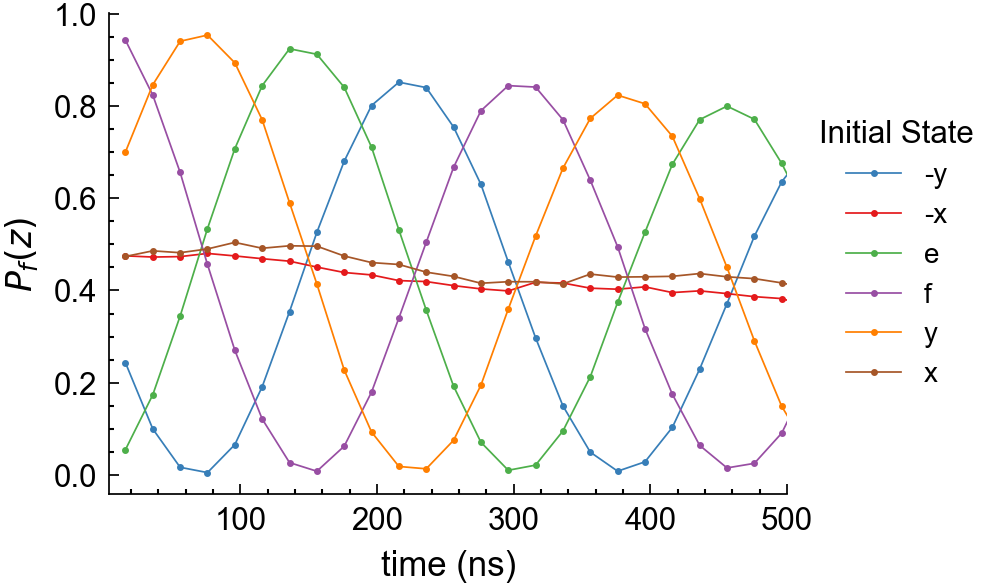

In [4]:
plt.figure(dpi = 250)
for state in init_states:
    if '0.0300000' == amp:
        plot_data = data_dict[state][amp]['scaled']
        time_vals = plot_data['time']
        prob_plot = plot_data['P_f_z']
        if 'x' == state:
            plt.plot(time_vals, prob_plot, lw = 0.5, label = 'y', marker = 'o', ms = 1)
        elif '-x' == state:
            plt.plot(time_vals, prob_plot, lw = 0.5, label = '-y', marker = 'o', ms = 1)
        elif '-y' == state:
            plt.plot(time_vals, prob_plot, lw = 0.5, label = '-x', marker = 'o', ms = 1)
        elif 'y' == state:
            plt.plot(time_vals, prob_plot, lw = 0.5, label = 'x', marker = 'o', ms = 1)
        else:
            plt.plot(time_vals, prob_plot, lw = 0.5, label = state, marker = 'o', ms = 1)
            
plt.legend(
    title="Initial State",
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),  # move outside the axes
    frameon=False
)
plt.ylabel(r'$P_f(z)$')
plt.xlim(4, 500)
plt.xlabel('time (ns)')
savefig_tight('Images/state_prep.pdf')
plt.show()
        

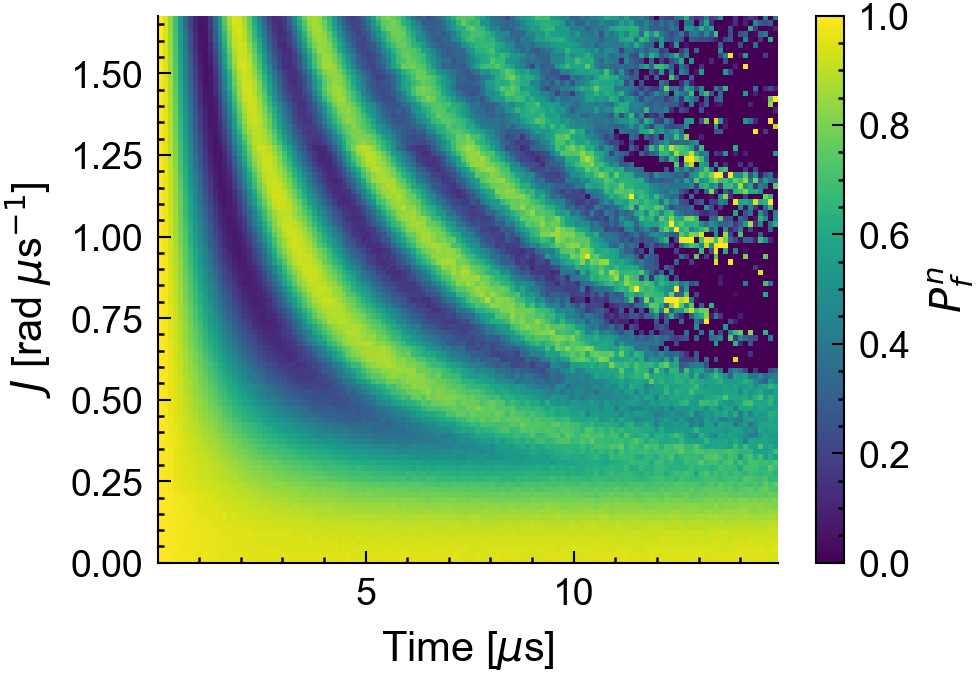

In [5]:
omega_v_j = pd.read_csv("omega_vs_J.csv")
omega_v_pf = pd.read_csv("omega_from_normalized_Pf.csv")

save_dir = "sweep_J_data"
filename = "pf_pe_pg_initf.pkl"
filepath = os.path.join(save_dir, filename)
with open(filepath, "rb") as f:
    data = pickle.load(f)

all_P_f = np.array(data["all_P_f"])  # shape: (num_amps, num_time_steps)
all_P_e = np.array(data["all_P_e"])
all_P_g = np.array(data["all_P_g"])
amp_vals = np.array(data["amplitude"])
time_vals_ns = np.array(data["time_vals_ns"])


denom = all_P_f + all_P_e
norm_P_f = np.divide(all_P_f, denom, out=np.zeros_like(all_P_f), where=denom != 0)
norm_P_e = np.divide(all_P_e, denom, out=np.zeros_like(all_P_e), where=denom != 0)
# norm_P_f has shape (num_amps, num_time_steps)
time_vals_us = time_vals_ns * 1e-3  # Convert ns → µs

# Normalize P_f by (P_f + P_e)
norm_P_f_matrix = all_P_f / (all_P_f + all_P_e + 1e-12)
# Plot normalized P_f
plt.figure()
plt.imshow(norm_P_f_matrix, aspect='auto', origin='lower',
           extent=[time_vals_ns[0]/1000, time_vals_ns[-1]/1000, a_to_J*amp_vals[0], a_to_J*amp_vals[-1]],
           cmap='viridis')
plt.colorbar(label='$P^n_f$')
plt.xlabel(r"Time [$\mu$s]")
plt.ylabel(r"$J$ [rad $\mu$s$^{-1}$]")
plt.tight_layout()
savefig_tight('Images/J_implot_normalized.pdf')
plt.show()



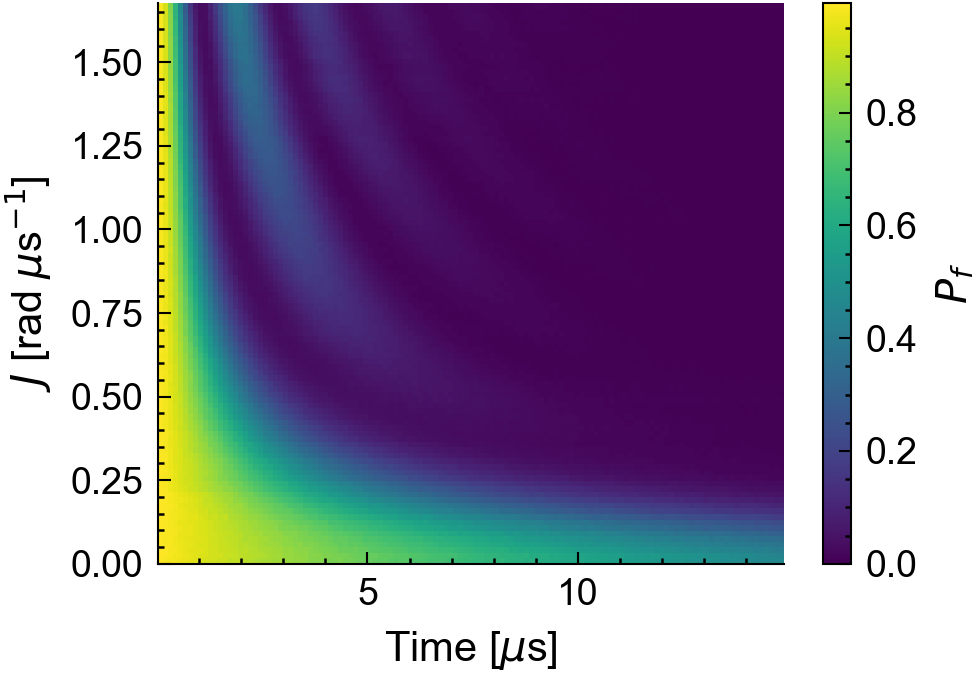

In [6]:
plt.imshow(all_P_f, aspect='auto', origin='lower',
           extent=[time_vals_ns[0]/1000, time_vals_ns[-1]/1000, a_to_J*amp_vals[0], a_to_J*amp_vals[-1]],
           cmap='viridis')
plt.colorbar(label='$P_f$')
plt.xlabel(r"Time [$\mu$s]")
plt.ylabel(r"$J$ [rad $\mu$s$^{-1}$]")
plt.tight_layout()
plt.show()

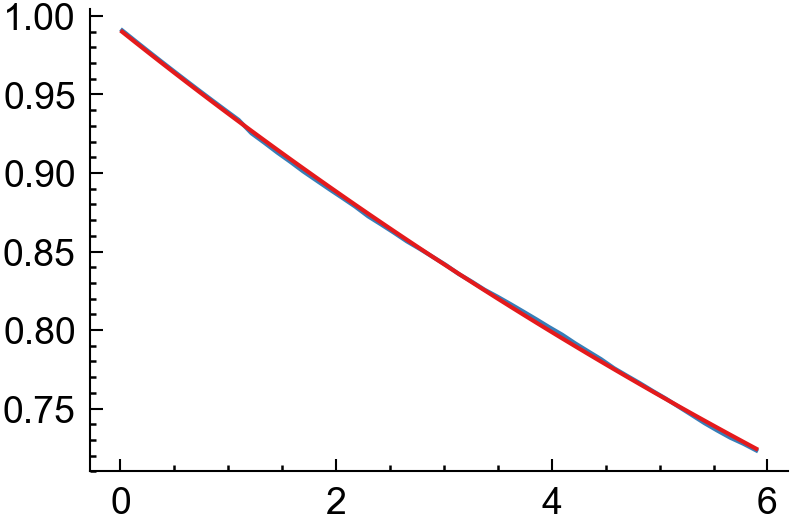

freq:1.6105975758229913e-07,gamma: 0.06813172902515365, amp:5.17625591368791, phase_deg: 23.228879379864175,offset: 0.18556640655132994,
J = 0.00000: ω = 0.00000 rad/μs


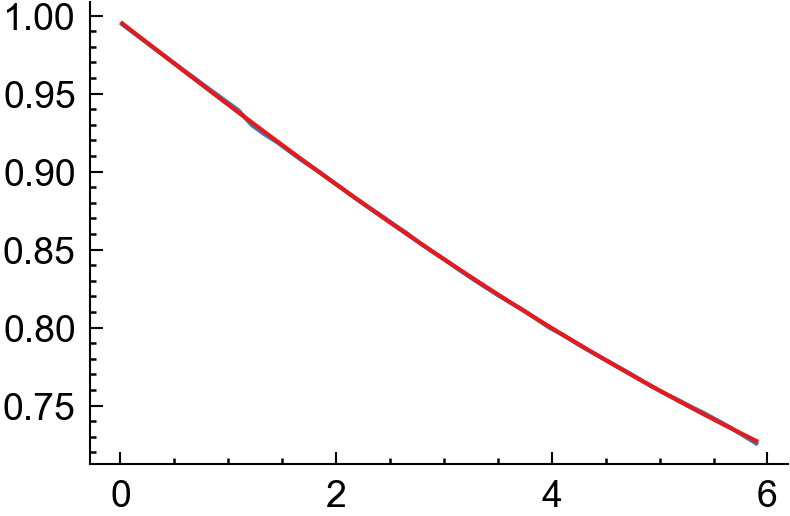

freq:0.0015625399322044087,gamma: 0.26124533479495465, amp:29.246076464341222, phase_deg: 7.40104721818892,offset: 0.5105408632419776,
J = 0.01677: ω = 0.00982 rad/μs


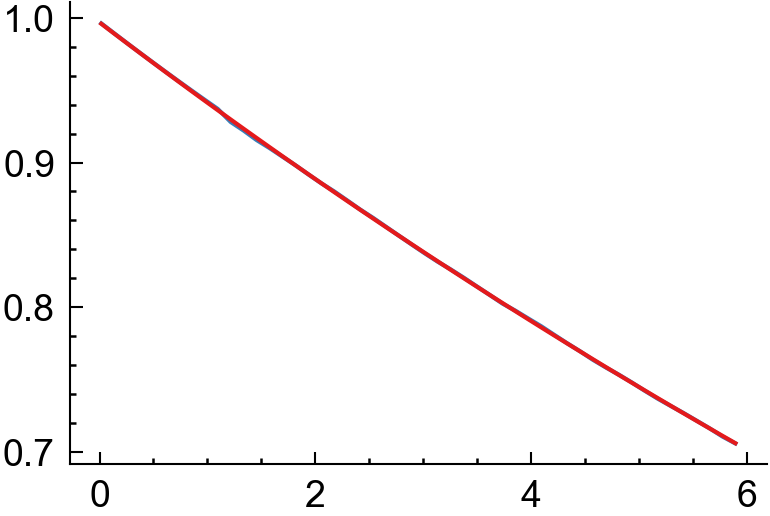

freq:2.0314360511086248e-11,gamma: 0.04908125498302388, amp:5.817827445410579, phase_deg: 26.504008125700373,offset: -0.16166436015365468,
J = 0.03355: ω = 0.00000 rad/μs


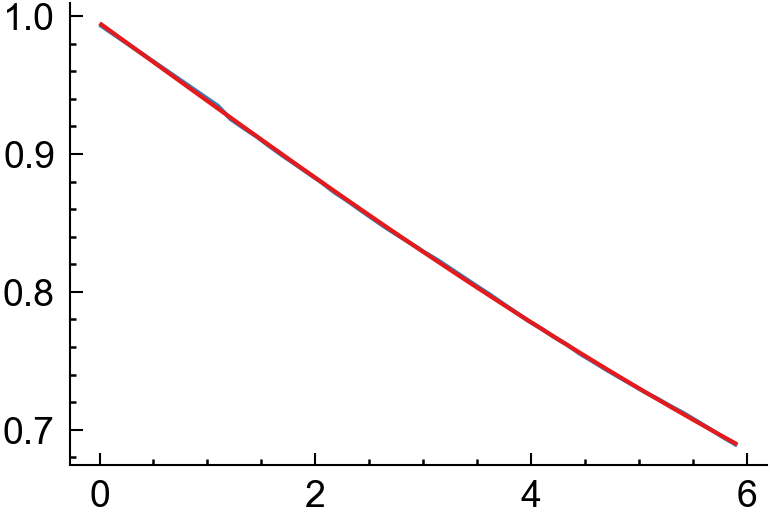

freq:0.0015257067520440947,gamma: 0.2110483882176141, amp:29.35145986133526, phase_deg: 8.647959443344208,offset: 0.33128508200687096,
J = 0.05032: ω = 0.00959 rad/μs


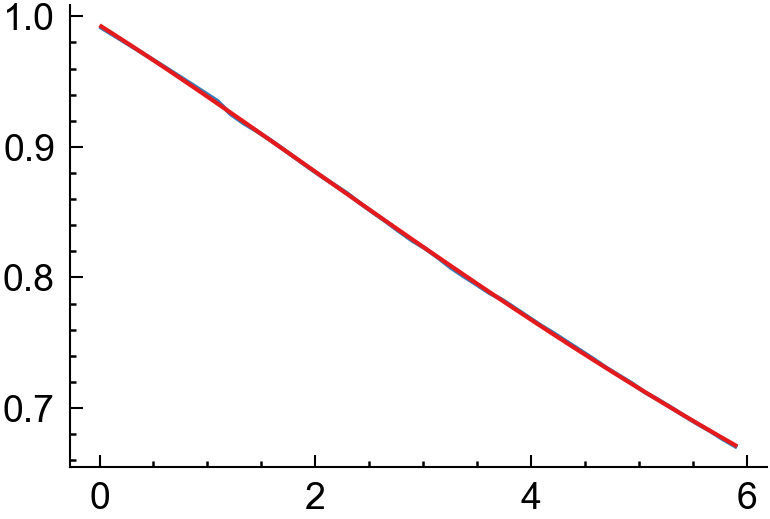

freq:0.002113809719420762,gamma: 0.25866633587102605, amp:29.898805098872547, phase_deg: 8.470588045946405,offset: 0.34435491696167303,
J = 0.06710: ω = 0.01328 rad/μs


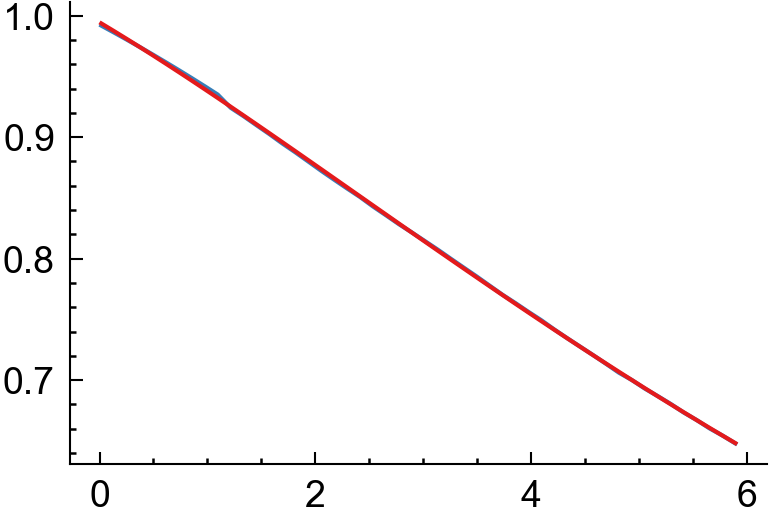

freq:0.0023050214986269943,gamma: 0.2591157604831842, amp:29.883069542300394, phase_deg: 8.897049933567613,offset: 0.2796969191323505,
J = 0.08387: ω = 0.01448 rad/μs


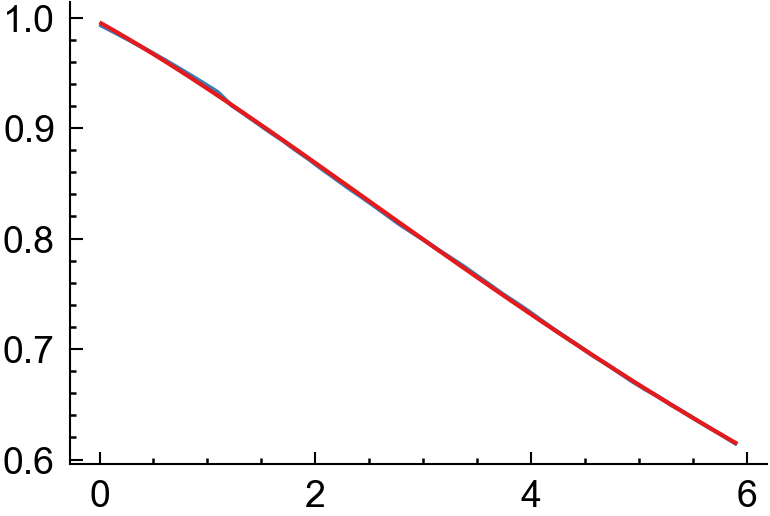

freq:0.002755241419108475,gamma: 0.29525299939403343, amp:29.93329713476216, phase_deg: 8.935569410576626,offset: 0.2733650932231392,
J = 0.10065: ω = 0.01731 rad/μs


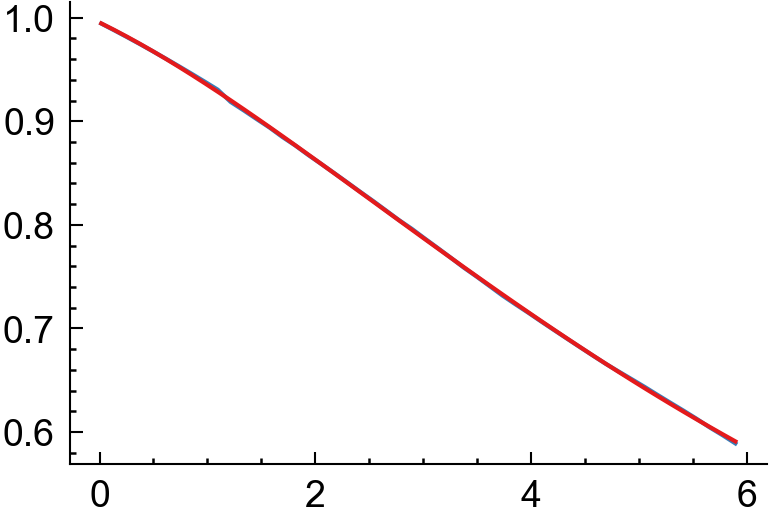

freq:0.003353753794099962,gamma: 0.3461984957982293, amp:29.904185091822864, phase_deg: 8.77073344640263,offset: 0.2999374371050435,
J = 0.11742: ω = 0.02107 rad/μs


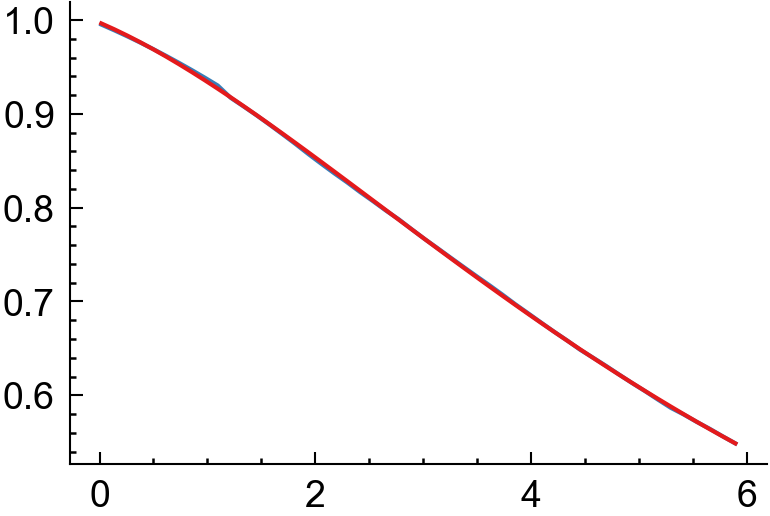

freq:0.003948450589862292,gamma: 0.38198721125558627, amp:29.955828117714937, phase_deg: 8.973032239136385,offset: 0.26846245479015646,
J = 0.13420: ω = 0.02481 rad/μs


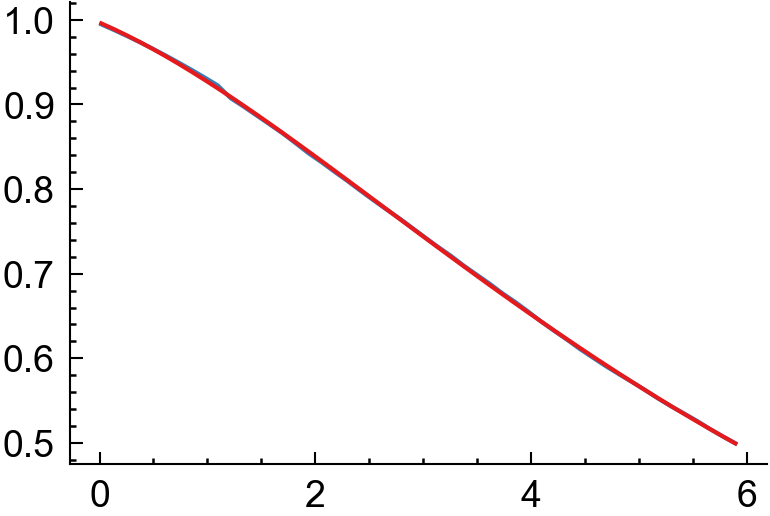

freq:0.004070279726675589,gamma: 0.3700667602761432, amp:29.9610083555549, phase_deg: 9.564176395963443,offset: 0.16956714294547337,
J = 0.15097: ω = 0.02557 rad/μs


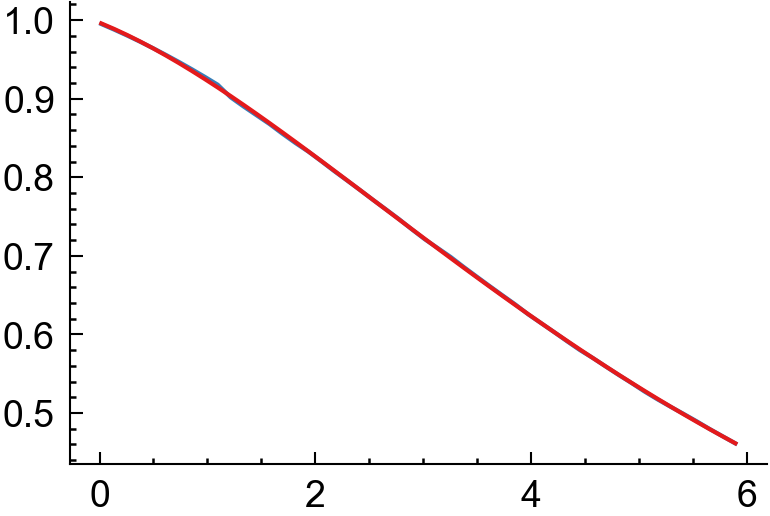

freq:0.004480152077719835,gamma: 0.39426555802593255, amp:29.94848839225, phase_deg: 9.71623291838016,offset: 0.14374191496533328,
J = 0.16775: ω = 0.02815 rad/μs


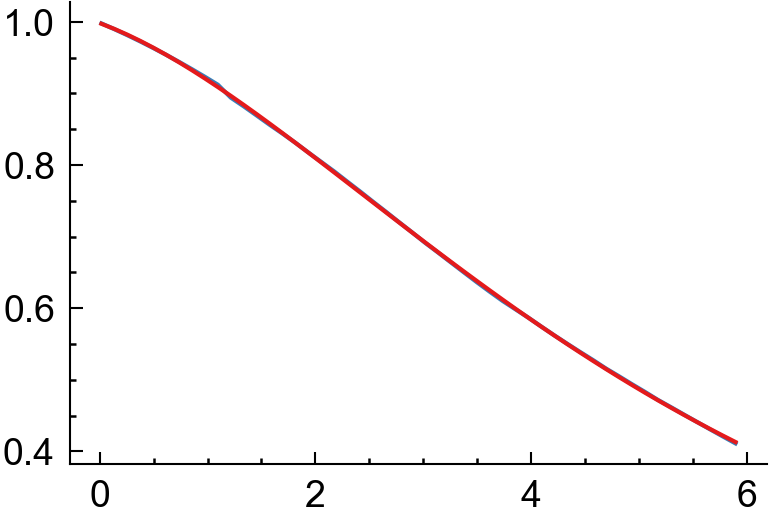

freq:0.005152565149646602,gamma: 0.4395075661394664, amp:29.96614347127892, phase_deg: 9.789290517134623,offset: 0.13176947325390442,
J = 0.18452: ω = 0.03237 rad/μs


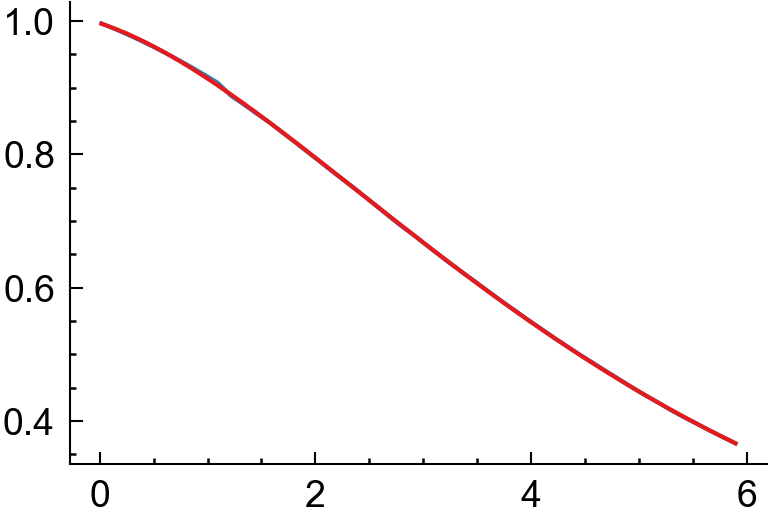

freq:0.005700647575375859,gamma: 0.4657714280082348, amp:29.99367872231985, phase_deg: 9.990212681061704,offset: 0.09406914185152983,
J = 0.20130: ω = 0.03582 rad/μs


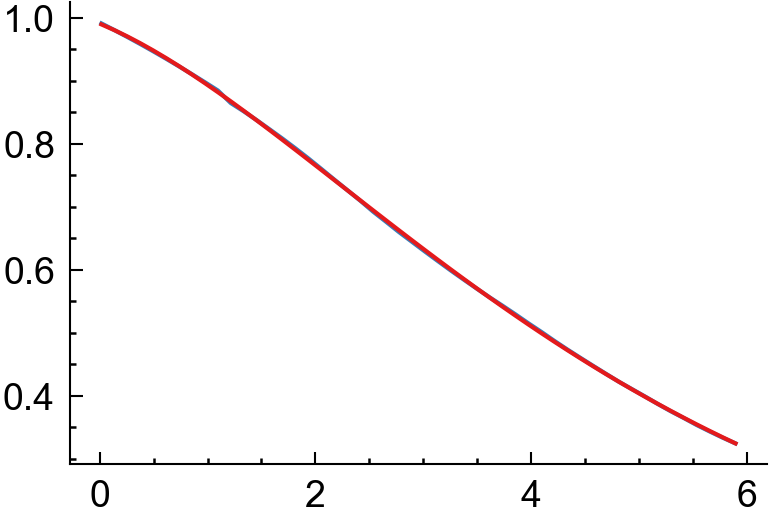

freq:0.005504837588859893,gamma: 0.45742157369617764, amp:29.985161113136705, phase_deg: 10.24583218897829,offset: 0.042225999149097485,
J = 0.21807: ω = 0.03459 rad/μs


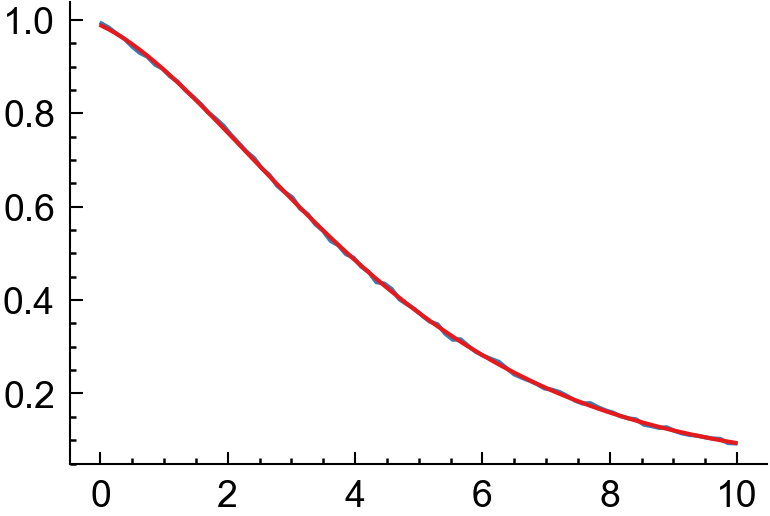

freq:0.01415214605990006,gamma: 0.45080460421784063, amp:5.394091418841201, phase_deg: 24.825230528887225,offset: 0.03784397307333648,
J = 0.23485: ω = 0.08892 rad/μs


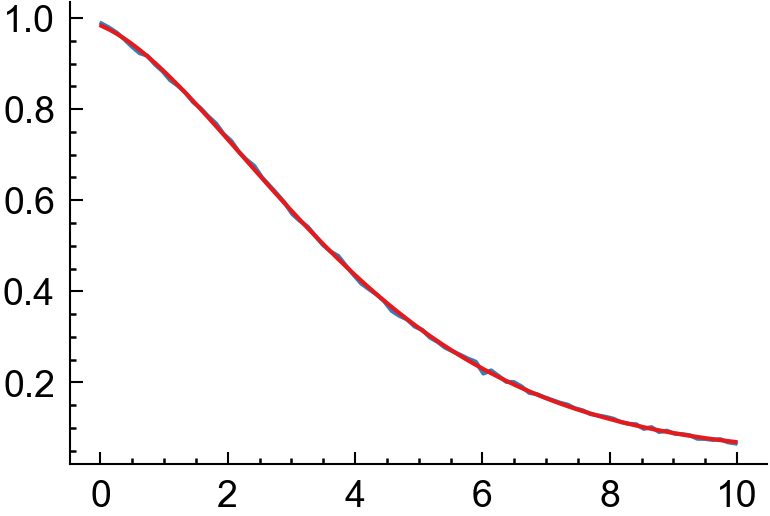

freq:0.01942443484678651,gamma: 0.4748863798179395, amp:3.646073996993406, phase_deg: 30.608037287038517,offset: 0.038479299104383156,
J = 0.25162: ω = 0.12205 rad/μs


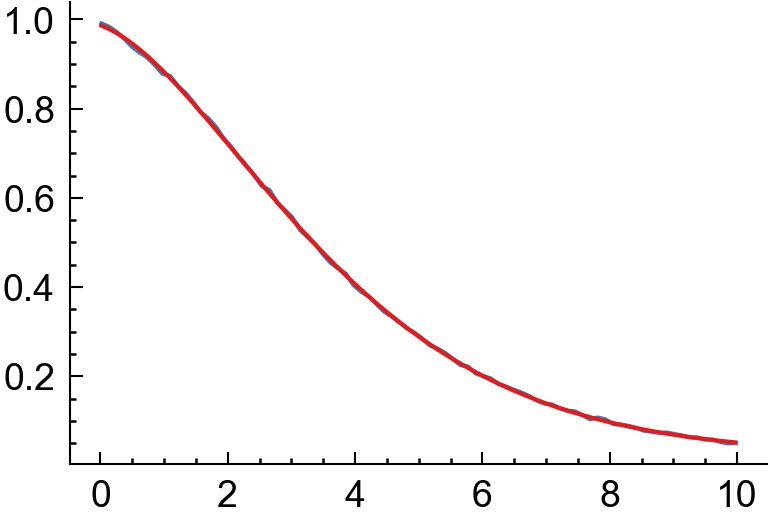

freq:0.01753550800612348,gamma: 0.5334373327491968, amp:5.497802305912944, phase_deg: 24.729855935981725,offset: 0.02486753698612748,
J = 0.26840: ω = 0.11018 rad/μs


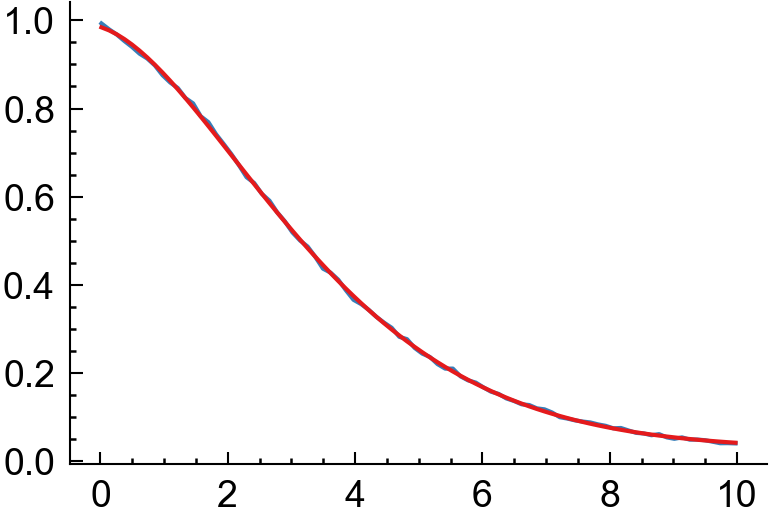

freq:0.02337331656374439,gamma: 0.5379636550591006, amp:3.6214867306181273, phase_deg: 30.940959793663147,offset: 0.027625224946599393,
J = 0.28517: ω = 0.14686 rad/μs


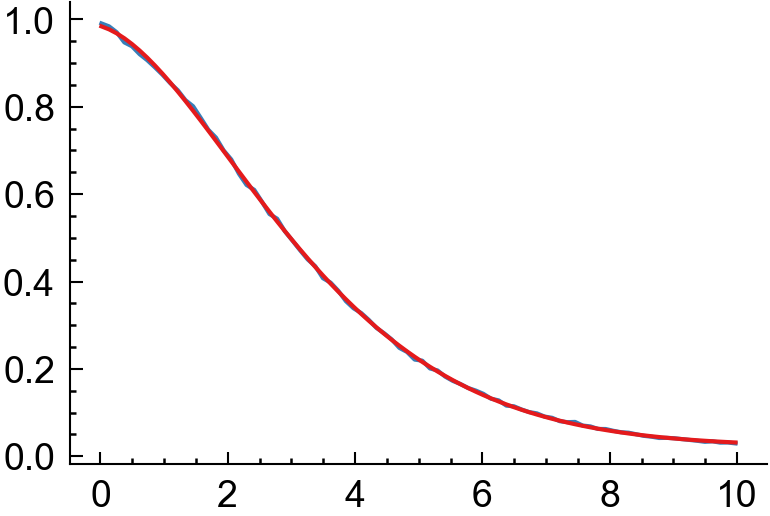

freq:0.025581775672206826,gamma: 0.5610778192897363, amp:3.434086527192349, phase_deg: 31.962012301069972,offset: 0.02264533479144302,
J = 0.30195: ω = 0.16074 rad/μs


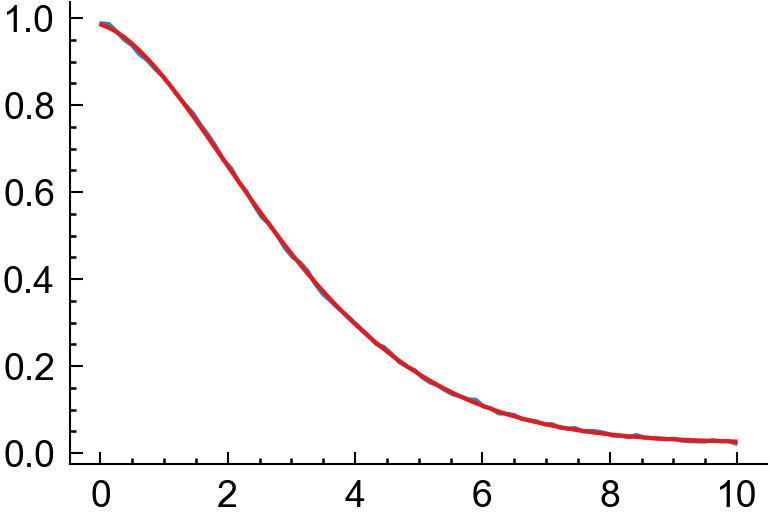

freq:0.03093978167066598,gamma: 0.5656049228887623, amp:2.6793050193996155, phase_deg: 36.79905822196408,offset: 0.02404431557154597,
J = 0.31872: ω = 0.19440 rad/μs


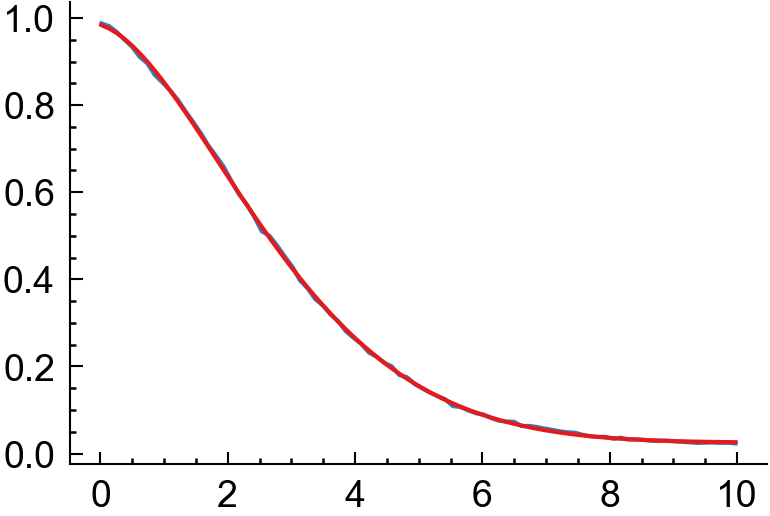

freq:0.03457906201179622,gamma: 0.5669126752280044, amp:2.3132374655596384, phase_deg: 40.08372674278882,offset: 0.02551362164167019,
J = 0.33550: ω = 0.21727 rad/μs


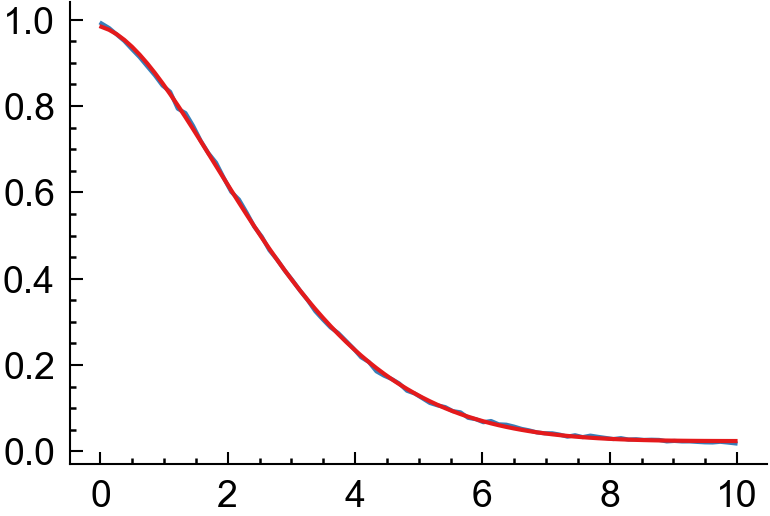

freq:0.037849959908253086,gamma: 0.5879199206266253, amp:2.2297903930761316, phase_deg: 41.00706887793656,offset: 0.024009865295789273,
J = 0.35227: ω = 0.23782 rad/μs


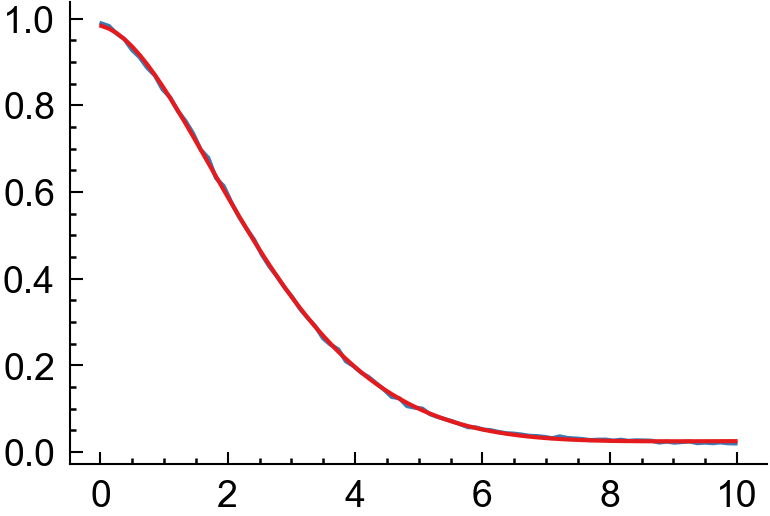

freq:0.042459950888778804,gamma: 0.6090949113979103, amp:2.077019614192752, phase_deg: 42.80612397691473,offset: 0.02493824413820523,
J = 0.36905: ω = 0.26678 rad/μs


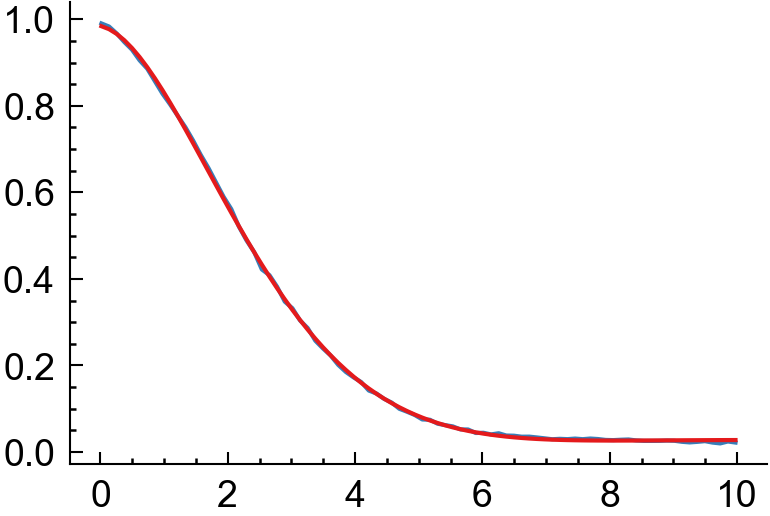

freq:0.046106941565241547,gamma: 0.6023374268041768, amp:1.8757101563043537, phase_deg: 45.618612576645866,offset: 0.026491468834749943,
J = 0.38582: ω = 0.28970 rad/μs


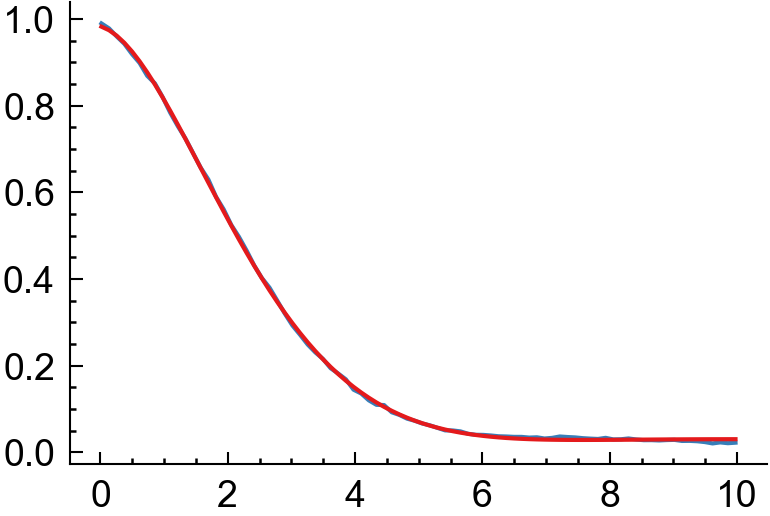

freq:0.04872162373240152,gamma: 0.6154043879256689, amp:1.7780550054129411, phase_deg: 47.11027563971619,offset: 0.028789797109332594,
J = 0.40260: ω = 0.30613 rad/μs


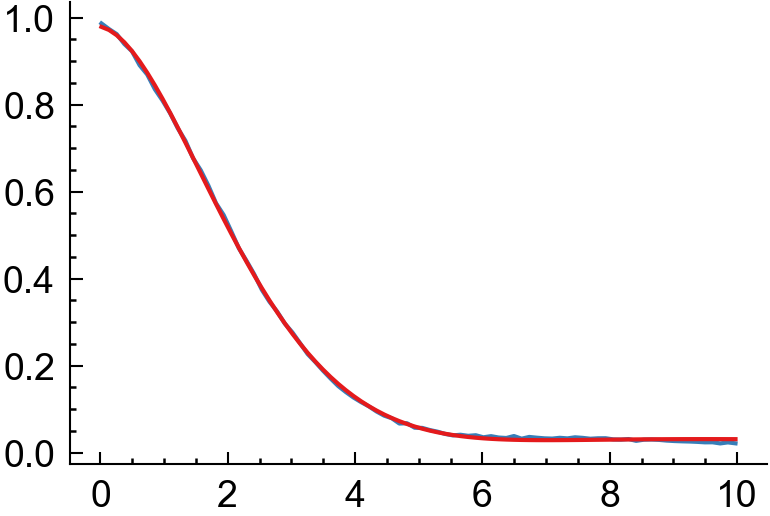

freq:0.05223609471327312,gamma: 0.6236761342312772, amp:1.7165317436858887, phase_deg: 48.087551528310236,offset: 0.028659314204283467,
J = 0.41937: ω = 0.32821 rad/μs


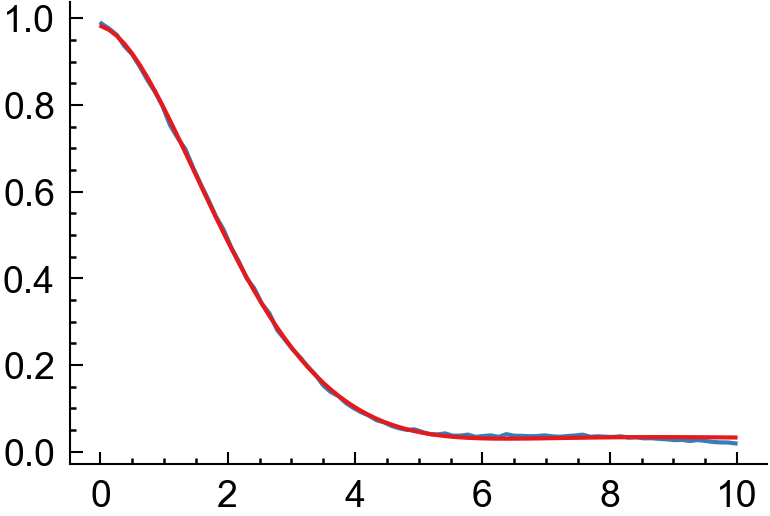

freq:0.05640743287474892,gamma: 0.6313229092062111, amp:1.6099911437948586, phase_deg: 50.25691630707626,offset: 0.03040625733045139,
J = 0.43615: ω = 0.35442 rad/μs


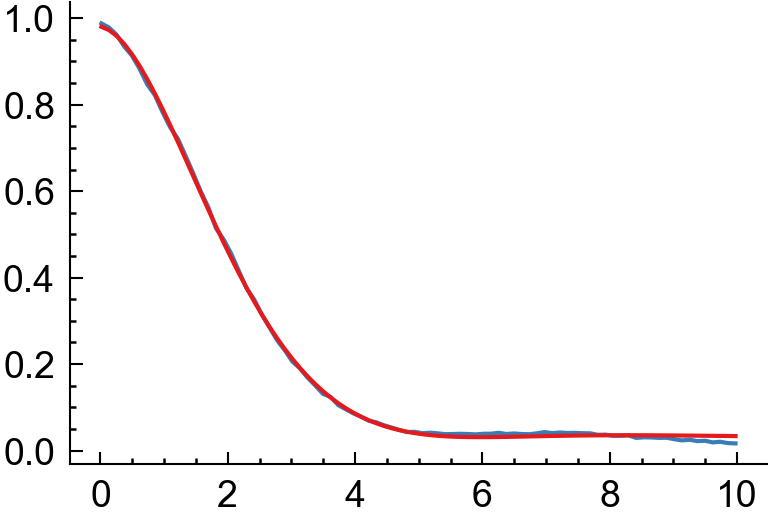

freq:0.0600752142137234,gamma: 0.6456102819606293, amp:1.5743292854406021, phase_deg: 50.95169626401328,offset: 0.0310700360886553,
J = 0.45292: ω = 0.37746 rad/μs


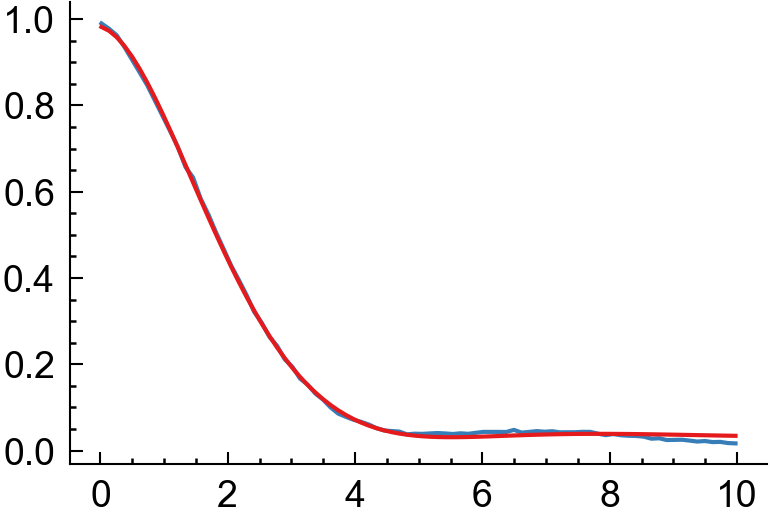

freq:0.06316662182716486,gamma: 0.6068168787212934, amp:1.4304540633326936, phase_deg: 54.64378176963372,offset: 0.0309584962949521,
J = 0.46970: ω = 0.39689 rad/μs


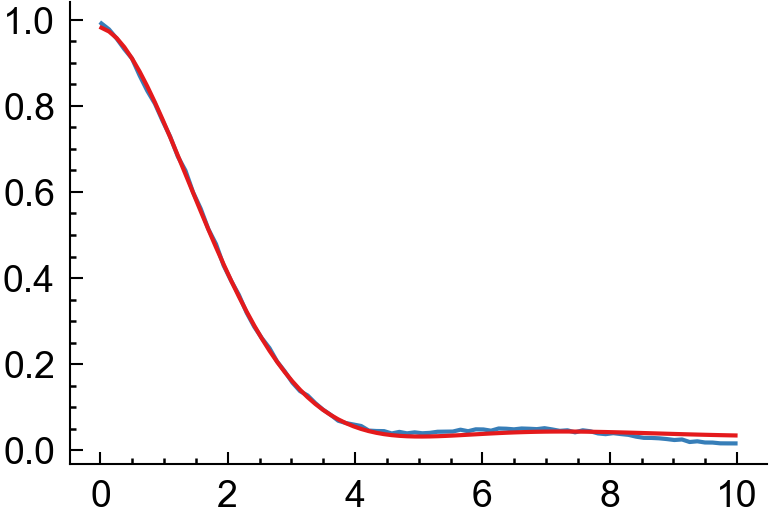

freq:0.06806312460827096,gamma: 0.599435099730116, amp:1.3574565638038651, phase_deg: 56.77406031753429,offset: 0.03198301756209567,
J = 0.48647: ω = 0.42765 rad/μs


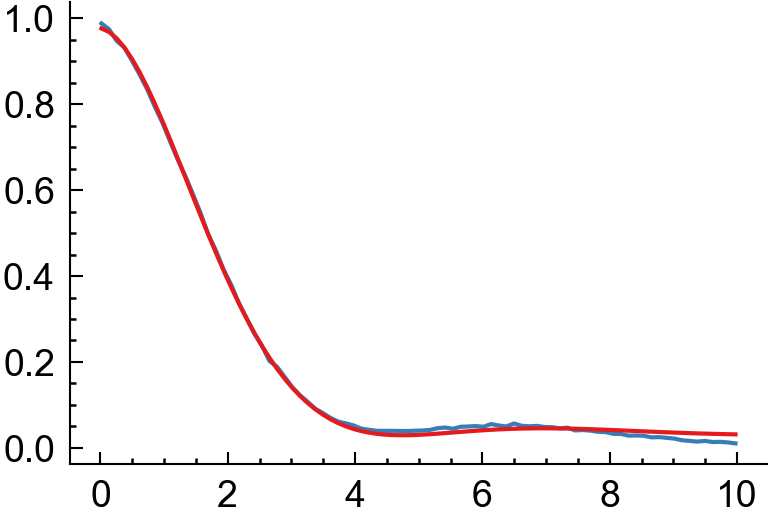

freq:0.07122712070938884,gamma: 0.580397793116736, amp:1.3043207283185865, phase_deg: 58.44844421070712,offset: 0.029475204548055488,
J = 0.50325: ω = 0.44753 rad/μs


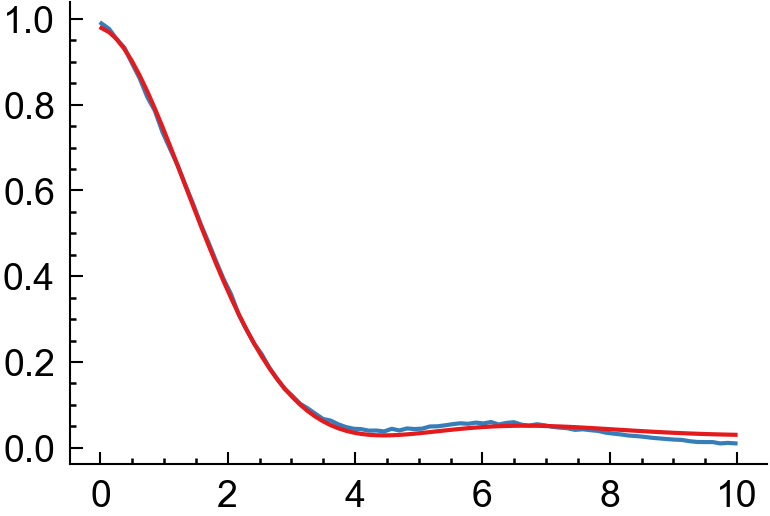

freq:0.07415549814521363,gamma: 0.554697525689773, amp:1.237975496967158, phase_deg: 61.18093065445187,offset: 0.028949087209815302,
J = 0.52002: ω = 0.46593 rad/μs


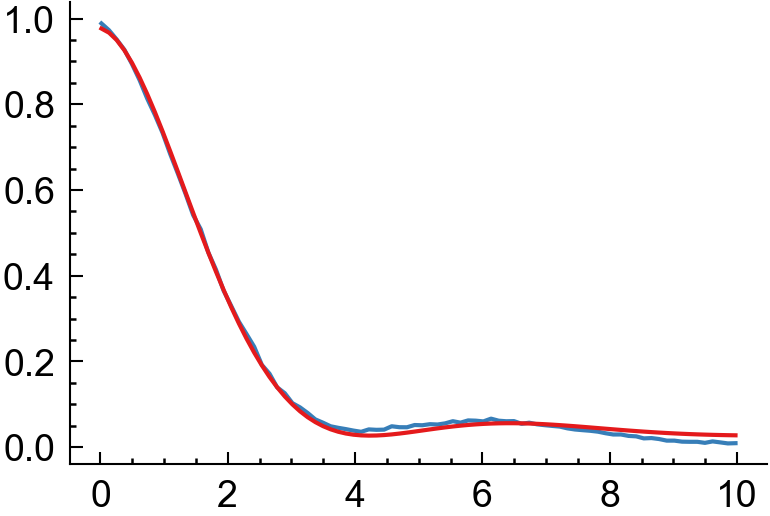

freq:0.07687720633102918,gamma: 0.5369346484397587, amp:1.1994596482603048, phase_deg: 62.90078633078718,offset: 0.026970861460433003,
J = 0.53680: ω = 0.48303 rad/μs


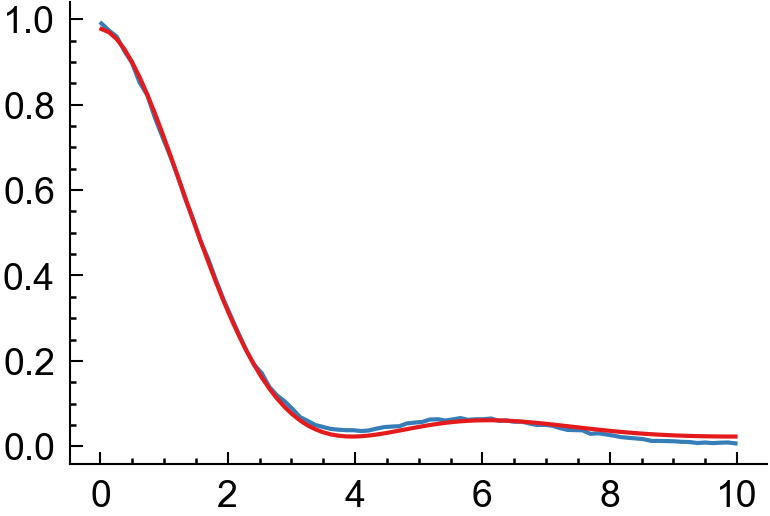

freq:0.08175307886688742,gamma: 0.5261852426703568, amp:1.188544940409294, phase_deg: 63.71007477631061,offset: 0.02256121614797178,
J = 0.55357: ω = 0.51367 rad/μs


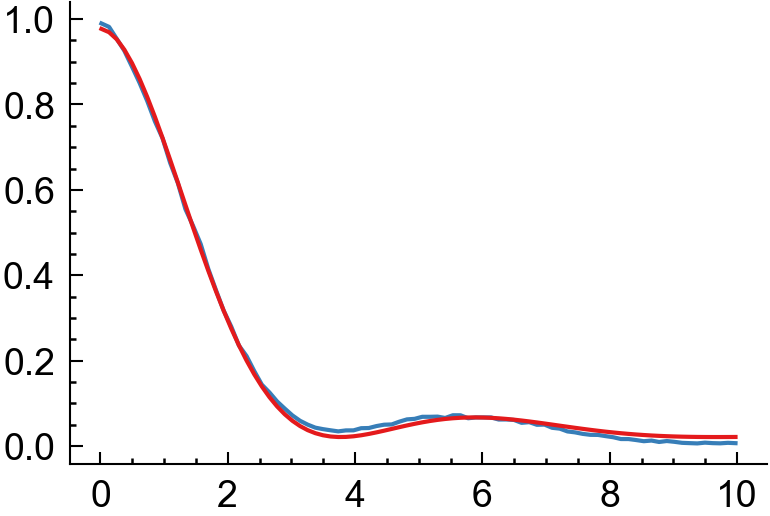

freq:0.08468428919577793,gamma: 0.5140459195966236, amp:1.1651551283685828, phase_deg: 64.96027963957579,offset: 0.020971786070435774,
J = 0.57035: ω = 0.53209 rad/μs


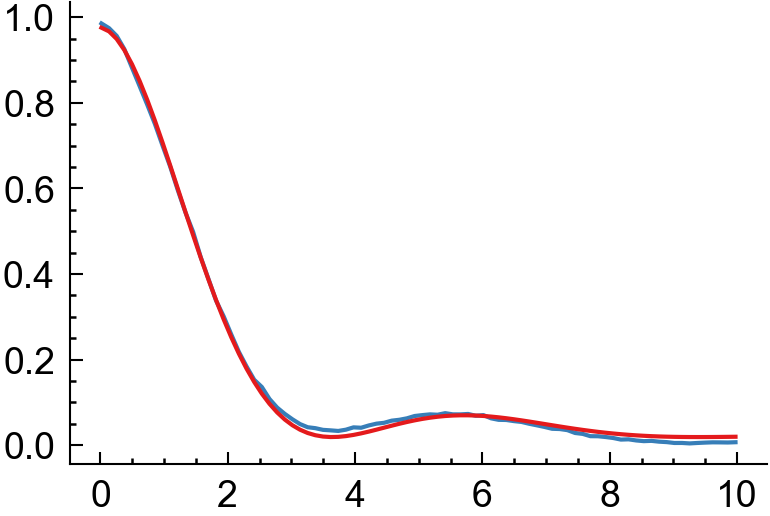

freq:0.08702760092688477,gamma: 0.5108209058049755, amp:1.1474552394636661, phase_deg: 65.9413465929447,offset: 0.019162437028921005,
J = 0.58712: ω = 0.54681 rad/μs


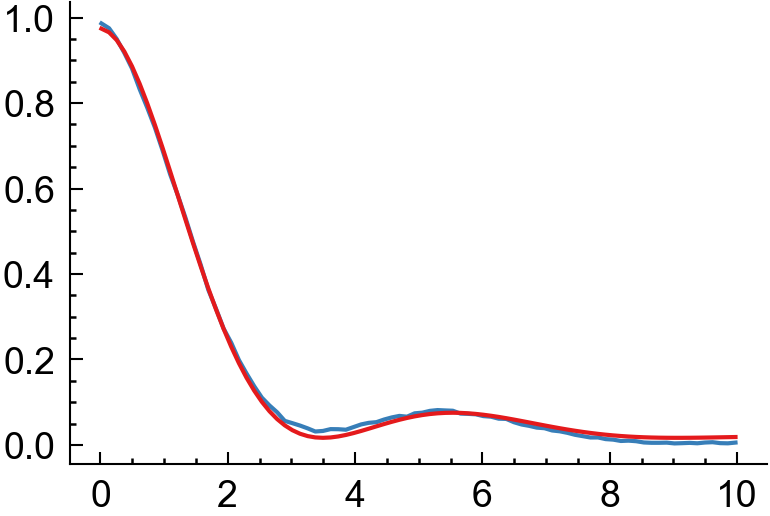

freq:0.08991963696798318,gamma: 0.5022855145720109, amp:1.133012328903289, phase_deg: 66.85960909570558,offset: 0.016665896126258028,
J = 0.60390: ω = 0.56498 rad/μs


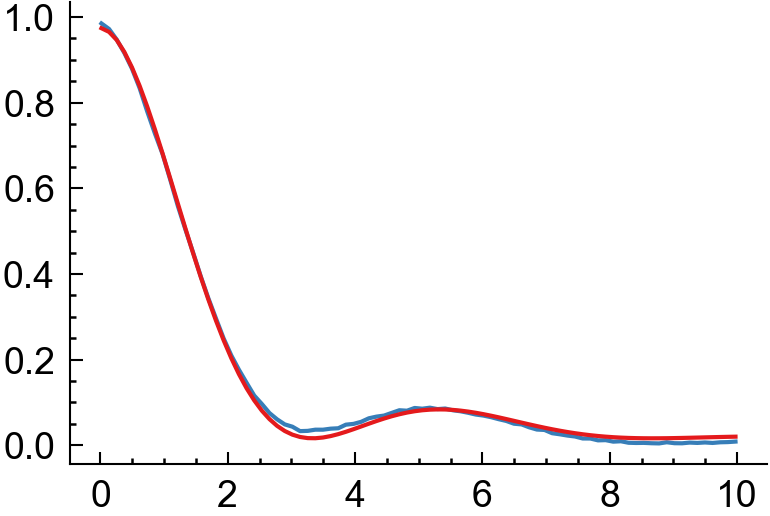

freq:0.09360139515892006,gamma: 0.4965970495041955, amp:1.1183078915407365, phase_deg: 67.74580314972462,offset: 0.016350191609196832,
J = 0.62067: ω = 0.58811 rad/μs


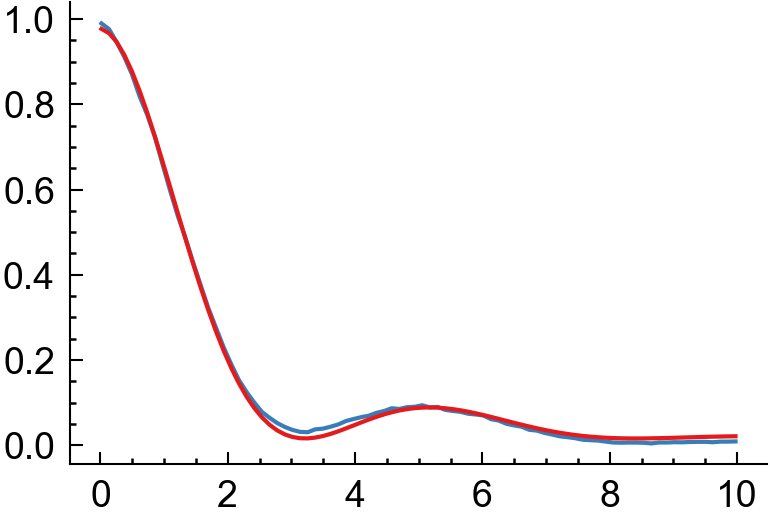

freq:0.09624129172494317,gamma: 0.49688350539762105, amp:1.1081351617102, phase_deg: 68.69150157559629,offset: 0.015708837297305864,
J = 0.63745: ω = 0.60470 rad/μs


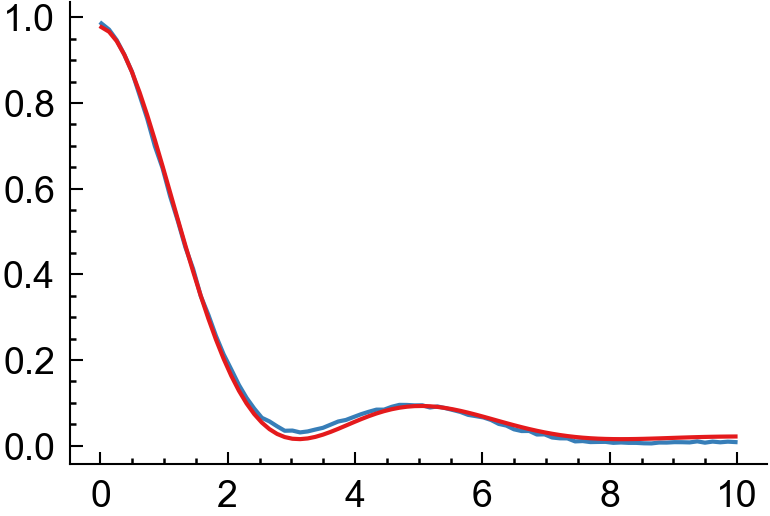

freq:0.09869275059783293,gamma: 0.4974457946176381, amp:1.1002827134878466, phase_deg: 69.27646239587189,offset: 0.015128050057224398,
J = 0.65422: ω = 0.62010 rad/μs


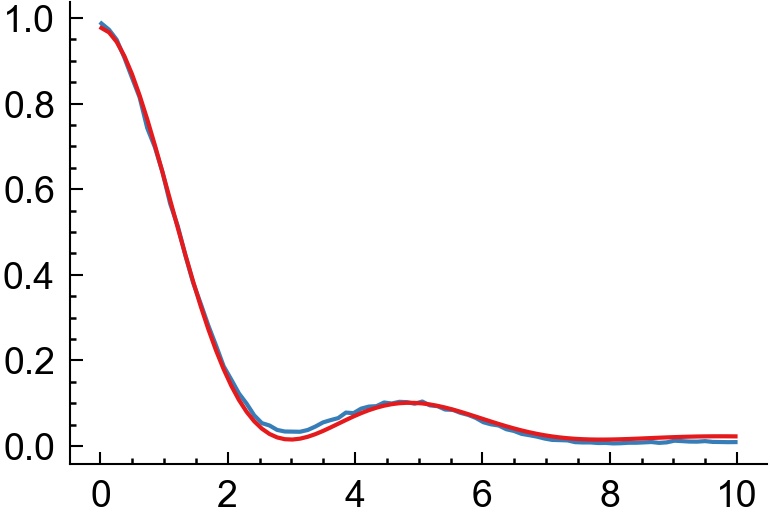

freq:0.10252731418922051,gamma: 0.4951520082404476, amp:1.0931490235354886, phase_deg: 69.75626374465573,offset: 0.014977226459383323,
J = 0.67100: ω = 0.64420 rad/μs


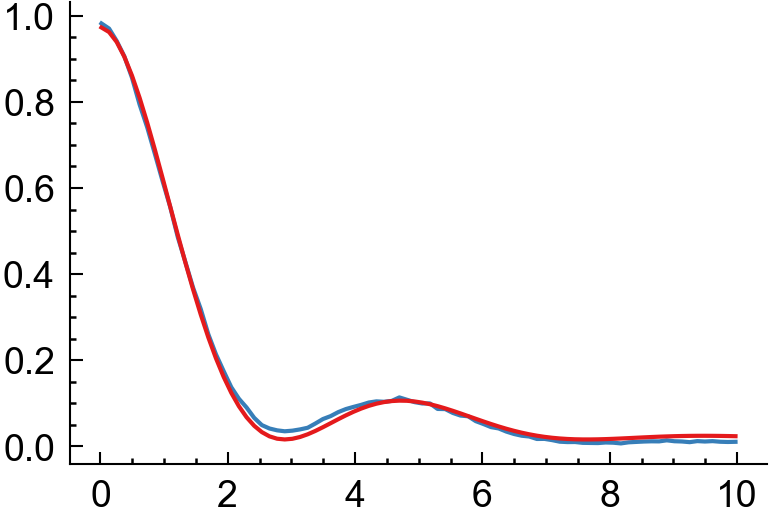

freq:0.10541238161264471,gamma: 0.49814830054465864, amp:1.0823169478743218, phase_deg: 70.12270963996352,offset: 0.016027473312298018,
J = 0.68777: ω = 0.66233 rad/μs


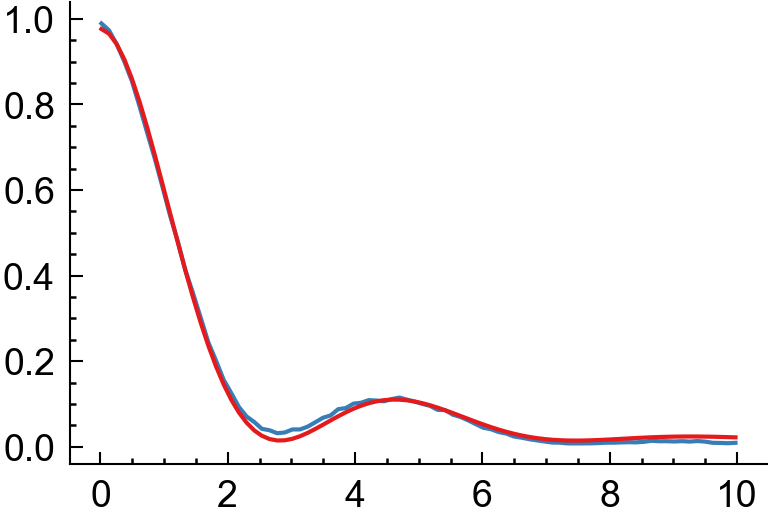

freq:0.10769685221075372,gamma: 0.4967988198631052, amp:1.0811240268291746, phase_deg: 70.62032843439269,offset: 0.014753326114629891,
J = 0.70455: ω = 0.67668 rad/μs


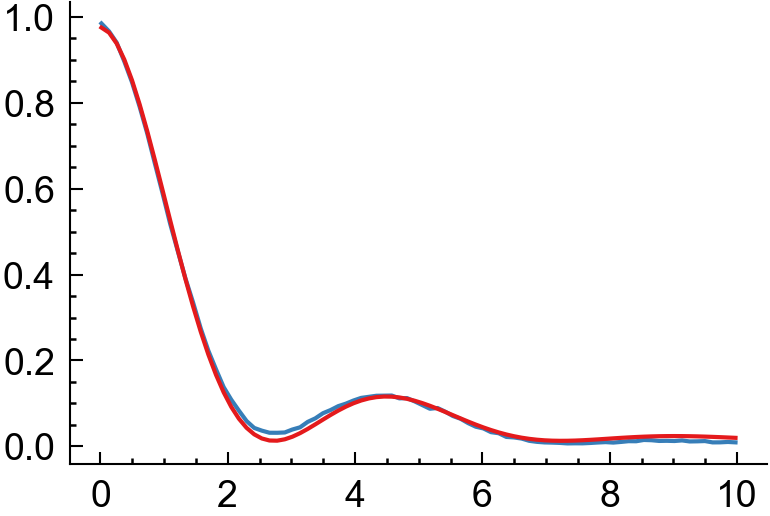

freq:0.1107271853355464,gamma: 0.4946206791464011, amp:1.0738603167107714, phase_deg: 71.24834321883199,offset: 0.012819989422070053,
J = 0.72132: ω = 0.69572 rad/μs


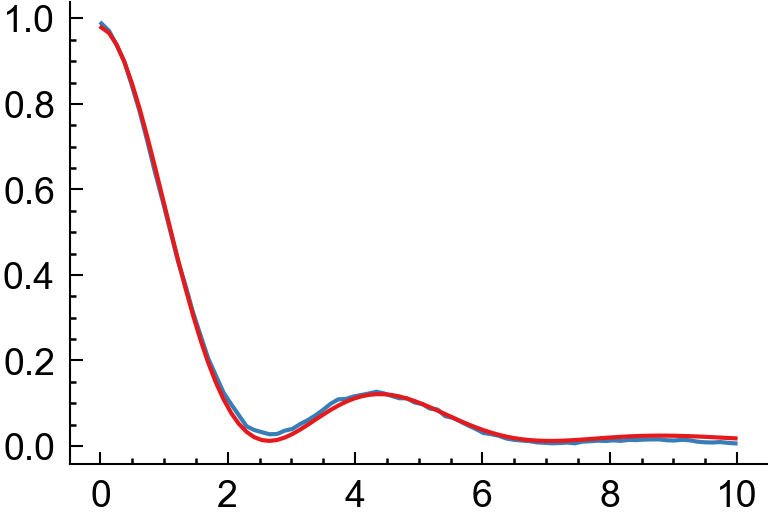

freq:0.11326141104755469,gamma: 0.49365201288689053, amp:1.069503492916456, phase_deg: 72.02198304466475,offset: 0.011903564351946392,
J = 0.73810: ω = 0.71164 rad/μs


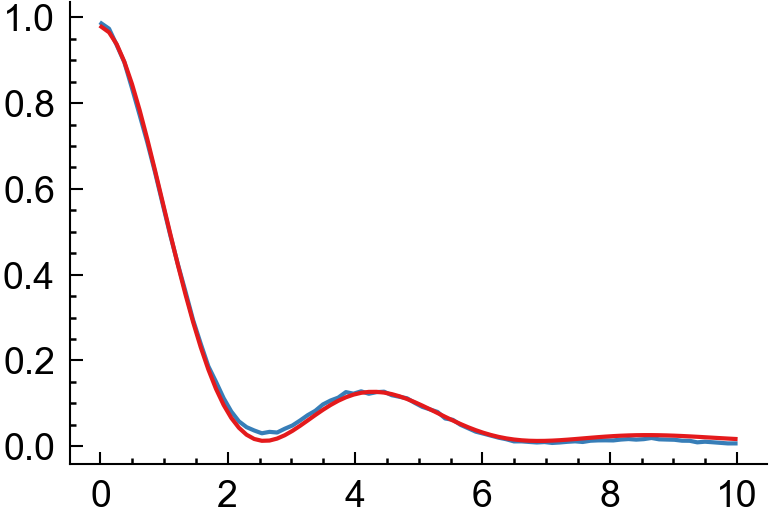

freq:0.11616512476094511,gamma: 0.49523032418832447, amp:1.0668709102481568, phase_deg: 72.11731793751953,offset: 0.012173078186495689,
J = 0.75487: ω = 0.72989 rad/μs


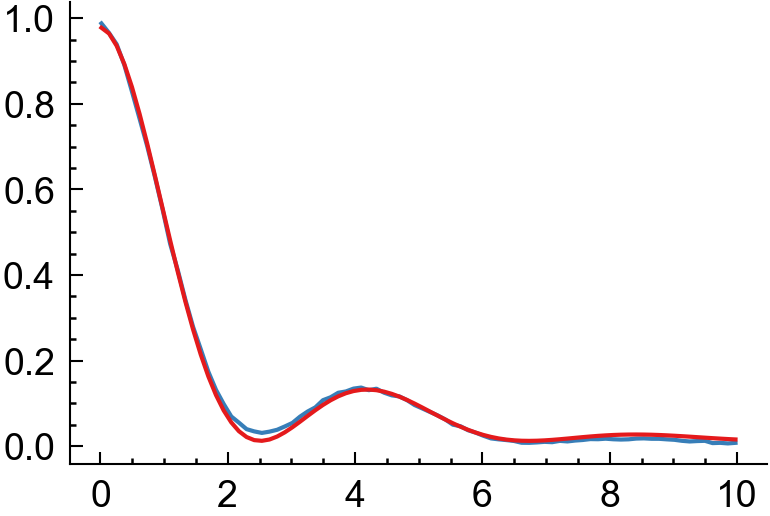

freq:0.11869455417438081,gamma: 0.49537546037382696, amp:1.0618156851155116, phase_deg: 72.54822389622541,offset: 0.012260713694143647,
J = 0.77165: ω = 0.74578 rad/μs


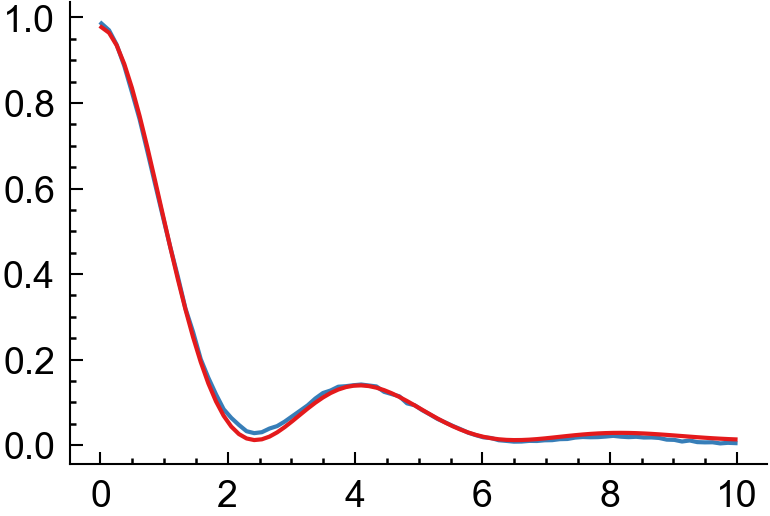

freq:0.12234840333050609,gamma: 0.4946266631244702, amp:1.0589354079878626, phase_deg: 72.76156808021996,offset: 0.011840282860014213,
J = 0.78842: ω = 0.76874 rad/μs


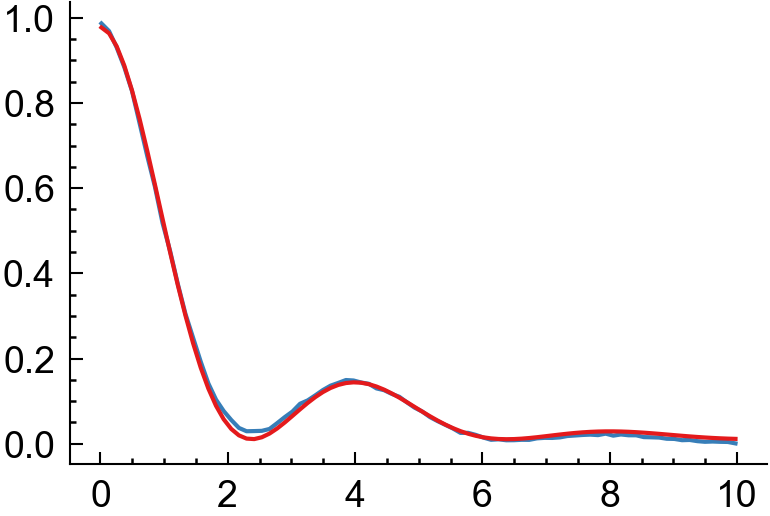

freq:0.12480214123319867,gamma: 0.4942067423415595, amp:1.0558481205175572, phase_deg: 73.12595019096193,offset: 0.010691857598635094,
J = 0.80520: ω = 0.78415 rad/μs


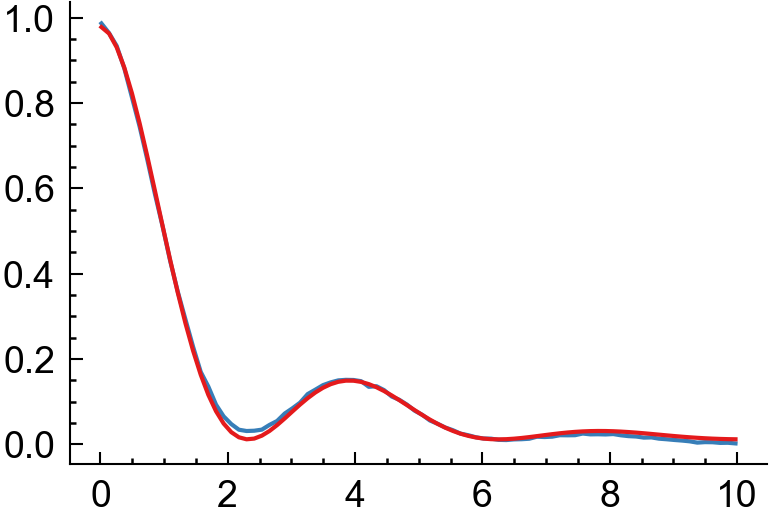

freq:0.12722991823732815,gamma: 0.4956522166537434, amp:1.050061536018204, phase_deg: 73.6641560676491,offset: 0.011547302030796793,
J = 0.82197: ω = 0.79941 rad/μs


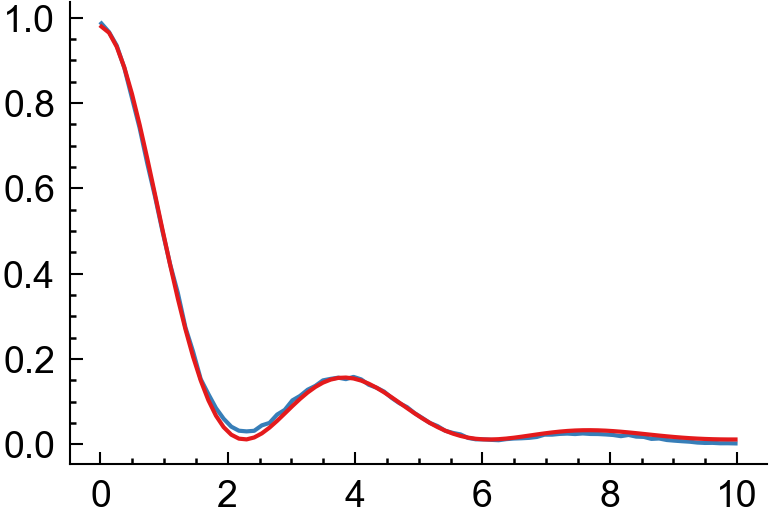

freq:0.1302373078145901,gamma: 0.4941800517000219, amp:1.050685613287221, phase_deg: 73.73524254104252,offset: 0.01115601492116788,
J = 0.83875: ω = 0.81831 rad/μs


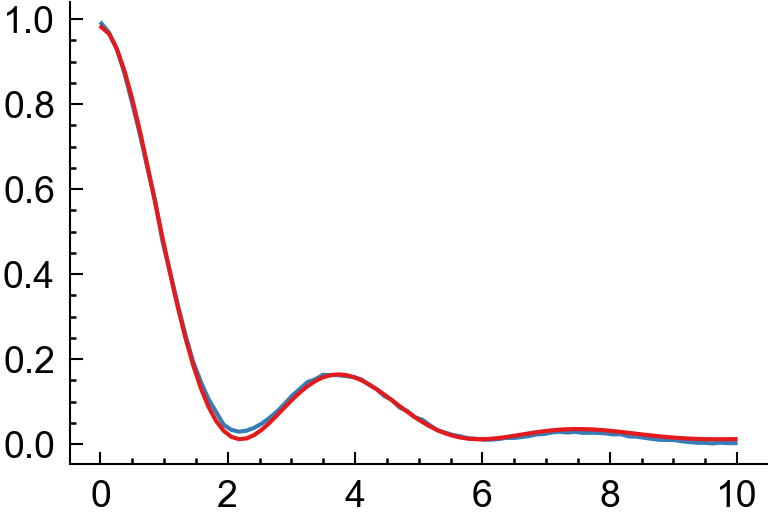

freq:0.13317359149446178,gamma: 0.4926337391910374, amp:1.046260088176968, phase_deg: 74.35585498991975,offset: 0.011529550712937212,
J = 0.85552: ω = 0.83675 rad/μs


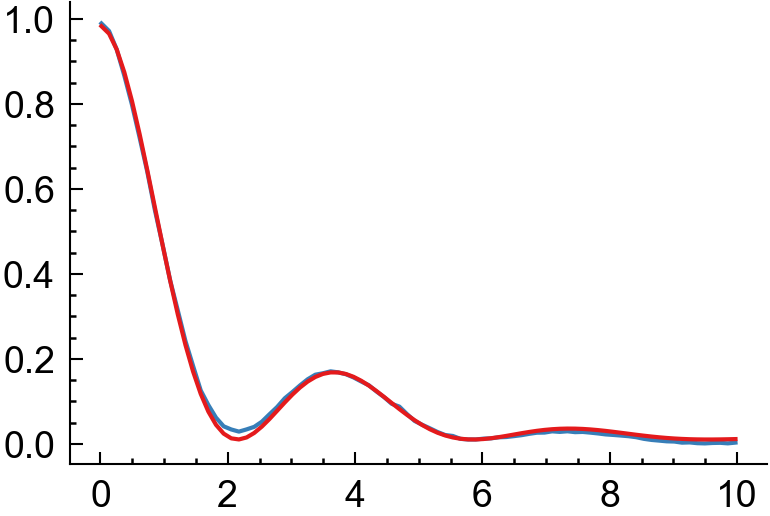

freq:0.1353129050650531,gamma: 0.4917432984119325, amp:1.0422523246100335, phase_deg: 75.01685413979915,offset: 0.010656065607371198,
J = 0.87230: ω = 0.85020 rad/μs


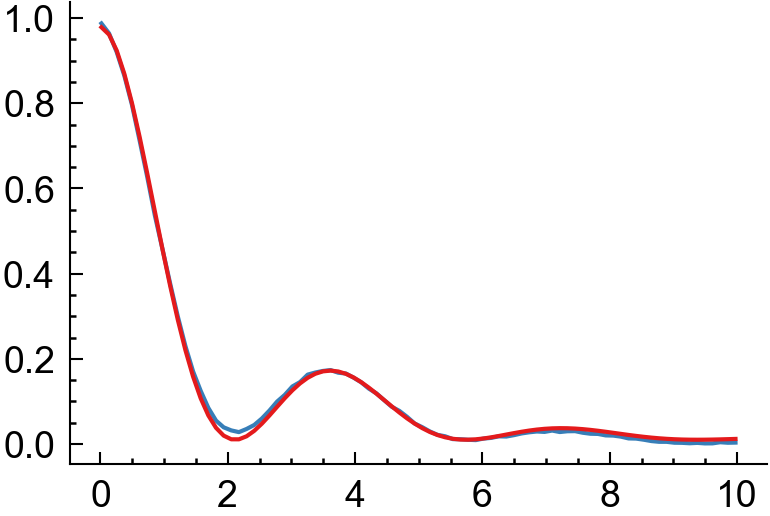

freq:0.13777849295578998,gamma: 0.4925106006623787, amp:1.038405050758533, phase_deg: 75.04695580618913,offset: 0.01003018869471265,
J = 0.88907: ω = 0.86569 rad/μs


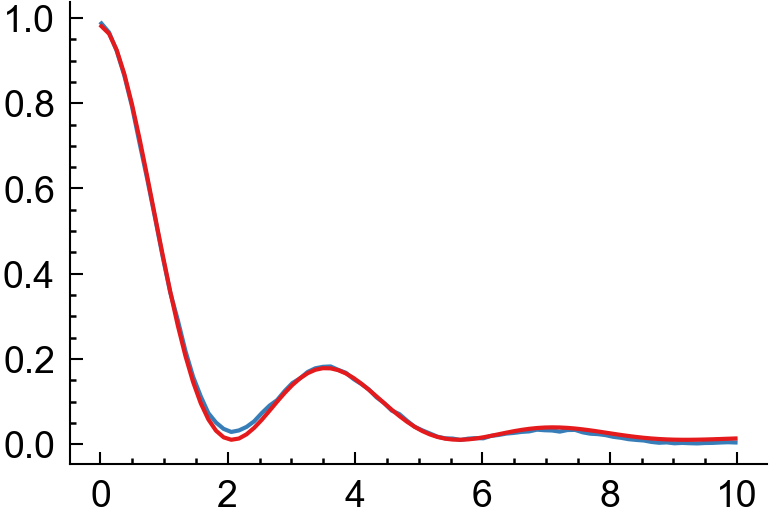

freq:0.14038290667891734,gamma: 0.4920708502824631, amp:1.03809420851271, phase_deg: 75.26477543609366,offset: 0.010347151381216054,
J = 0.90585: ω = 0.88205 rad/μs


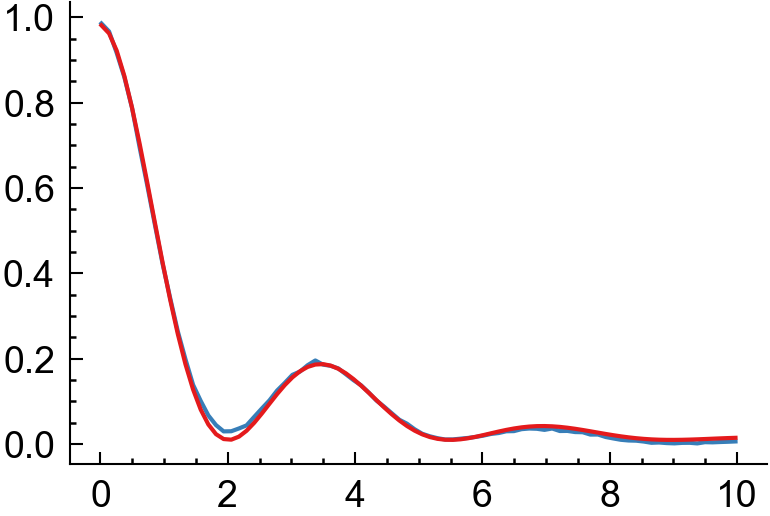

freq:0.14363740762069543,gamma: 0.4882618471652846, amp:1.0333059438305865, phase_deg: 75.87451507853221,offset: 0.010039372280111057,
J = 0.92262: ω = 0.90250 rad/μs


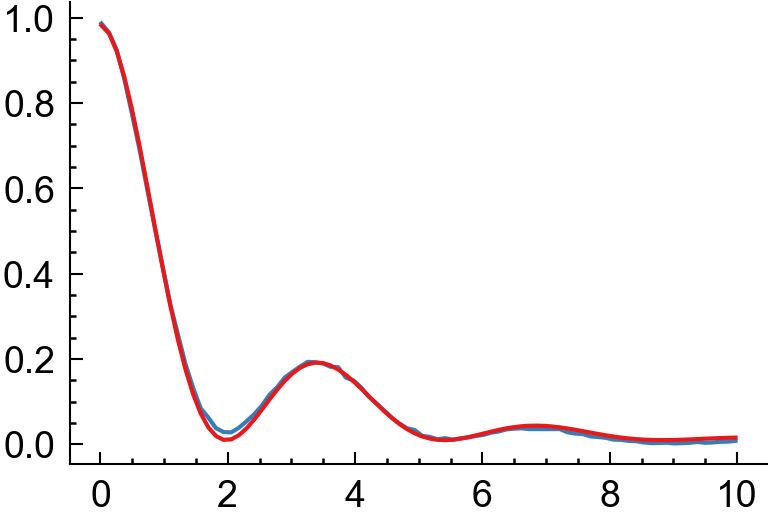

freq:0.1459867319367171,gamma: 0.4898615240329466, amp:1.0338222857565627, phase_deg: 75.97283002209863,offset: 0.009942877314176703,
J = 0.93940: ω = 0.91726 rad/μs


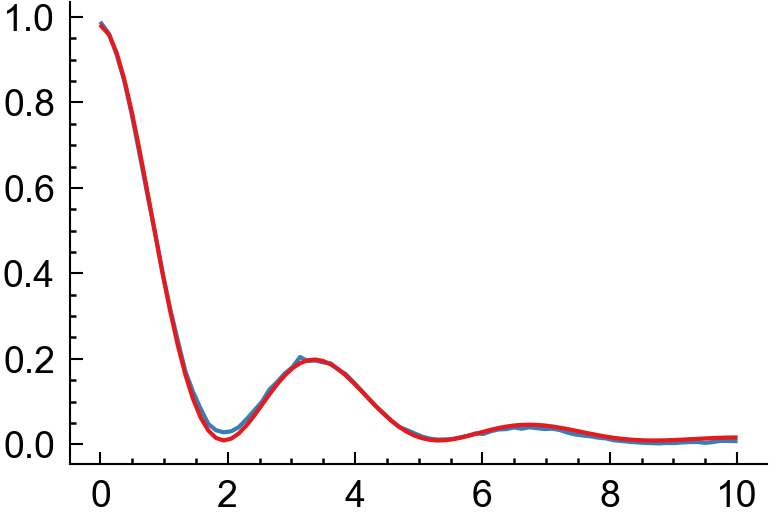

freq:0.14812635505153018,gamma: 0.48390102271882696, amp:1.0262639453072513, phase_deg: 76.45374528916862,offset: 0.009000052998275273,
J = 0.95617: ω = 0.93071 rad/μs


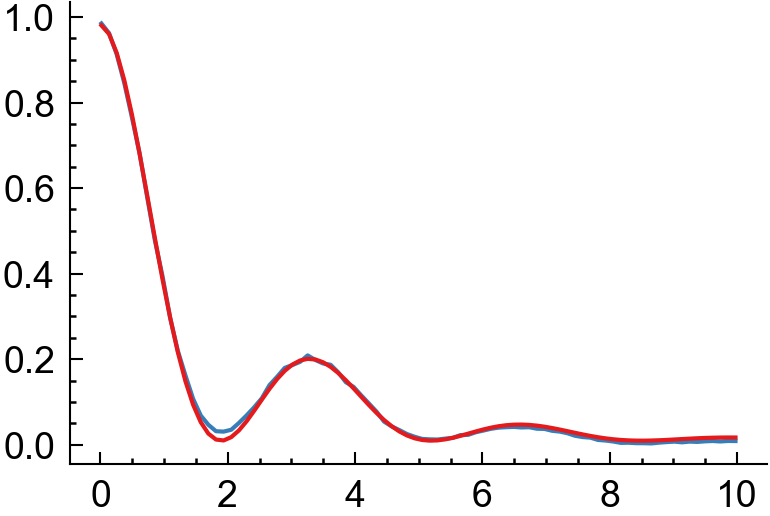

freq:0.1515563910302792,gamma: 0.492468400648413, amp:1.0286103118396515, phase_deg: 76.39641836929397,offset: 0.009421725494520486,
J = 0.97295: ω = 0.95226 rad/μs


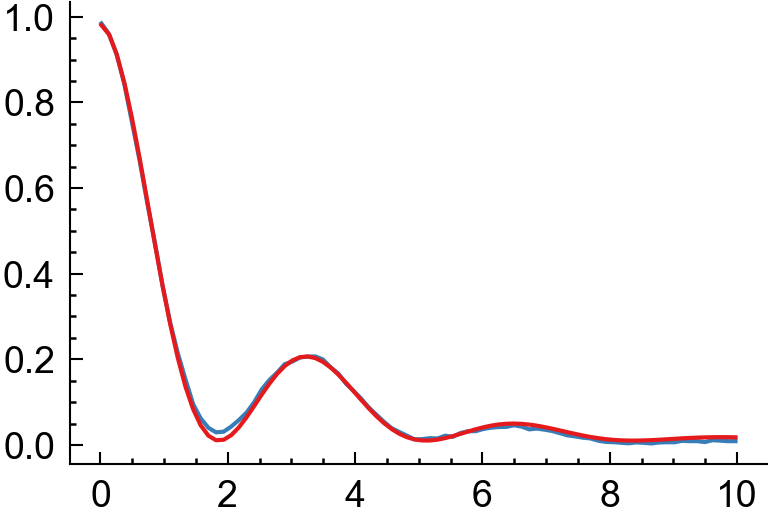

freq:0.15371491860770617,gamma: 0.4911529062907679, amp:1.0238364651236918, phase_deg: 76.88253570493083,offset: 0.01014566604172814,
J = 0.98972: ω = 0.96582 rad/μs


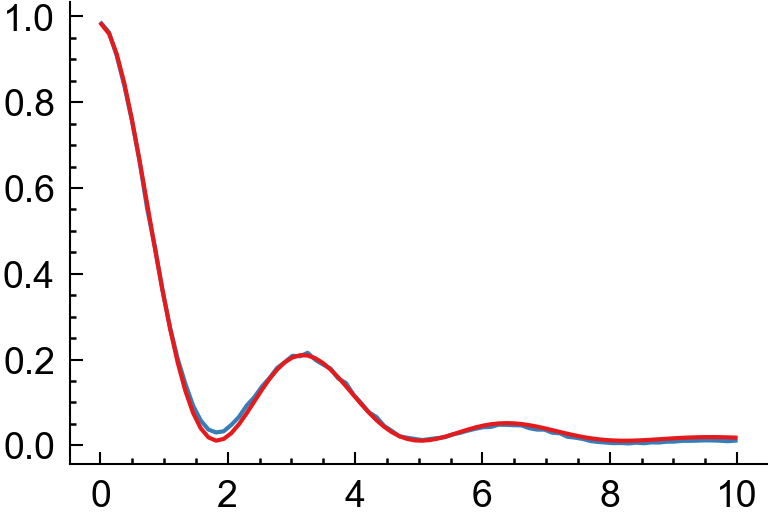

freq:0.1561786436677347,gamma: 0.49438411709211355, amp:1.0240317520510547, phase_deg: 76.99579320376517,offset: 0.010708287081450244,
J = 1.00650: ω = 0.98130 rad/μs


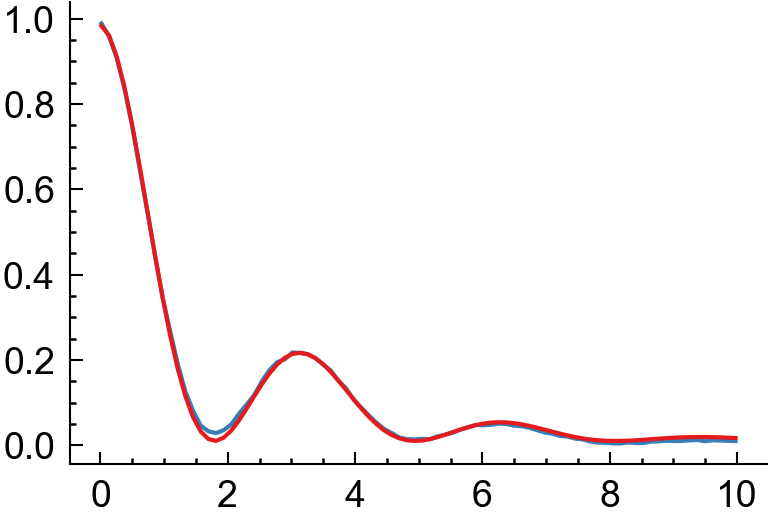

freq:0.1588279113289186,gamma: 0.4923018290997308, amp:1.023760788407612, phase_deg: 77.28072501226002,offset: 0.009988470469558636,
J = 1.02327: ω = 0.99795 rad/μs


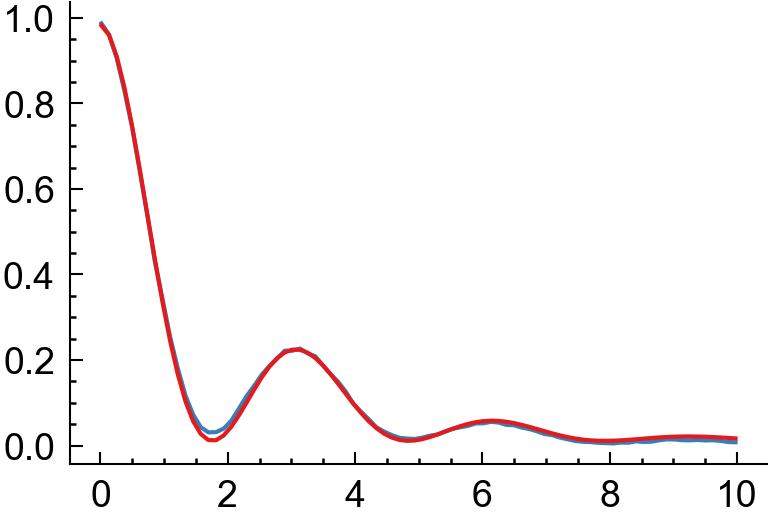

freq:0.1621589748673726,gamma: 0.49082646627659127, amp:1.021439735348213, phase_deg: 77.29300785847927,offset: 0.010903967073176934,
J = 1.04005: ω = 1.01887 rad/μs


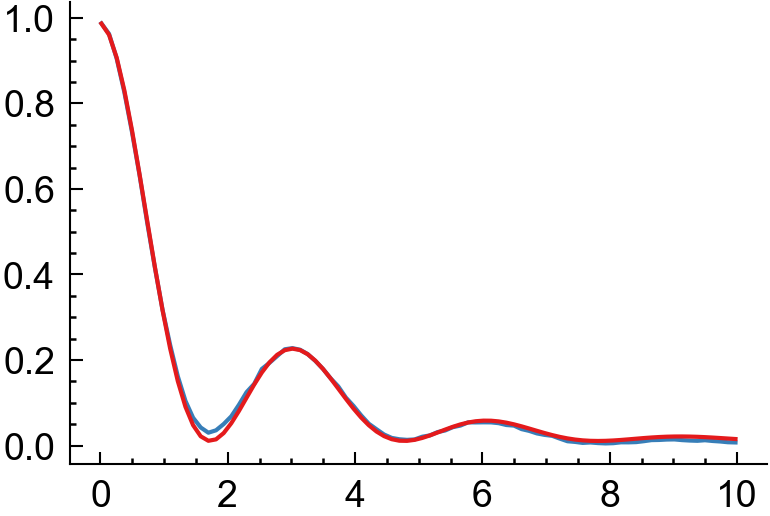

freq:0.16420758405659286,gamma: 0.4961904236653948, amp:1.020521119106322, phase_deg: 78.07813066312833,offset: 0.010726056908241023,
J = 1.05682: ω = 1.03175 rad/μs


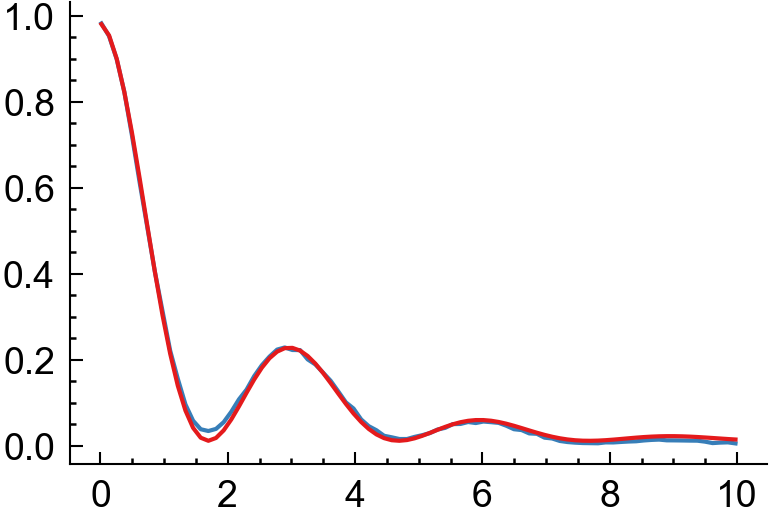

freq:0.16720685951066144,gamma: 0.501395336341606, amp:1.0138380161470208, phase_deg: 77.98586270535326,offset: 0.01145021267902811,
J = 1.07360: ω = 1.05059 rad/μs


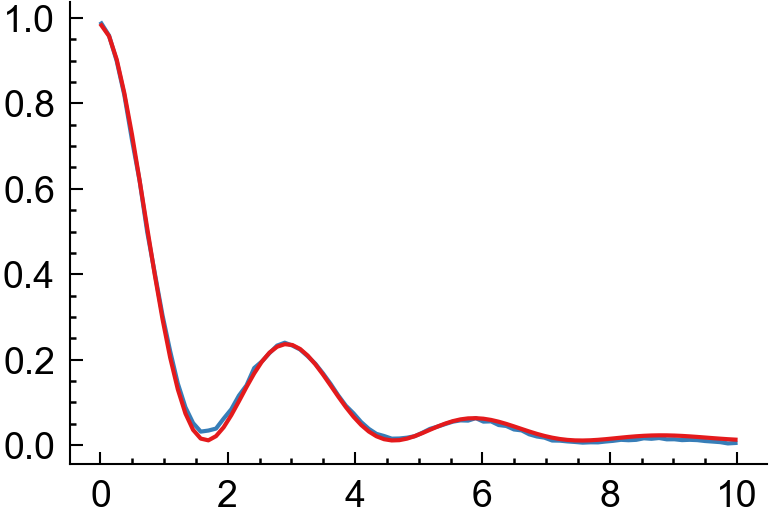

freq:0.16988951795122276,gamma: 0.49651721220178985, amp:1.0165628805506617, phase_deg: 77.96949595171323,offset: 0.01096290730300176,
J = 1.09037: ω = 1.06745 rad/μs


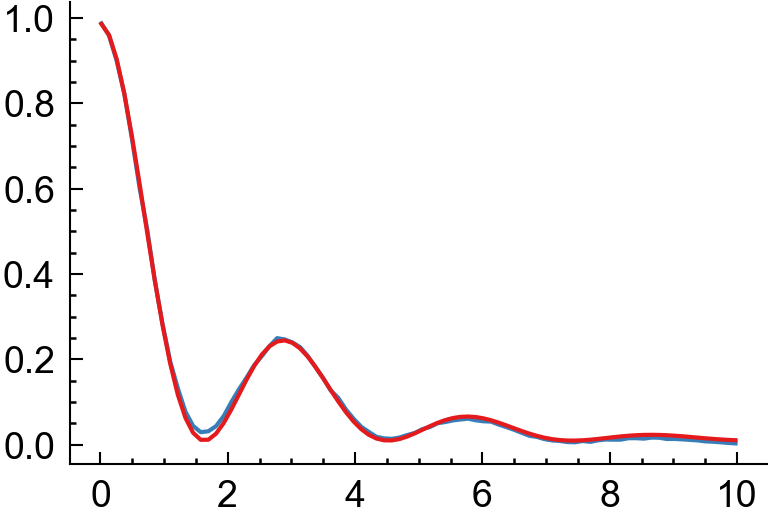

freq:0.17309144311973468,gamma: 0.4935922001723198, amp:1.0196213047779878, phase_deg: 78.21528390128942,offset: 0.009552352660386182,
J = 1.10715: ω = 1.08757 rad/μs


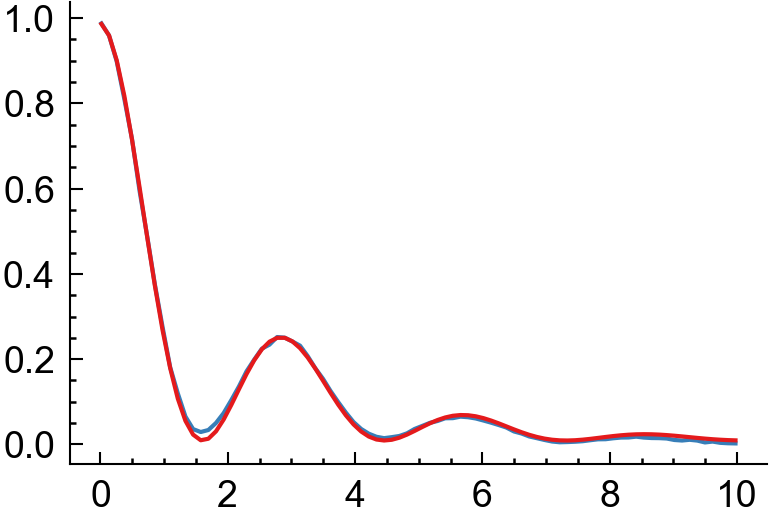

freq:0.17519036267496768,gamma: 0.48952304660876145, amp:1.0182511999347699, phase_deg: 78.58220596991757,offset: 0.009052648273853726,
J = 1.12392: ω = 1.10075 rad/μs


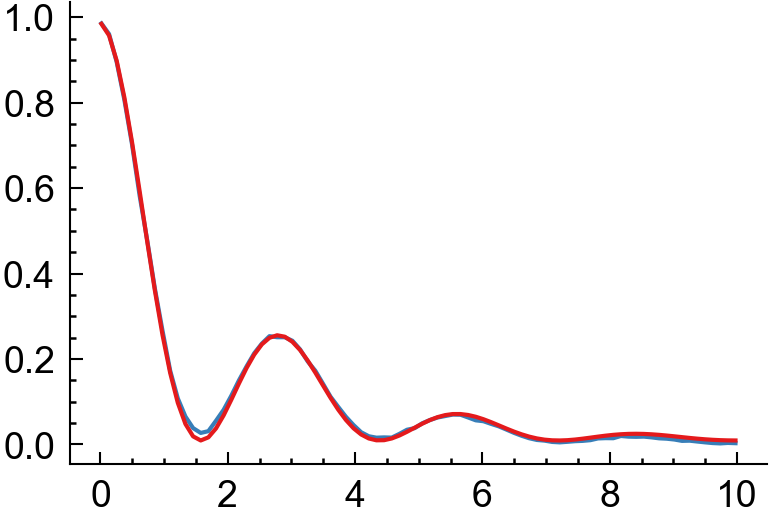

freq:0.17813369971189352,gamma: 0.49062083929082656, amp:1.0154300123597801, phase_deg: 78.62896349409012,offset: 0.0093965289516011,
J = 1.14070: ω = 1.11925 rad/μs


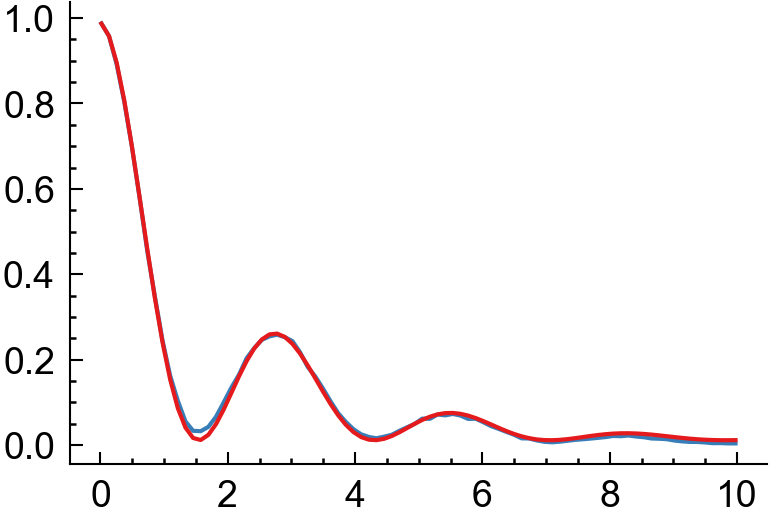

freq:0.1813188517781855,gamma: 0.49416595281703046, amp:1.0139961207217176, phase_deg: 79.04539290333544,offset: 0.010964413161460481,
J = 1.15747: ω = 1.13926 rad/μs


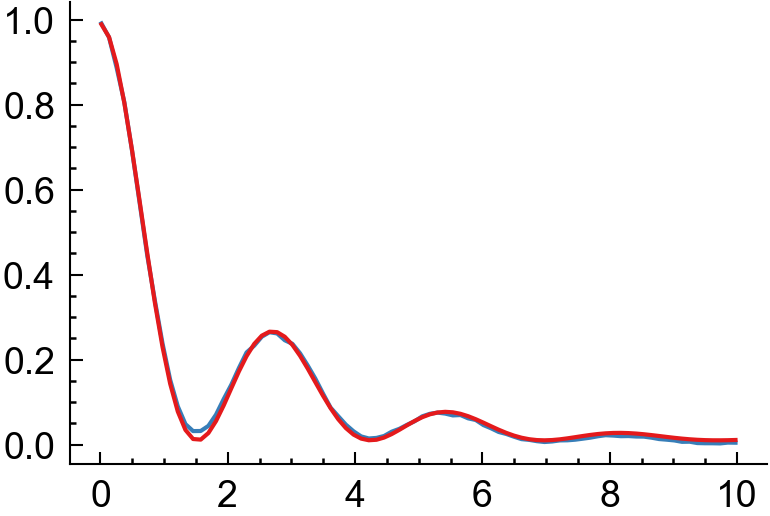

freq:0.1837014315946838,gamma: 0.4927473368510244, amp:1.0153732892230243, phase_deg: 79.19885512218804,offset: 0.010281835581441703,
J = 1.17425: ω = 1.15423 rad/μs


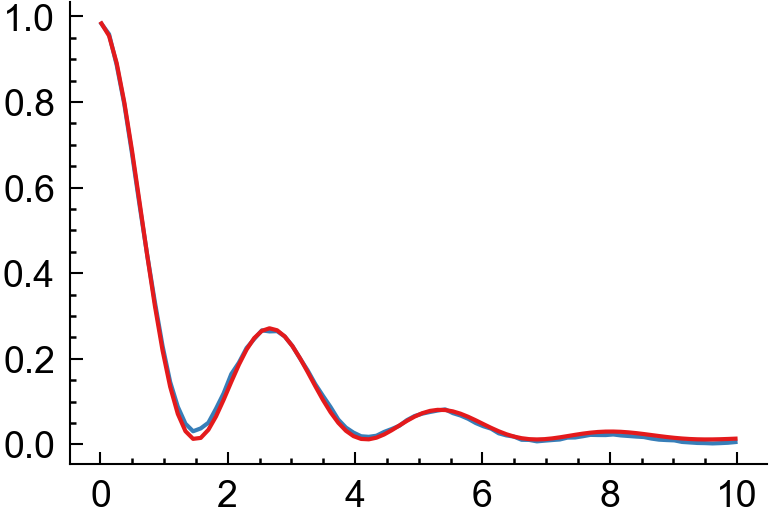

freq:0.18686502318560777,gamma: 0.4936847404096212, amp:1.0099222452895427, phase_deg: 79.02707311632346,offset: 0.011332602042774963,
J = 1.19102: ω = 1.17411 rad/μs


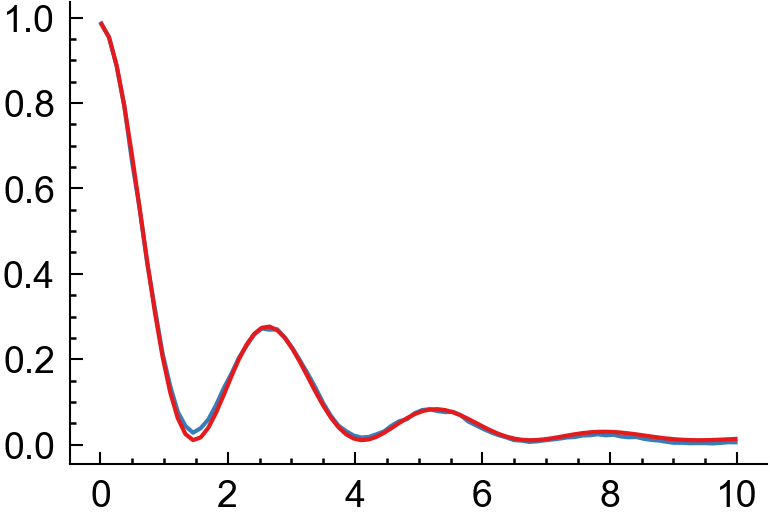

freq:0.18928858443967425,gamma: 0.4912103983194249, amp:1.0094522454606063, phase_deg: 79.43258423841769,offset: 0.01026300848329666,
J = 1.20780: ω = 1.18934 rad/μs


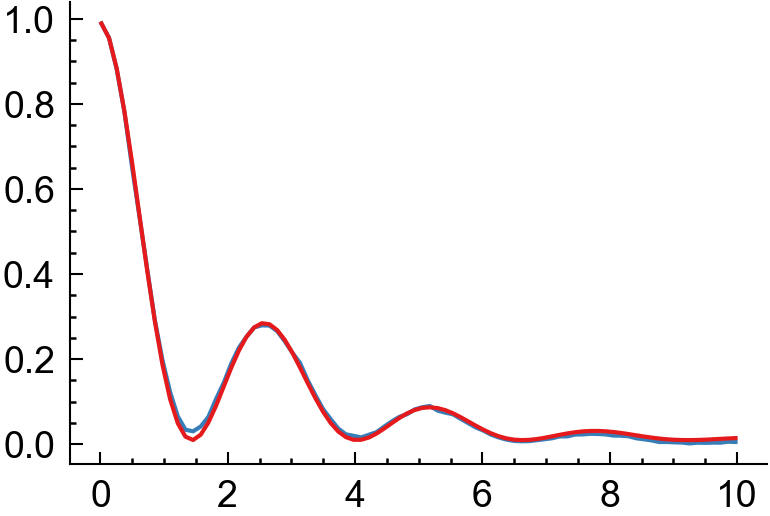

freq:0.19257948018491255,gamma: 0.48980530324300625, amp:1.0103649782514441, phase_deg: 80.2556543519939,offset: 0.009441480803744443,
J = 1.22457: ω = 1.21001 rad/μs


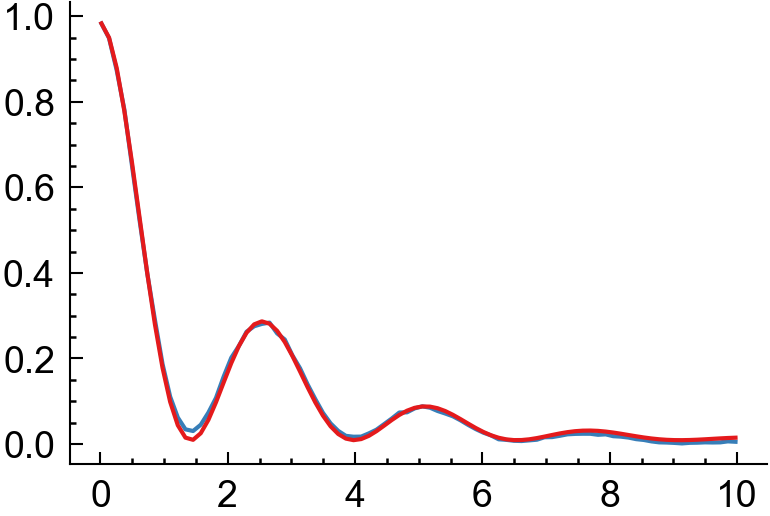

freq:0.19525802256021202,gamma: 0.4907461650652057, amp:1.0058742343457965, phase_deg: 79.98597192994086,offset: 0.009073531994825818,
J = 1.24135: ω = 1.22684 rad/μs


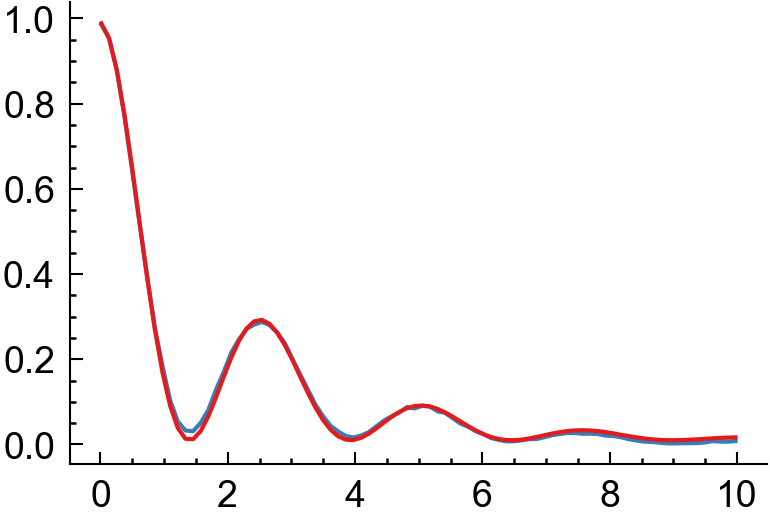

freq:0.19772013544166508,gamma: 0.4915378967676089, amp:1.0086843622147745, phase_deg: 80.28095946889631,offset: 0.009922401126641051,
J = 1.25812: ω = 1.24231 rad/μs


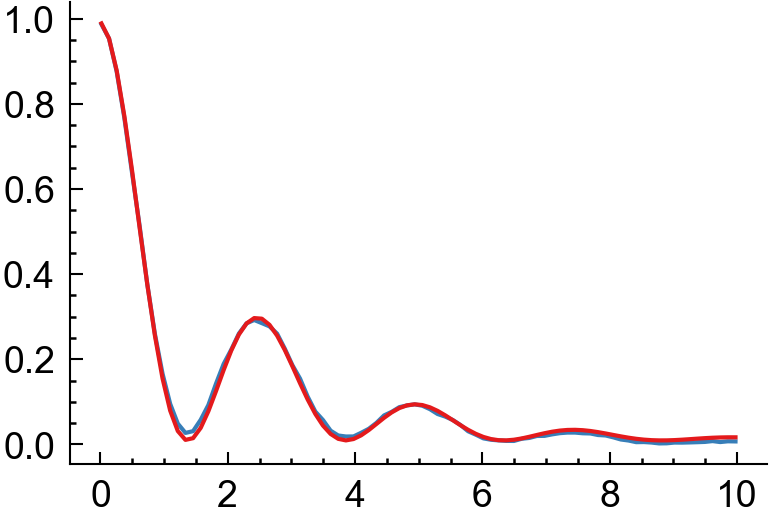

freq:0.20147702196629488,gamma: 0.49343023316299617, amp:1.0094928277248156, phase_deg: 80.30523173117037,offset: 0.009480606198173688,
J = 1.27490: ω = 1.26592 rad/μs


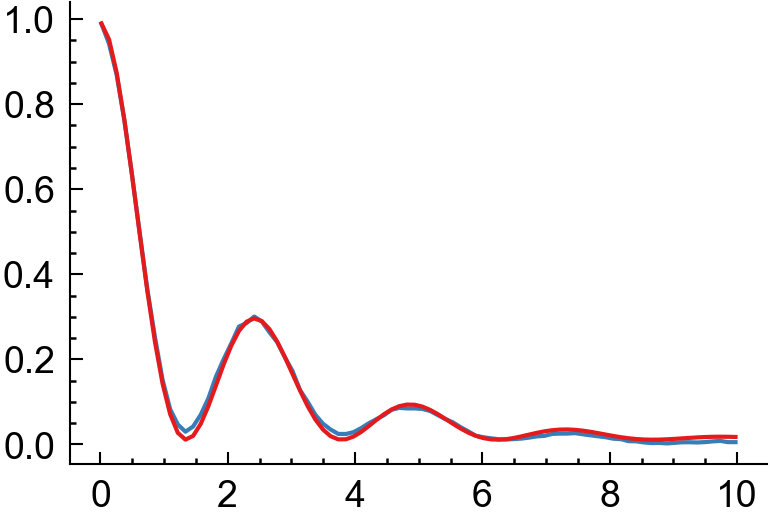

freq:0.2047479429658002,gamma: 0.5059253855214464, amp:1.0080723668179834, phase_deg: 80.4368667074291,offset: 0.011213881217176227,
J = 1.29167: ω = 1.28647 rad/μs


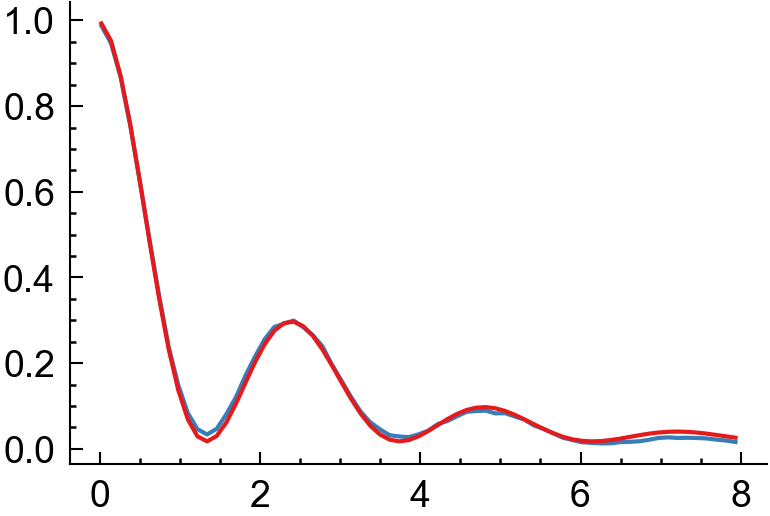

freq:0.20742005571917405,gamma: 0.5192348590847385, amp:1.0035124118065435, phase_deg: 80.71525624311758,offset: 0.017484975436575345,
J = 1.30845: ω = 1.30326 rad/μs


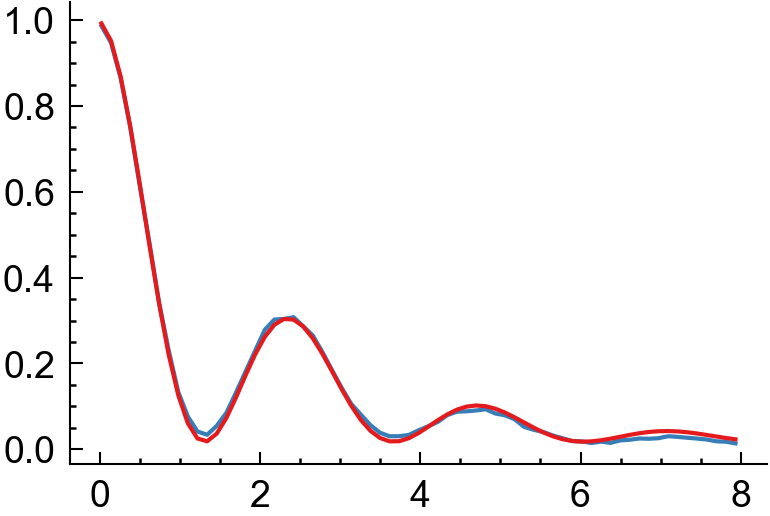

freq:0.211411651318983,gamma: 0.5177923592231102, amp:1.002822149151365, phase_deg: 80.675569293513,offset: 0.01762552625772745,
J = 1.32522: ω = 1.32834 rad/μs


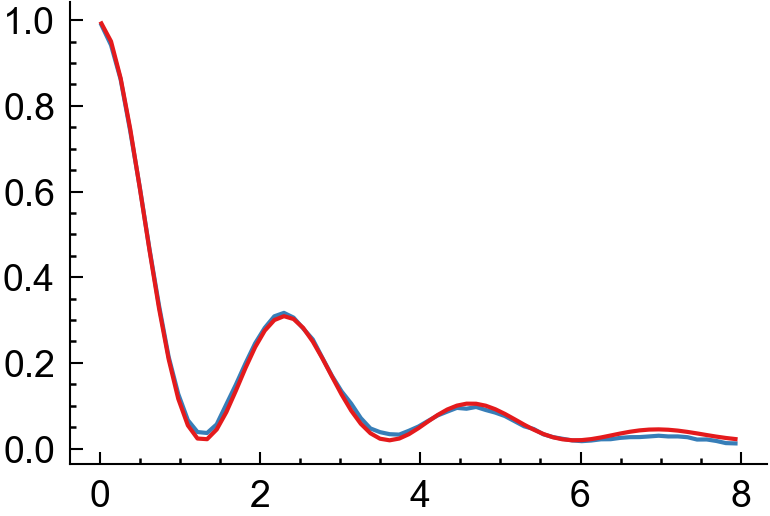

freq:0.2148382980801156,gamma: 0.5216898458427721, amp:1.0004113553599854, phase_deg: 80.8494821698067,offset: 0.019122234461671585,
J = 1.34200: ω = 1.34987 rad/μs


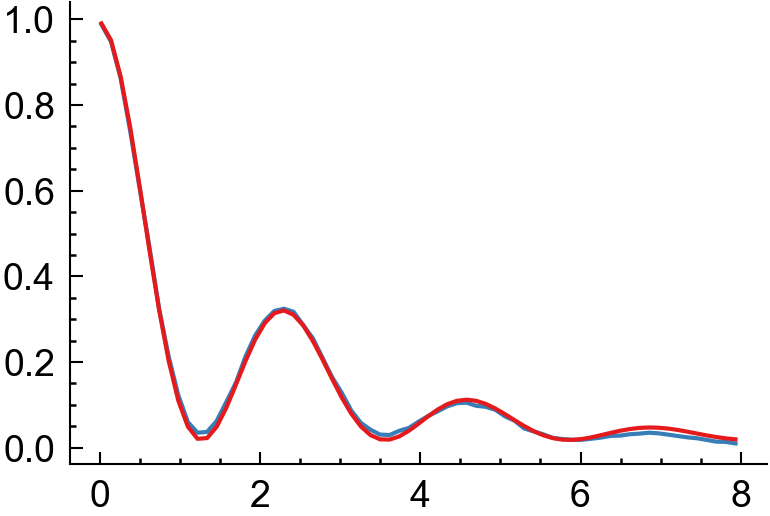

freq:0.21786484037487666,gamma: 0.5095788025199915, amp:1.0002243071168693, phase_deg: 80.56229992570523,offset: 0.018251652050909405,
J = 1.35877: ω = 1.36889 rad/μs


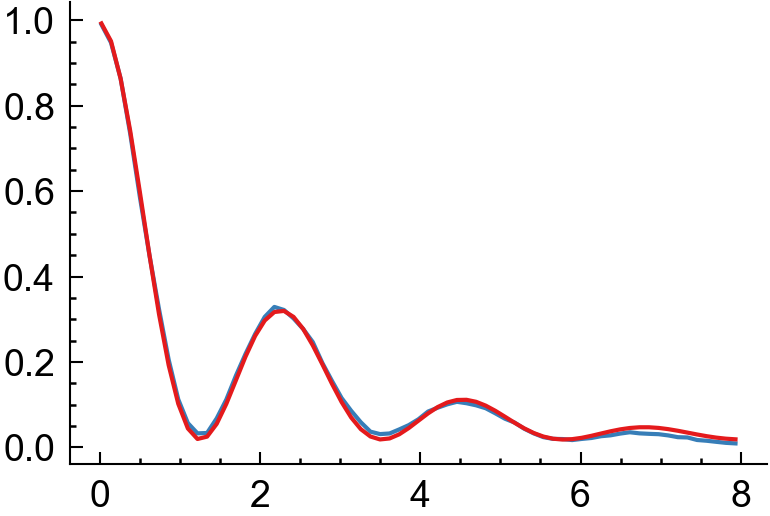

freq:0.22012874353765624,gamma: 0.5163627507795925, amp:1.0014524633669002, phase_deg: 80.82338423509447,offset: 0.018325478978628712,
J = 1.37555: ω = 1.38311 rad/μs


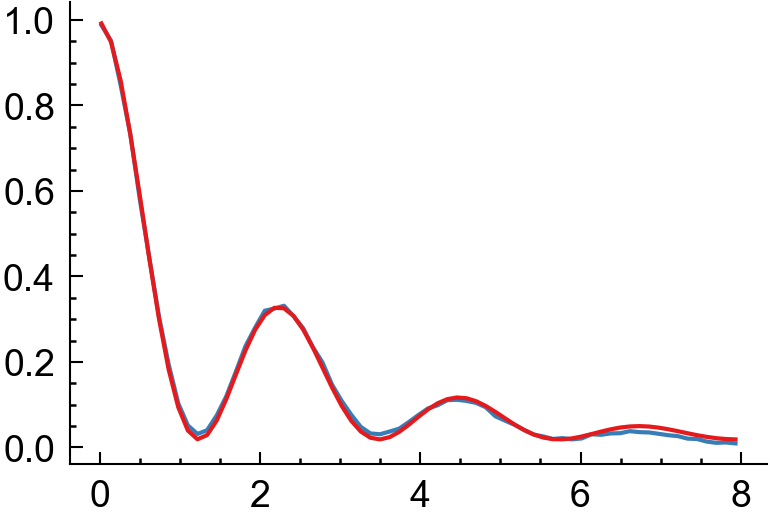

freq:0.22231092021153573,gamma: 0.5103410611232247, amp:0.9980938926967848, phase_deg: 81.24981605996155,offset: 0.018725170553506167,
J = 1.39232: ω = 1.39682 rad/μs


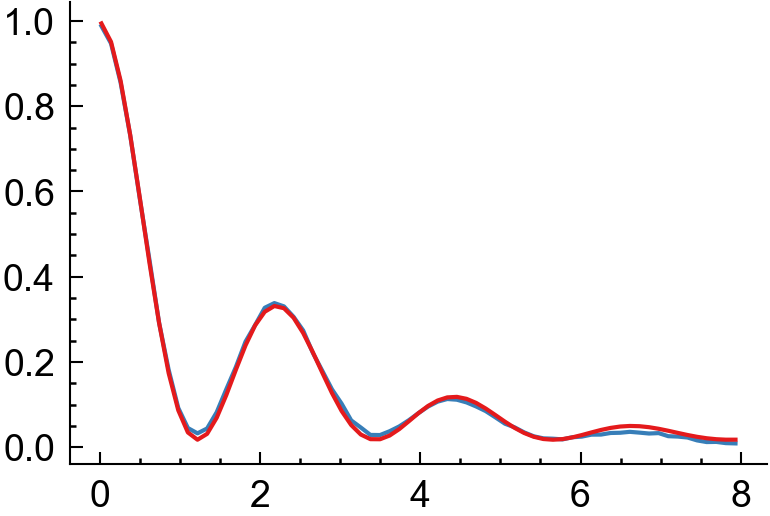

freq:0.22537885861387652,gamma: 0.5122851705757687, amp:1.0019671681041389, phase_deg: 81.10276312141053,offset: 0.017763493071684133,
J = 1.40910: ω = 1.41610 rad/μs


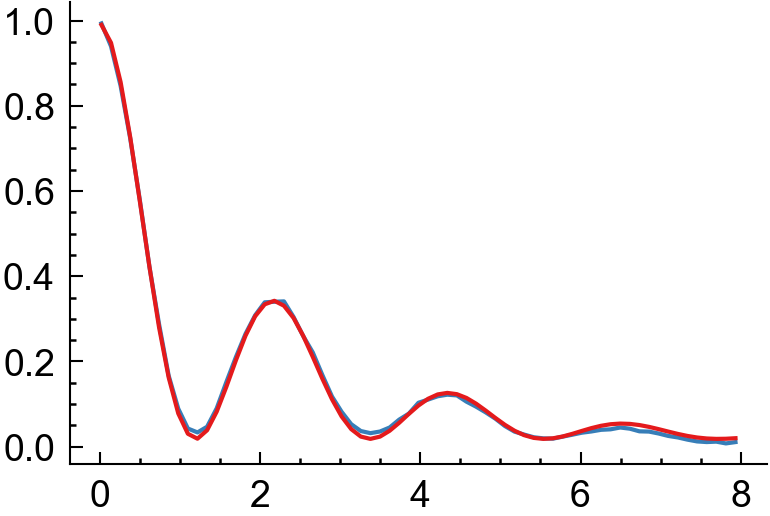

freq:0.22978291246683963,gamma: 0.5052433842860503, amp:0.9971574858071213, phase_deg: 81.01794775354817,offset: 0.01829504180812898,
J = 1.42587: ω = 1.44377 rad/μs


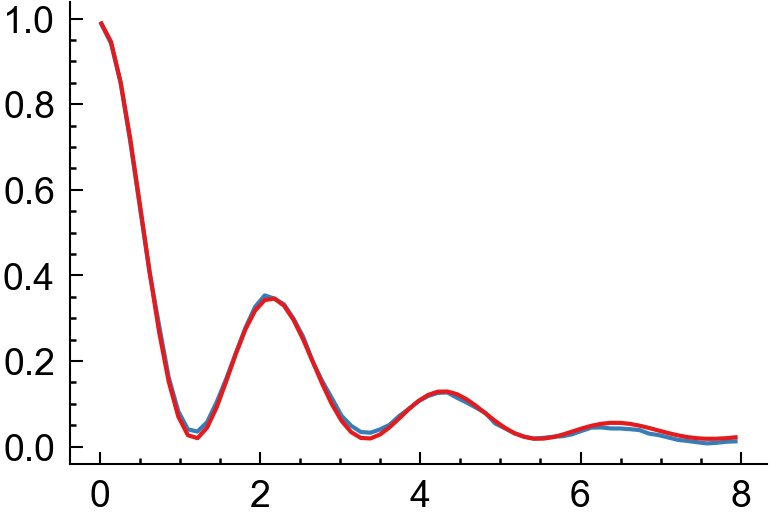

freq:0.23279509439184543,gamma: 0.5045456233753277, amp:0.9957073007066248, phase_deg: 81.16002392372997,offset: 0.018066065423943373,
J = 1.44265: ω = 1.46269 rad/μs


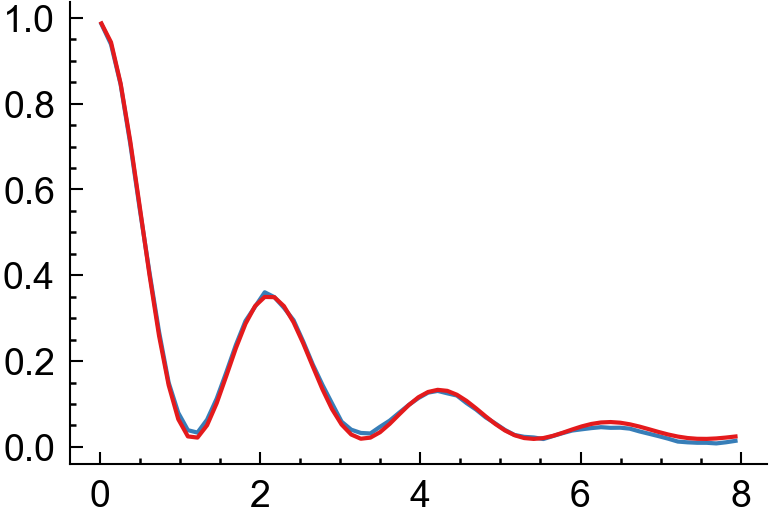

freq:0.23540205966397212,gamma: 0.5029353544462489, amp:0.9924850205514084, phase_deg: 81.31590139818518,offset: 0.0185116905691915,
J = 1.45942: ω = 1.47907 rad/μs


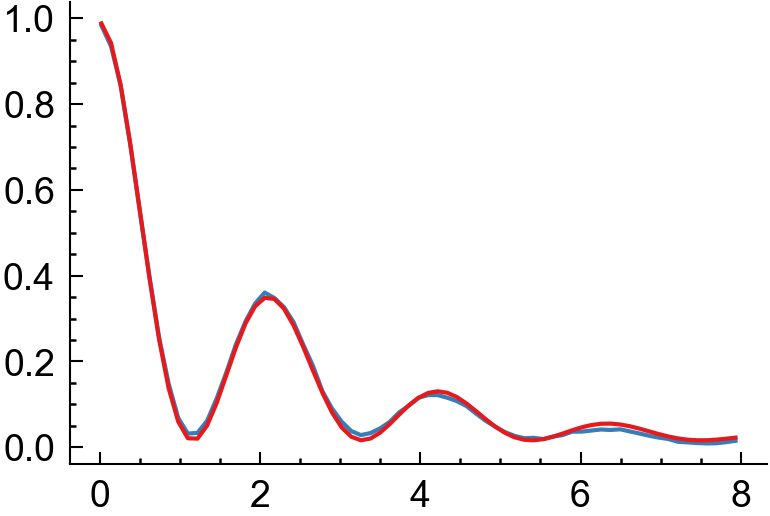

freq:0.23626767111681887,gamma: 0.5060929996305366, amp:0.9953255316990716, phase_deg: 81.49540312546877,offset: 0.01612659495387902,
J = 1.47620: ω = 1.48451 rad/μs


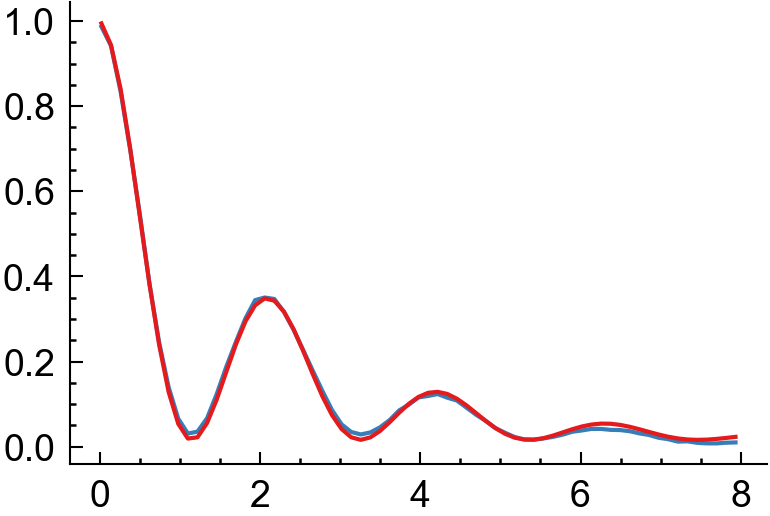

freq:0.23719885399006302,gamma: 0.5129104636623811, amp:0.9985797039017505, phase_deg: 82.233937803459,offset: 0.016187138914492544,
J = 1.49297: ω = 1.49036 rad/μs


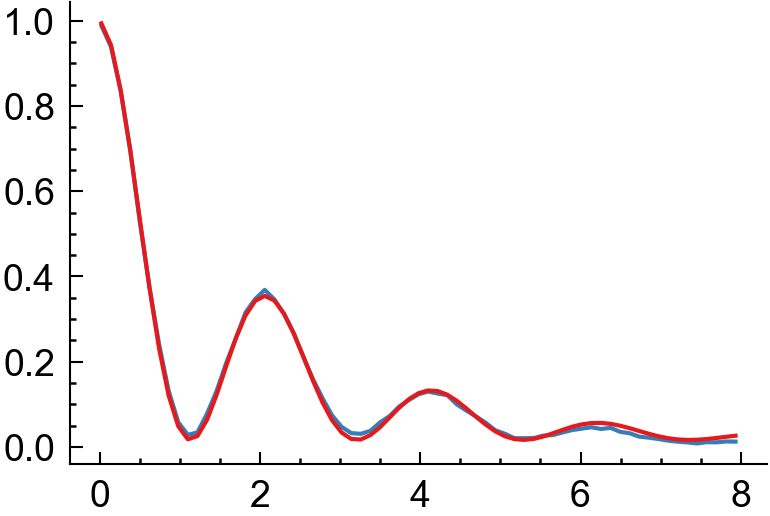

freq:0.2406701960682466,gamma: 0.5126467758290463, amp:0.9977494103169974, phase_deg: 82.14736497927377,offset: 0.016580113229229382,
J = 1.50975: ω = 1.51218 rad/μs


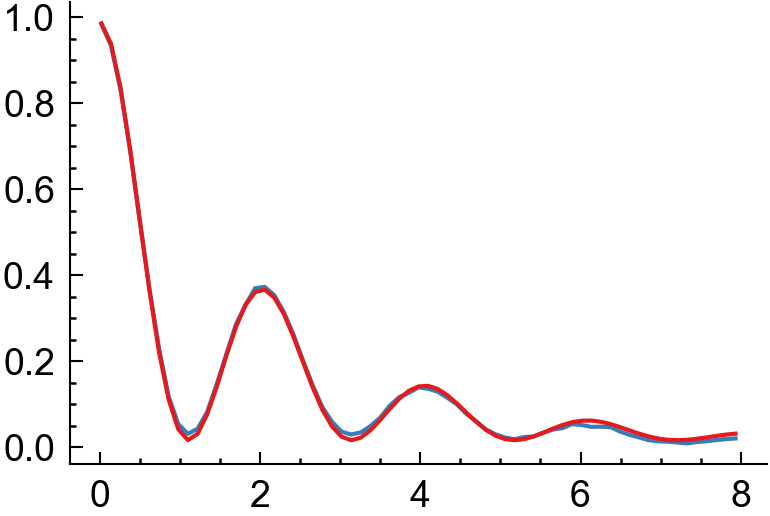

freq:0.24607319703888975,gamma: 0.5005714906459402, amp:0.9914438618256238, phase_deg: 81.68478515331894,offset: 0.016494154852235505,
J = 1.52652: ω = 1.54612 rad/μs


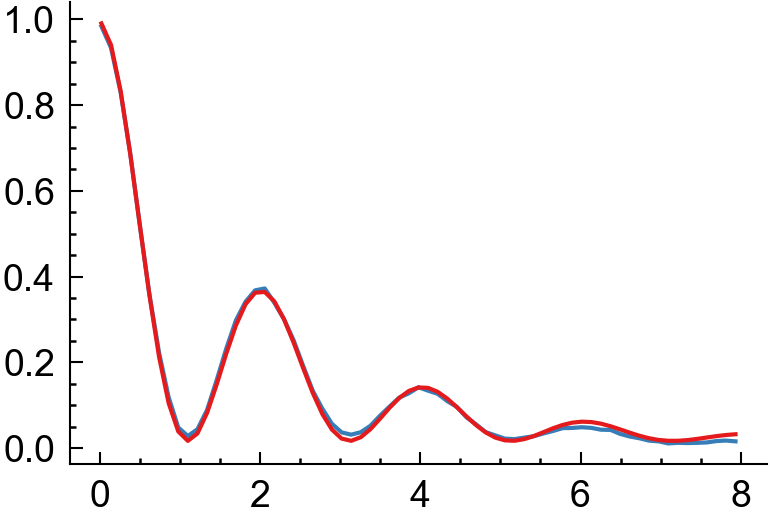

freq:0.24767463167300327,gamma: 0.5084045590284448, amp:0.9947174901325011, phase_deg: 81.98816000591628,offset: 0.016837568716984646,
J = 1.54330: ω = 1.55619 rad/μs


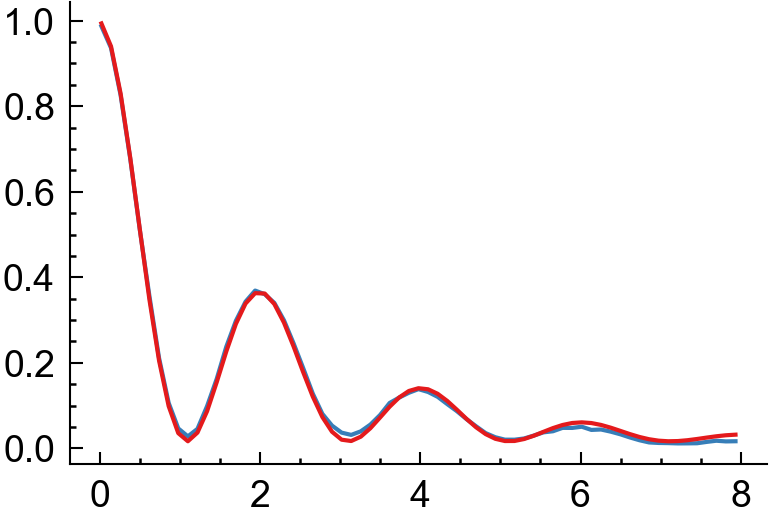

freq:0.24867036832060702,gamma: 0.513505673337839, amp:0.996608278388531, phase_deg: 82.40327593046857,offset: 0.01656607046905038,
J = 1.56007: ω = 1.56244 rad/μs


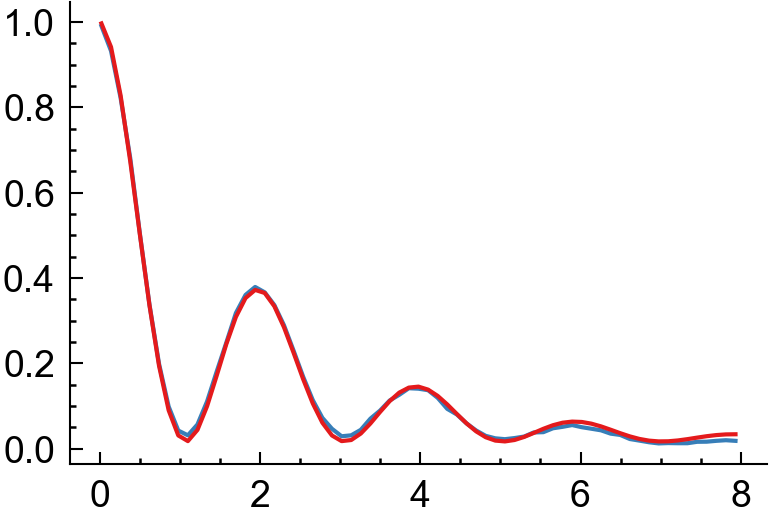

freq:0.25229960375521615,gamma: 0.5127210343109244, amp:0.9985690450304936, phase_deg: 82.57809098149838,offset: 0.016619783215443256,
J = 1.57685: ω = 1.58525 rad/μs


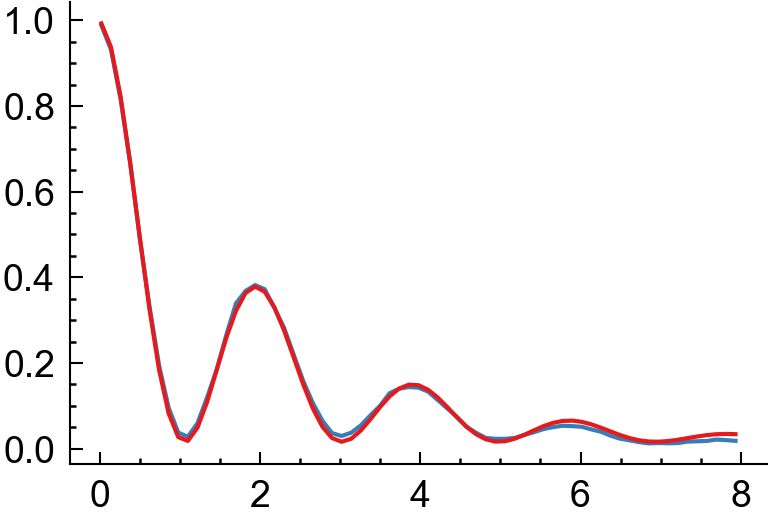

freq:0.2551479556422443,gamma: 0.5075679738948861, amp:0.9948499292016754, phase_deg: 82.68387794106938,offset: 0.01615961607413908,
J = 1.59362: ω = 1.60314 rad/μs


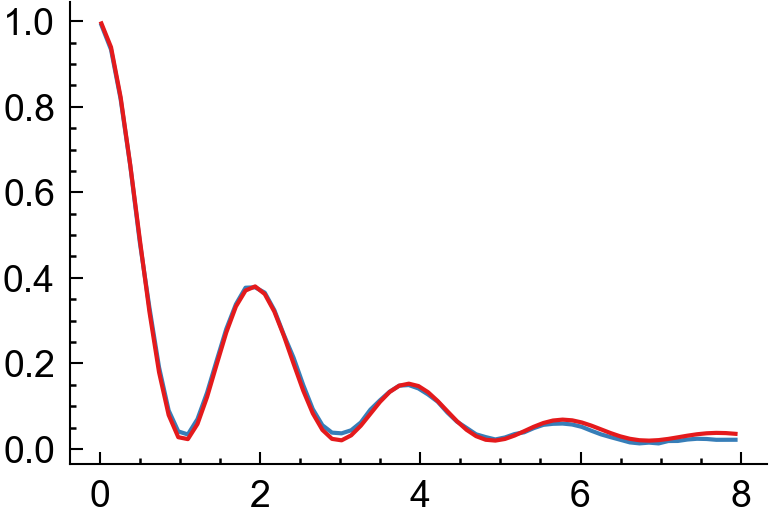

freq:0.25872096597010713,gamma: 0.5158242653040455, amp:0.9944534395975583, phase_deg: 82.45628197022438,offset: 0.019485070208467632,
J = 1.61040: ω = 1.62559 rad/μs


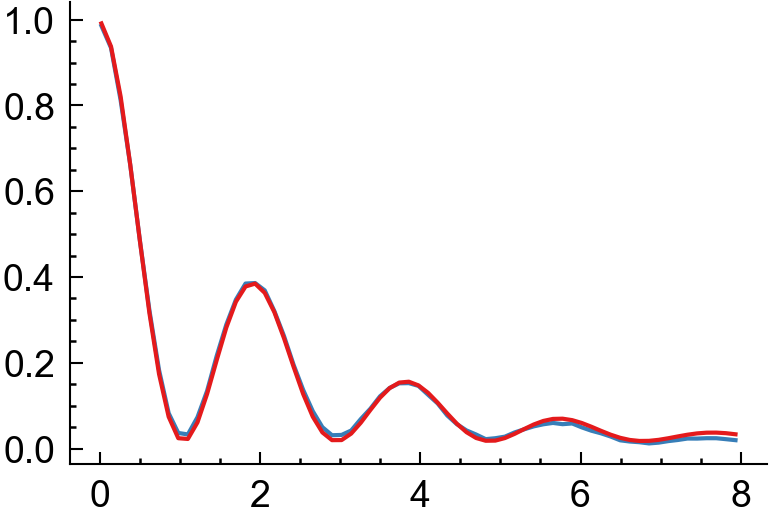

freq:0.2611757492447334,gamma: 0.5092049753411865, amp:0.9933509560430619, phase_deg: 82.24400761717436,offset: 0.017696472284578758,
J = 1.62717: ω = 1.64102 rad/μs


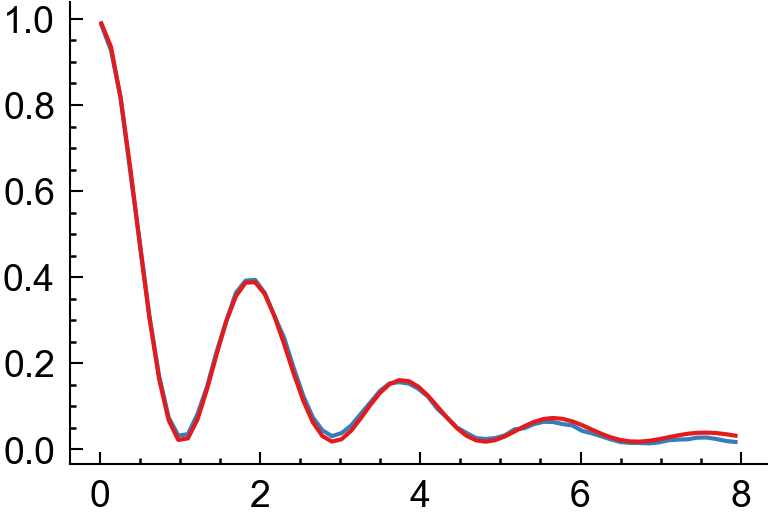

freq:0.2644134969748126,gamma: 0.506300801102706, amp:0.9906069996733128, phase_deg: 82.3639780035929,offset: 0.018063916740606874,
J = 1.64395: ω = 1.66136 rad/μs


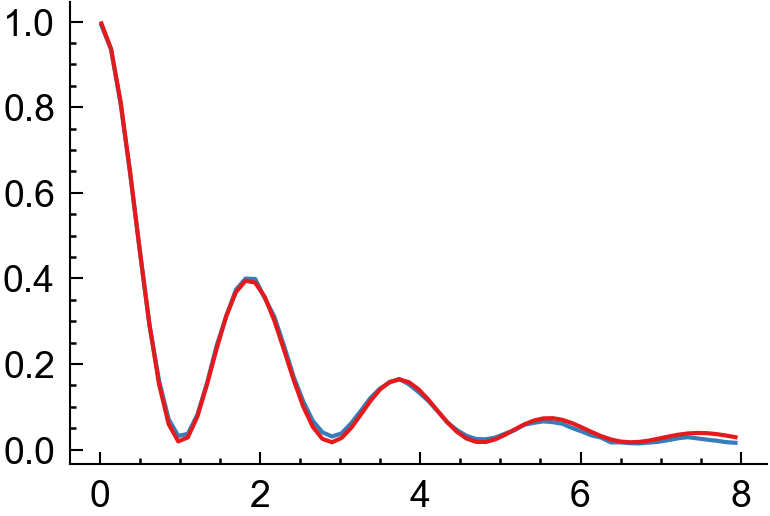

freq:0.26678365322680664,gamma: 0.50695722657806, amp:0.996254723772133, phase_deg: 82.92053795367619,offset: 0.016805434784303047,
J = 1.66072: ω = 1.67625 rad/μs


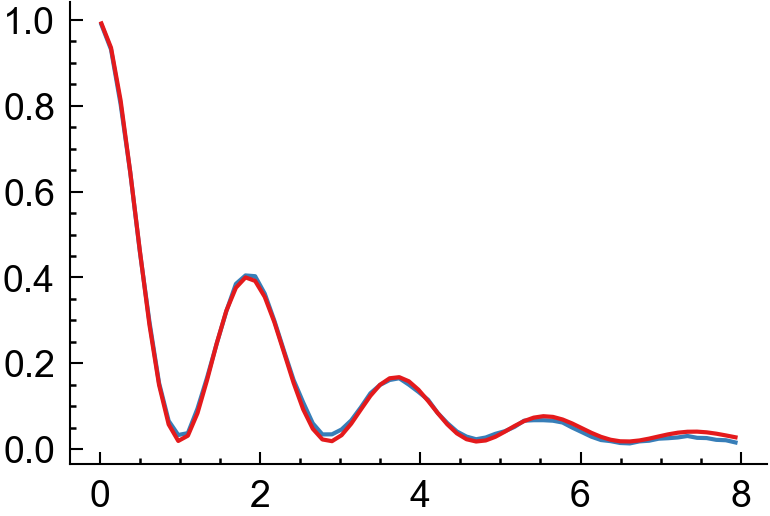

freq:0.26948787531793367,gamma: 0.5037653643290434, amp:0.9928714839639636, phase_deg: 82.5549347316002,offset: 0.01749571981842559,
J = 1.67750: ω = 1.69324 rad/μs


In [7]:

a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)

all_P_f = data["all_P_f"]       # list of arrays, each for an amplitude
amplitude = data["amplitude"]    # list/array of amplitude values
time_vals_ns = data["time_vals_ns"]

omega_values = temp_tools.sweep_J_curve_fit(all_P_f*10, amplitude, time_vals_ns)



C:\Users\quantum1\AppData\Local\Temp\ipykernel_2240\4264486102.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, A * np.sqrt(expr), 0.0)


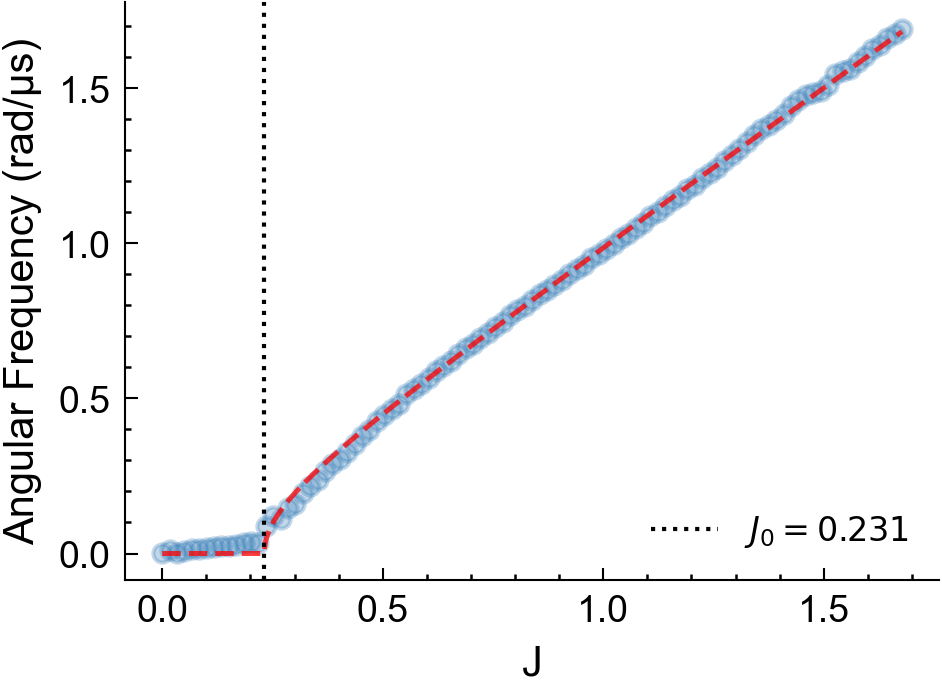

C:\Users\quantum1\AppData\Local\Temp\ipykernel_2240\4264486102.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, A * np.sqrt(expr), 0.0)


In [8]:
J_vals = np.array(sorted(omega_values.keys()))
omegas = np.array([omega_values[J] for J in J_vals])

#Apply cut: use only J < 1.3
mask = J_vals < 2
J_vals_cut = J_vals[mask]
omegas_cut = omegas[mask]

# Fit only in the valid region
def fit_func(J, A, J0):
    expr = J**2 - J0**2
    return np.where(expr >= 0, A * np.sqrt(expr), 0.0)

initial_J0 = 0.23
initial_A0 = 1

j_sweep_popt, j_sweep_pcov = curve_fit(
    fit_func,
    J_vals_cut,
    omegas_cut,
    p0=[initial_A0, initial_J0],
    nan_policy='omit'
)

# Plot
plt.figure()
J_fit = np.linspace(np.min(J_vals_cut), np.max(J_vals_cut), 1000)
plt.scatter(J_vals_cut, omegas_cut, alpha = 0.3, s = 19)
plt.plot(J_fit, fit_func(J_fit, *j_sweep_popt), lw = 1.2, c = 'red', ls = 'dashed', alpha = 0.75)
plt.axvline(j_sweep_popt[1], ls = 'dotted', c = 'black', label = rf"$J_0 = {np.round(j_sweep_popt[1],3)}$")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.legend()
savefig_tight('Images/j_sweep.pdf')
plt.show()


import pandas as pd

# Recompute J_fit and omega_fit for saving
J_fit = np.linspace(np.min(J_vals_cut), np.max(J_vals_cut), 1000)
omega_fit_vals = fit_func(J_fit, *j_sweep_popt)

# Build a DataFrame
df_save = pd.DataFrame({
    "J_vals": np.concatenate([J_vals_cut, [np.nan] * (len(J_fit) - len(J_vals_cut))]),
    "raw_omega_vals": np.concatenate([omegas_cut, [np.nan] * (len(J_fit) - len(omegas_cut))]),
    "omega_fit_vals": omega_fit_vals
})

# Save to CSV
df_save.to_csv("j_sweep_fit_data.csv", index=False)


In [9]:
J0_actual = j_sweep_popt[1]
j_0_past = 0.23
indices = np.where(np.abs(np.array(J_vals) - j_0_past) < 0.01)[0][0]
J_vals[indices]

0.23484931102856868

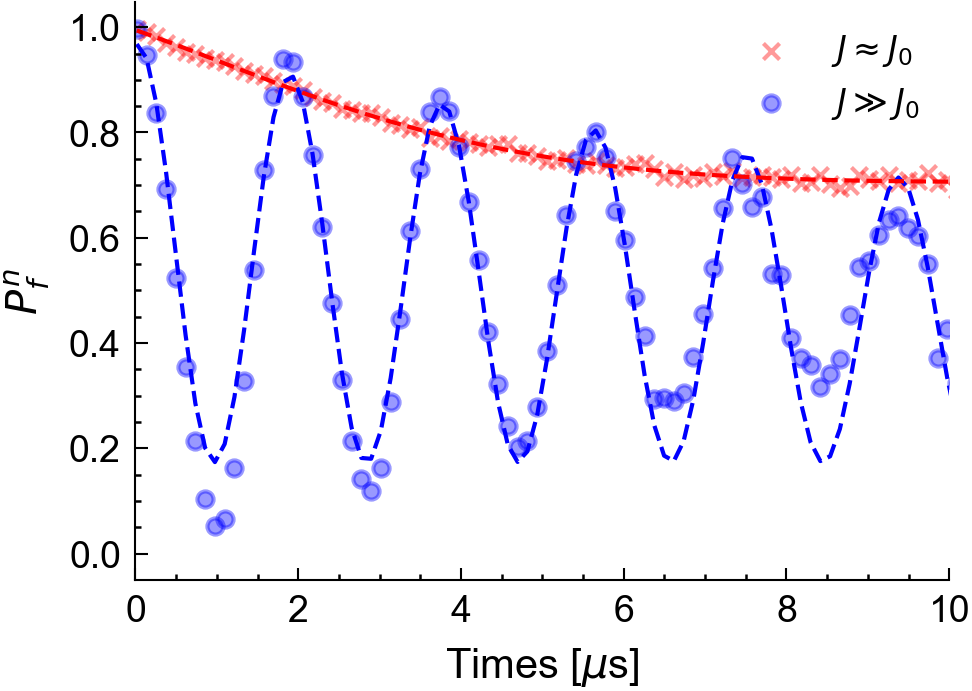

In [10]:
times = time_vals_ns/1000
j0_data = norm_P_f_matrix[indices]
bigJ_data = norm_P_f_matrix[-2]
smallJ_data = norm_P_f_matrix[2]
cutoff_index = 70
bigJpopt, bigJpcov = curve_fit(sine_square_decay, times[:cutoff_index], bigJ_data[:cutoff_index], p0 = [0.5,0.0279,1, 0, 0] )
j0popt, j0pcov = curve_fit(sine_square_decay, times[:cutoff_index], j0_data[:cutoff_index], p0 = [0.0625,0.0446,1, 0, 0] )

plt.figure()
plt.scatter(times, j0_data, marker = 'x', s = 15, c = 'red', label = r'$ J \approx J_0$', alpha = 0.4)
plt.scatter(times, bigJ_data, marker = 'o',s = 15, c = 'blue',  label = r"$J \gg J_0$", alpha = 0.4)
plt.plot(times, sine_square_decay(times, *bigJpopt), c = 'blue', ls = 'dashed')
plt.plot(times, sine_square_decay(times, *j0popt), c = 'red', ls = 'dashed')
plt.xlabel(r"Times [$\mu$s]")
plt.ylabel(r"$P^n_f$")
plt.xlim(0,10)
plt.legend()
savefig_tight('Images/linecutsJsweep.pdf')
plt.show()


# Evaluate fit curves
j0_fit = sine_square_decay(times, *j0popt)
bigJ_fit = sine_square_decay(times, *bigJpopt)

# Assemble into DataFrame
df_linecuts = pd.DataFrame({
    "time_us": times,
    "j0_data": j0_data,
    "bigJ_data": bigJ_data,
    "j0_fit": j0_fit,
    "bigJ_fit": bigJ_fit
})

# Save to CSV
df_linecuts.to_csv("linecutsJsweep.csv", index=False)


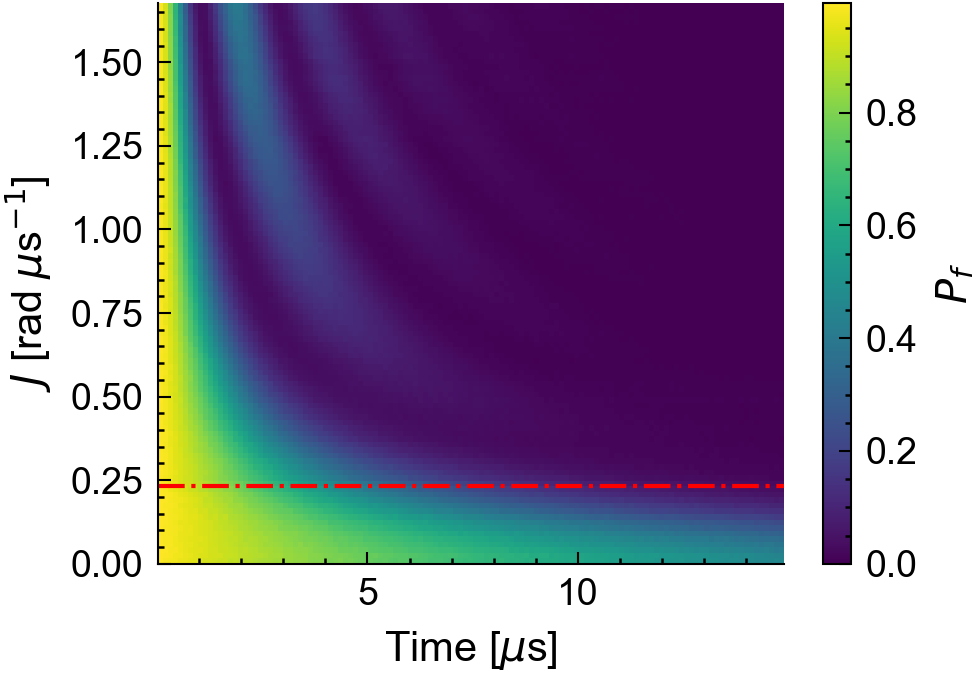

In [11]:
plt.figure()
plt.imshow(all_P_f, aspect='auto', origin='lower',
           extent=[time_vals_ns[0]/1000, time_vals_ns[-1]/1000, a_to_J*amp_vals[0], a_to_J*amp_vals[-1]],
           cmap='viridis')
plt.colorbar(label='$P_f$')
plt.xlabel(r"Time [$\mu$s]")
plt.ylabel(r"$J$ [rad $\mu$s$^{-1}$]")
plt.axhline(J0_actual, ls = 'dashdot', c = 'red')
plt.tight_layout()
savefig_tight('Images/j_im_not_normalized.pdf')
plt.show()

# Convert axes
time_us = time_vals_ns / 1000
J_vals = a_to_J * amp_vals

# Build DataFrame
df_implot = pd.DataFrame(
    all_P_f,
    index=J_vals,
    columns=time_us
)
df_implot.index.name = "J [rad/μs]"
df_implot.columns.name = "Time [μs]"

# Save to CSV
df_implot.to_csv("j_im_not_normalized.csv")


In [12]:
J_drive=temp_tools.J_EP
initial_state="f"
omega= 1.34e5 
freq_kHz = omega/(2 * np.pi * 1e3)
exp_x, exp_y, exp_z, rho_ef,rho,P_g_z,P_e_z,P_f_z,P_e_y,P_f_y,P_e_x,P_f_x = temp_tools.rabi_tomo(J_drive, omega, initial_state)
print(f'Detuning of {freq_kHz}kHz')

Detuning of 21.326762374313976kHz


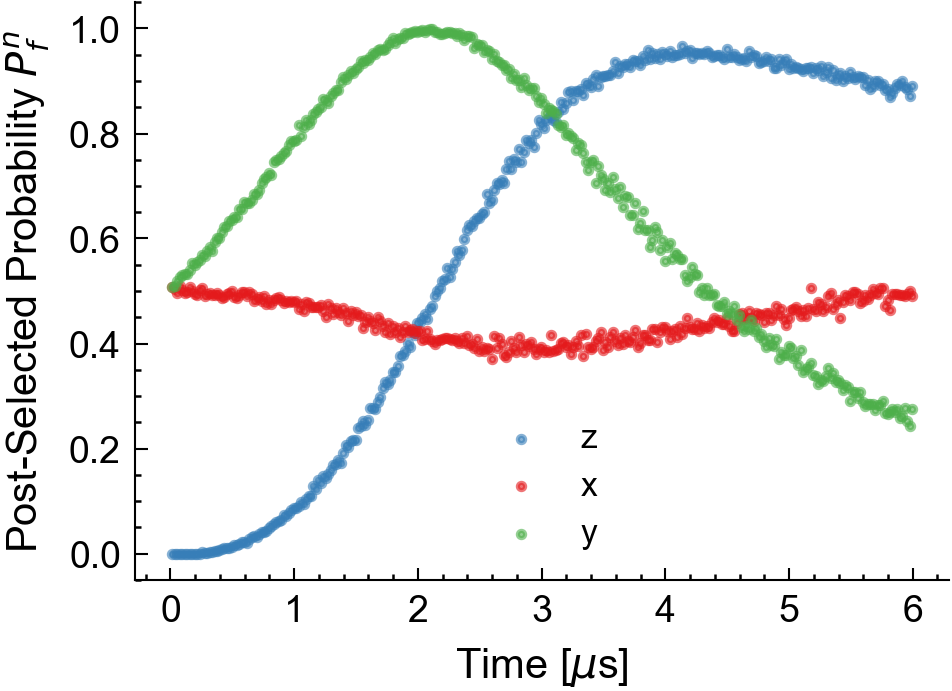

In [13]:
ep_tomo = data_dict['e']['0.0007193']['scaled']
# plt.plot(temp_tools.time*1e6, P_f_z/(P_f_z + P_e_z), 'C0'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6, P_f_x/(P_f_x + P_e_x), 'C1'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6,  P_f_y/(P_f_y + P_e_y), 'C2'  , ls = 'dashdot')

plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_z']/(ep_tomo['P_f_z'] + ep_tomo['P_e_z']), label = 'z', s = 3, alpha = 0.6)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_y']/(ep_tomo['P_f_y'] + ep_tomo['P_e_y']), label = 'x', s = 3, alpha = 0.6)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_x']/(ep_tomo['P_f_x'] + ep_tomo['P_e_x']), label = 'y', s= 3, alpha = 0.6)
plt.legend()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel(r'Post-Selected Probability $P^n_f$')
savefig_tight('Images/tomographyatEP.pdf')

In [14]:
ep_tomo.to_csv('ep_tomo.csv')

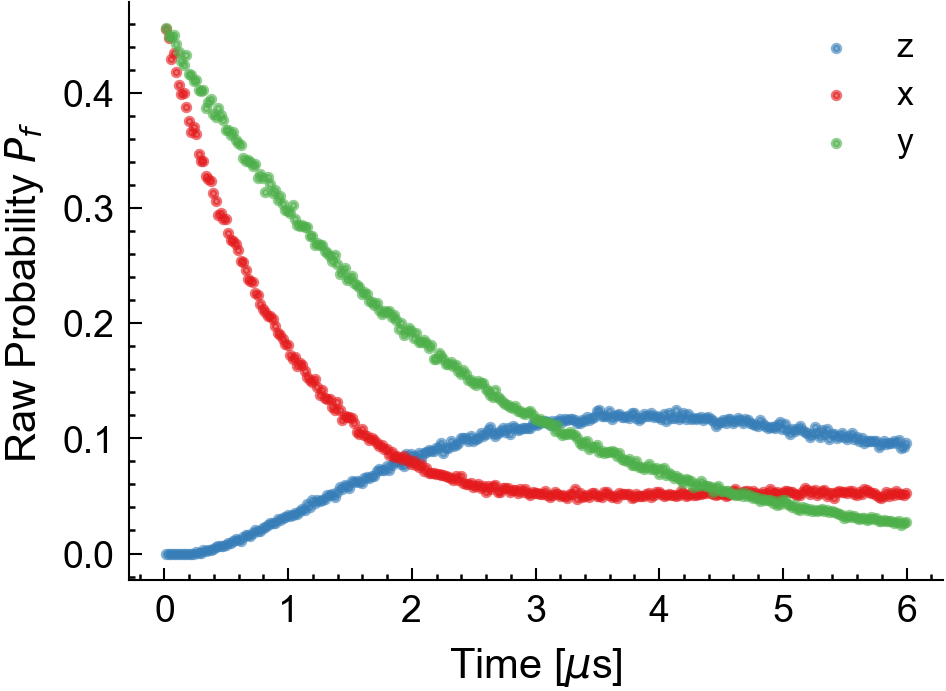

In [15]:
ep_tomo = data_dict['e']['0.0007193']['scaled']
# plt.plot(temp_tools.time*1e6, P_f_z/(P_f_z + P_e_z), 'C0'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6, P_f_x/(P_f_x + P_e_x), 'C1'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6,  P_f_y/(P_f_y + P_e_y), 'C2'  , ls = 'dashdot')

plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_z'], label = 'z', s = 3, alpha = 0.6)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_y'], label = 'x', s = 3, alpha = 0.6)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_x'], label = 'y', s= 3, alpha = 0.6)
plt.legend()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel(r'Raw Probability $P_f$')
savefig_tight('Images/full_tomographyatEP.pdf')

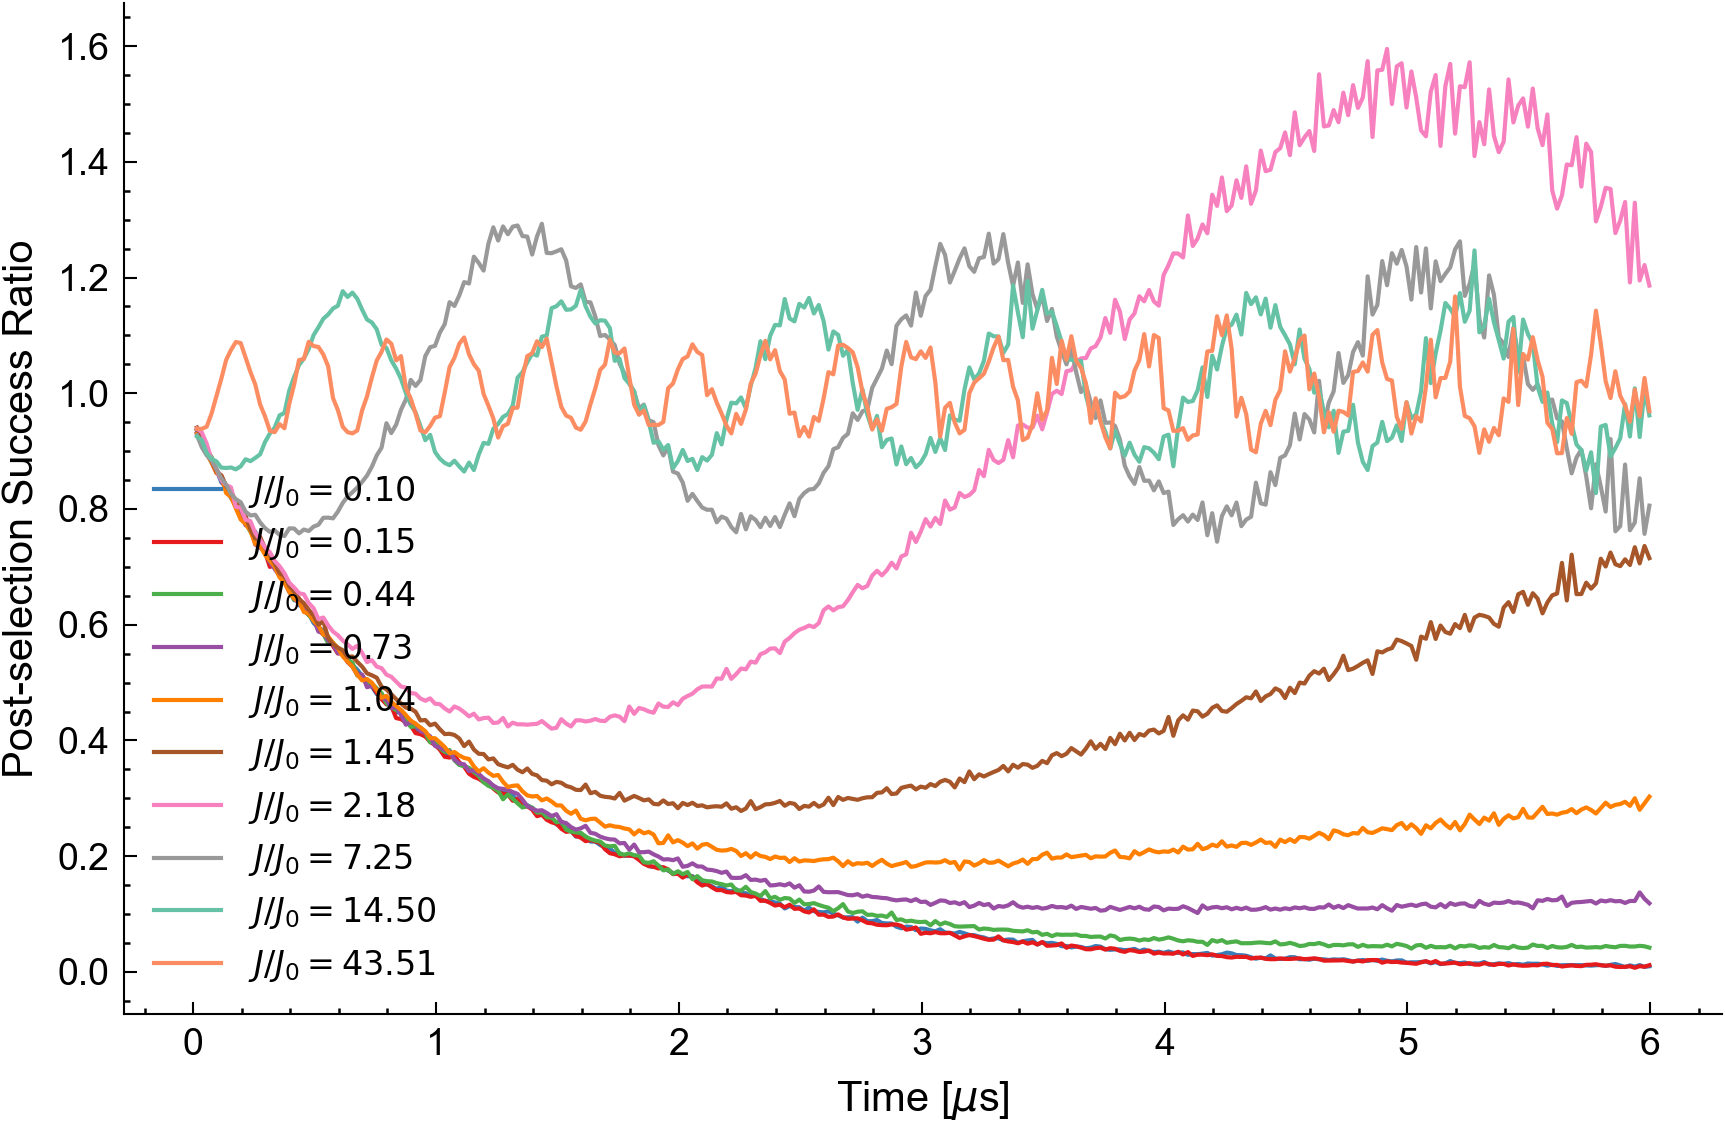

In [16]:
 # Prepare amplitude keys and values
amp_keys = amplitudes
amp_vals = np.array([float(a) for a in amp_keys])
J_vals_new = a_to_J * amp_vals

# Plot
plt.figure(figsize = (6,4))

# Line plots: each line is 1 - P_g_z vs time
for a_str, J in zip(amp_keys, J_vals_new):
    df = data_dict['f'][a_str]['scaled']
    de = data_dict['e'][a_str]['scaled']
    times_us = df['time'].values / 1000  # convert ns to µs
    post_sel_success_f = 1 - df['P_g_z'].values
    post_sel_success_e = 1 - de['P_g_z']
    plt.plot(times_us, post_sel_success_e/post_sel_success_f, label=fr"$J/J_0 = {J/j_sweep_popt[1]:.2f}$")

# Now master_df has time_us and one column per J value

# Labels and legend
plt.xlabel(r"Time [$\mu$s]")
plt.ylabel("Post-selection Success Ratio")
plt.legend(loc='lower left')
plt.tight_layout()
savefig_tight("Images/postselection_success_lineplot.pdf")
plt.show()


In [17]:
# Initialize the dataframe with time values from the first entry
first_a_str = amp_keys[0]
times_us = data_dict['f'][first_a_str]['scaled']['time'].values / 1000
master_df = pd.DataFrame({"time_us": times_us})

# Loop over J values and compute ratios
for a_str, J in zip(amp_keys, J_vals_new):
    df_f = data_dict['f'][a_str]['scaled']
    df_e = data_dict['e'][a_str]['scaled']
    
    post_sel_success_f = 1 - df_f['P_g_z'].values
    post_sel_success_e = 1 - df_e['P_g_z'].values
    ratio = post_sel_success_e / post_sel_success_f
    
    # Label column by normalized J
    col_label = f"J={J:.2f}"
    master_df[col_label] = ratio

master_df.to_csv("post_selection_ratios.csv", index=False)

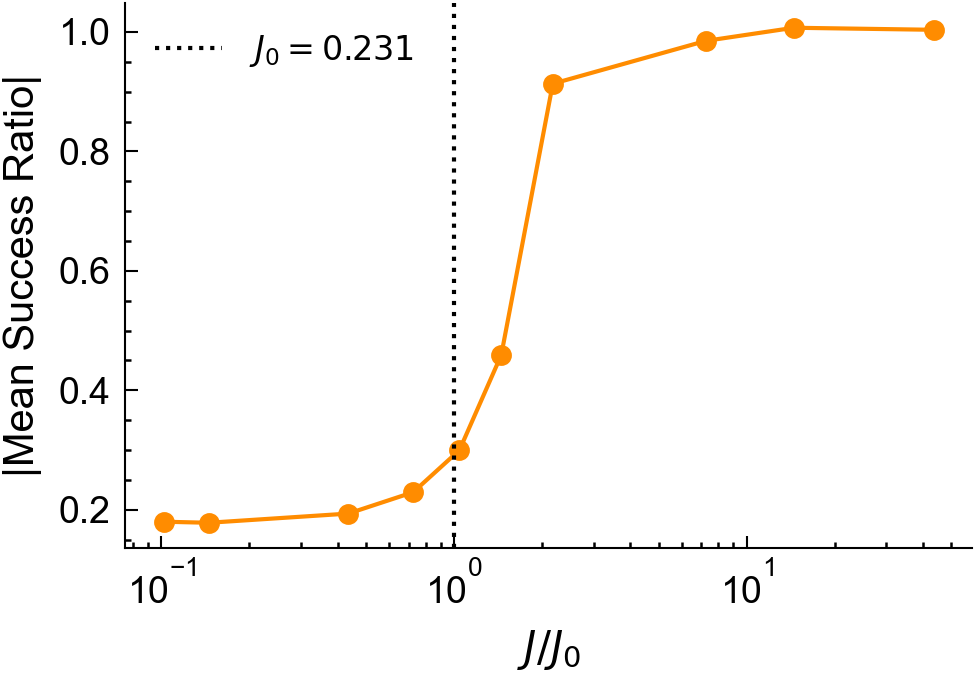

In [28]:

# Prepare amplitude keys and values
amp_keys = amplitudes
amp_vals = np.array([float(a) for a in amp_keys])
J_vals_new = a_to_J * amp_vals

# Integration limit in µs
t_max = 6.0  # µs

integrals = []
integrals_abs = []

for a_str in amp_keys:
    df = data_dict['f'][a_str]['scaled']
    de = data_dict['e'][a_str]['scaled']
    t_us = df['time'].values / 1000  # ns → µs
    ratio = (1 - de['P_g_z'].values) / (1 - df['P_g_z'].values)

    # Clip to t <= 6 µs
    mask = t_us <= t_max
    t_clip = t_us[mask]
    ratio_clip = ratio[mask]

    # Trapezoidal integration
    integral = (1 / t_max) * np.trapz(ratio_clip, t_clip)
    integral_abs = (1 / t_max) * np.trapz(np.abs(ratio_clip), t_clip) 

    integrals.append(integral)
    integrals_abs.append(integral_abs)

# Plot
plt.figure()
J_avg_df = pd.DataFrame({'J_val':J_vals_new, 'mean_success':integrals_abs})
J_avg_df.to_csv('j_avgs.csv', index = False)
plt.plot(J_vals_new/j_sweep_popt[1], integrals_abs, 'o-', color="darkorange")
plt.axvline(j_sweep_popt[1]/j_sweep_popt[1], ls = 'dotted', c = 'black', label = rf"$J_0 = {np.round(j_sweep_popt[1],3)}$")
plt.ylabel("|Mean Success Ratio|")
plt.xlabel(r"$J/J_0$")
plt.xscale('log')
plt.legend()

plt.tight_layout()
# savefig_tight("Images/postselection_success_integrals_trapz.pdf")
plt.show()


In [19]:
j_sweep_popt[1]

0.23130038585579454

In [20]:
ep_tomo = data_dict['e']['0.0007193']['scaled']

In [21]:
for amp_key in amplitudes:
    for state_key in init_states:
        data_set = data_dict[state_key][amp_key]['scaled']
        j_val =float(amp_key)*a_to_J
        data_set.to_csv(f'tomo_data/init_{state_key}_{j_val:.3f}.csv')

In [22]:
hermitian_transit_times = []
J_val_list = []
for amp_key in amplitudes:
    J_val_from_amp = float(amp_key)*a_to_J
    J_val_list.append(J_val_from_amp)
    transit_time = np.pi/J_val_from_amp
    hermitian_transit_times.append(transit_time)

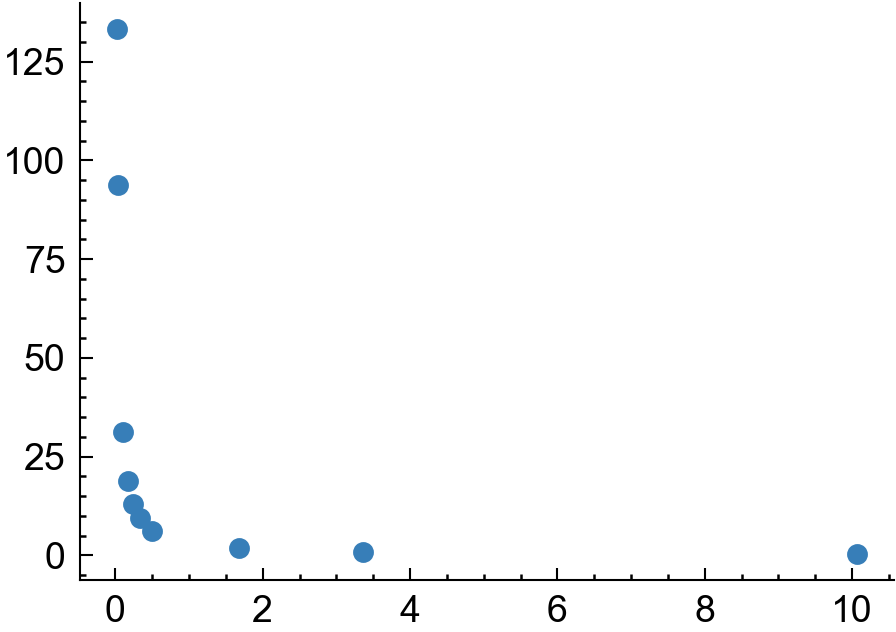

In [23]:
plt.scatter(J_val_list, hermitian_transit_times)

actual transit = 5.656
actual transit = 0.036


<Figure size 1050x750 with 0 Axes>

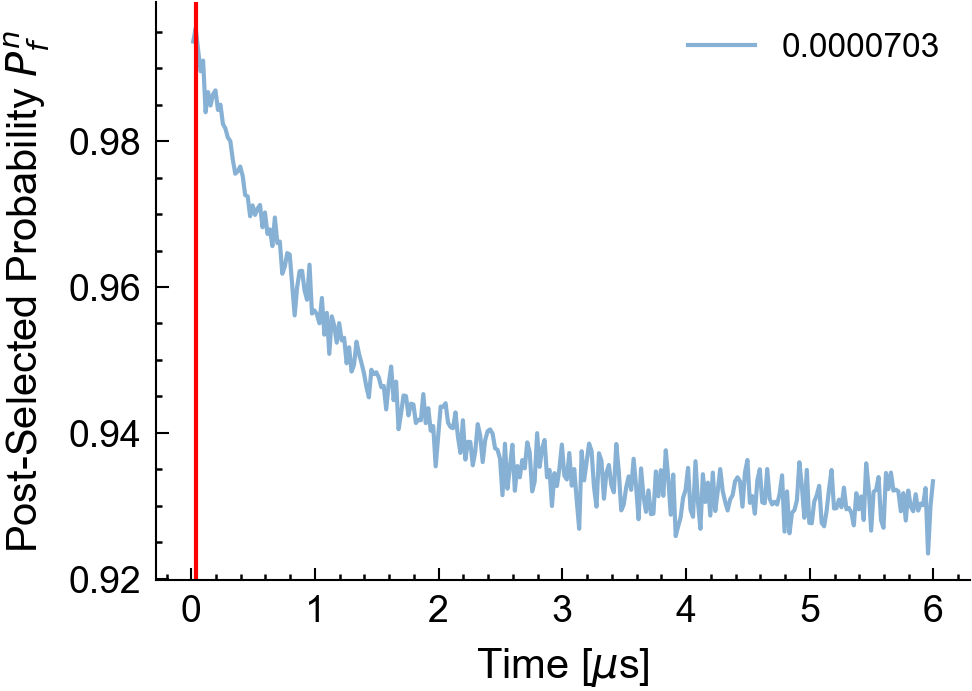

actual transit = 5.796
actual transit = 0.036


<Figure size 1050x750 with 0 Axes>

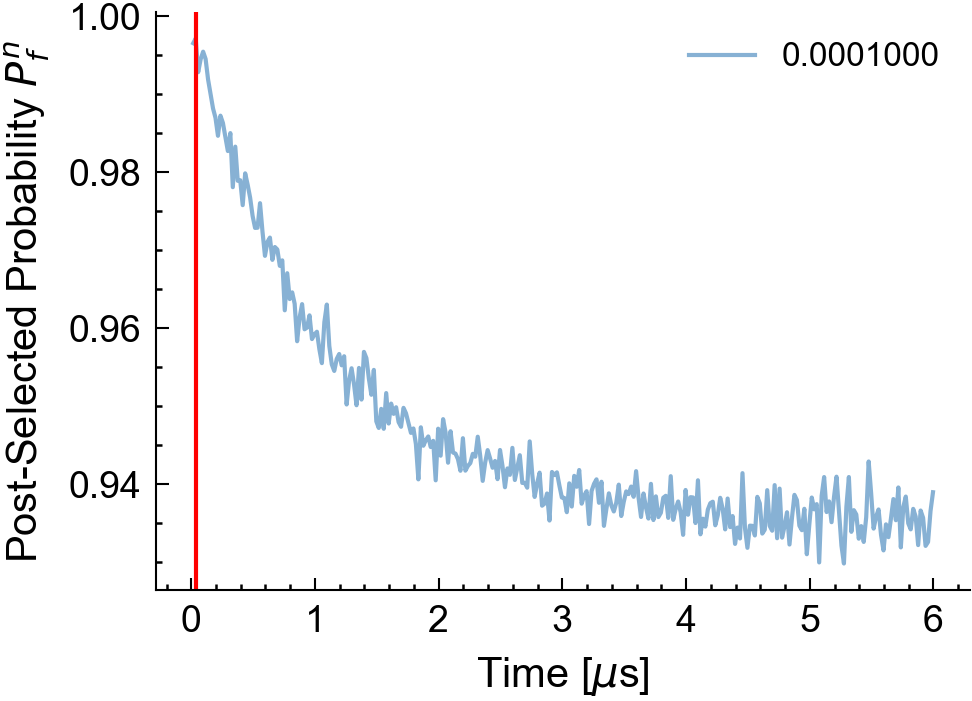

actual transit = 5.936
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

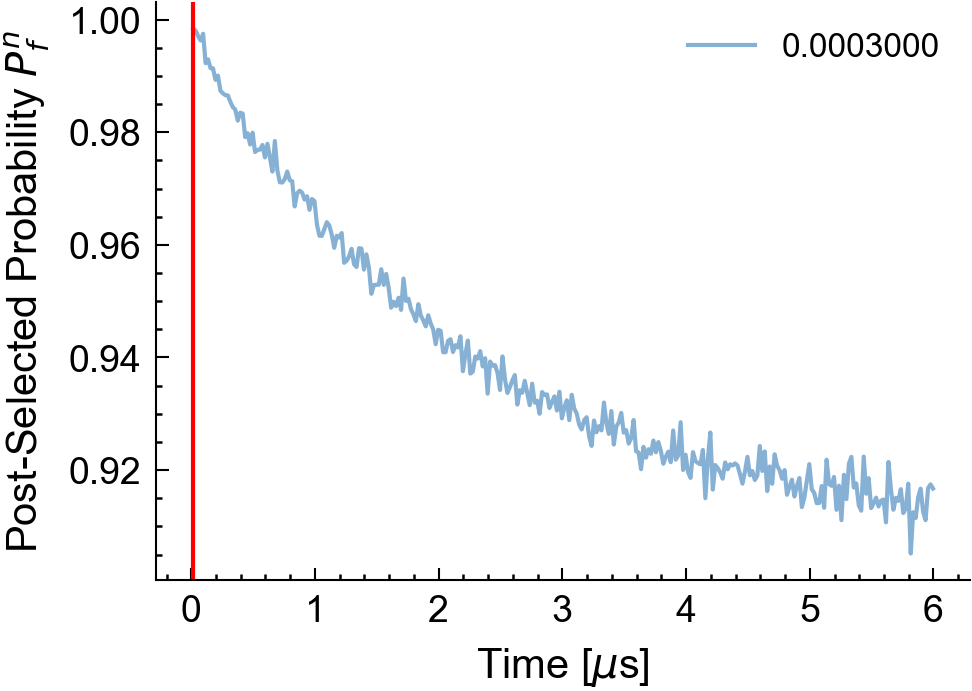

actual transit = 5.976
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

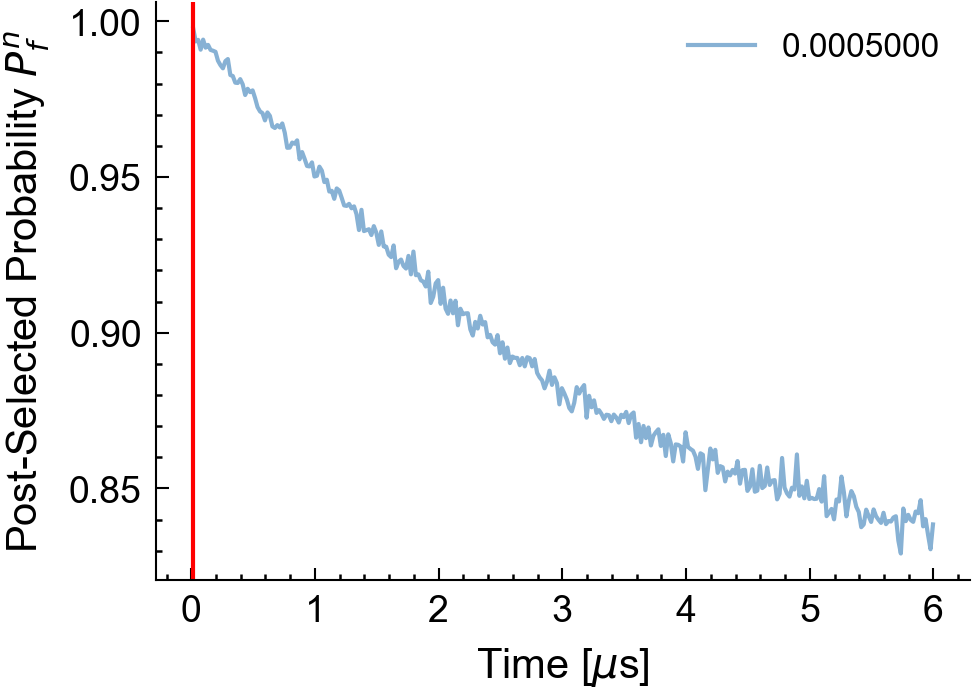

actual transit = 4.136
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

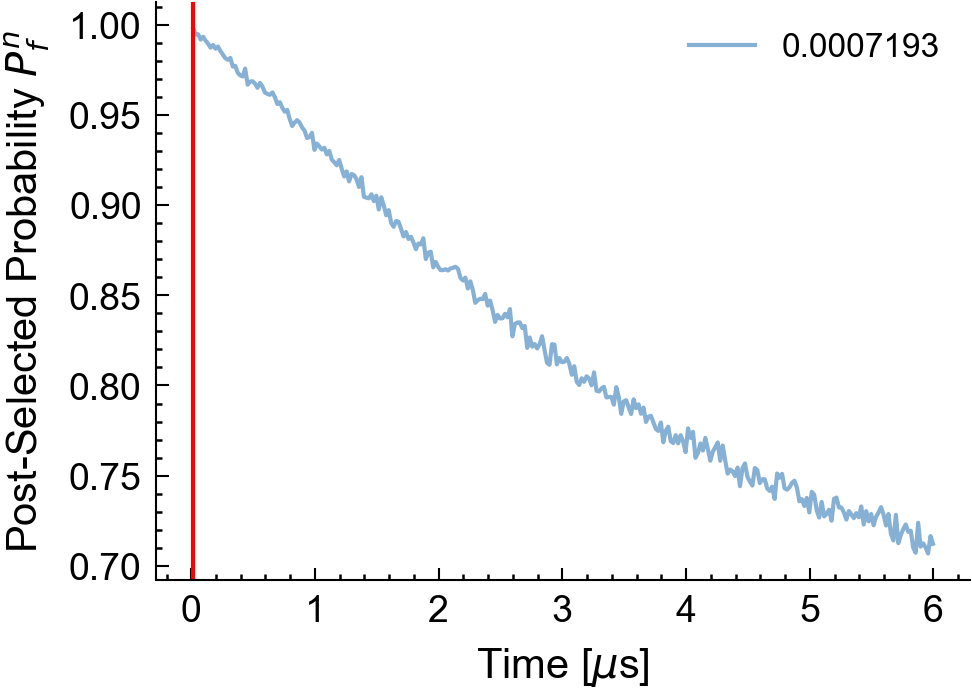

actual transit = 3.496
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

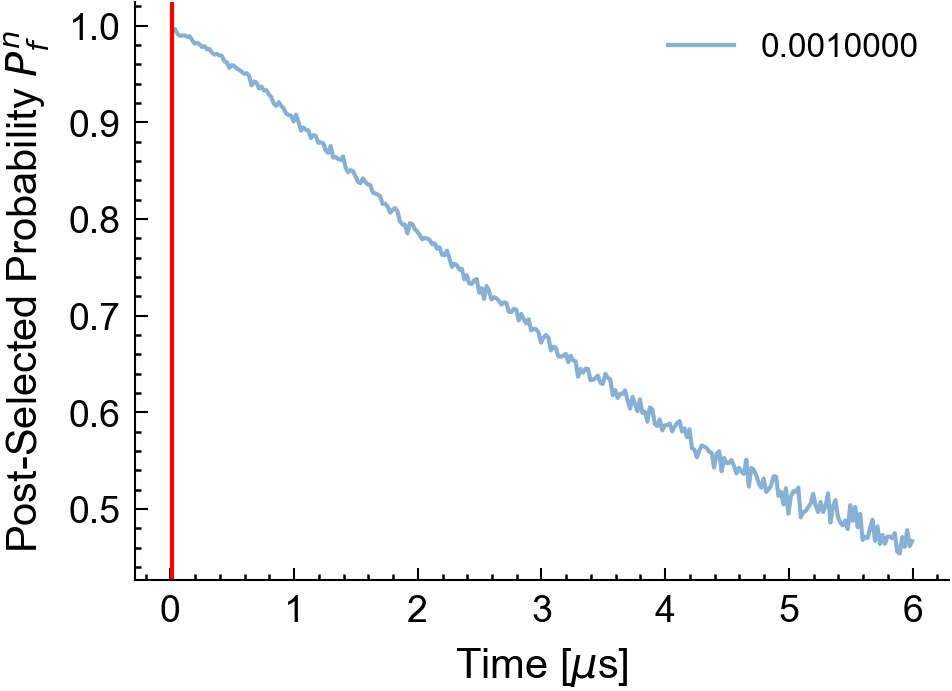

actual transit = 2.436
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

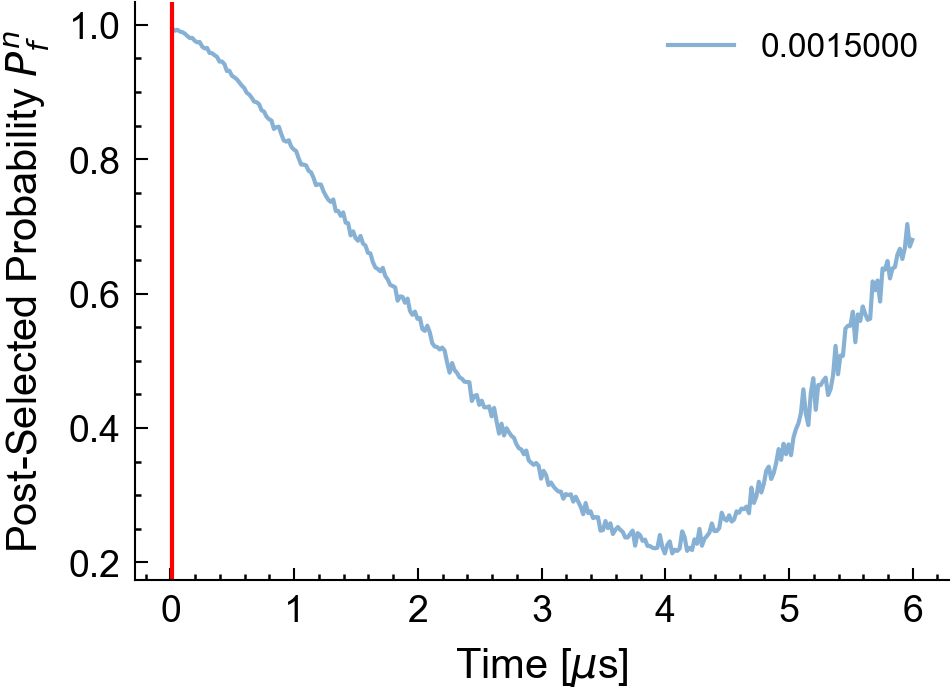

actual transit = 0.836
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

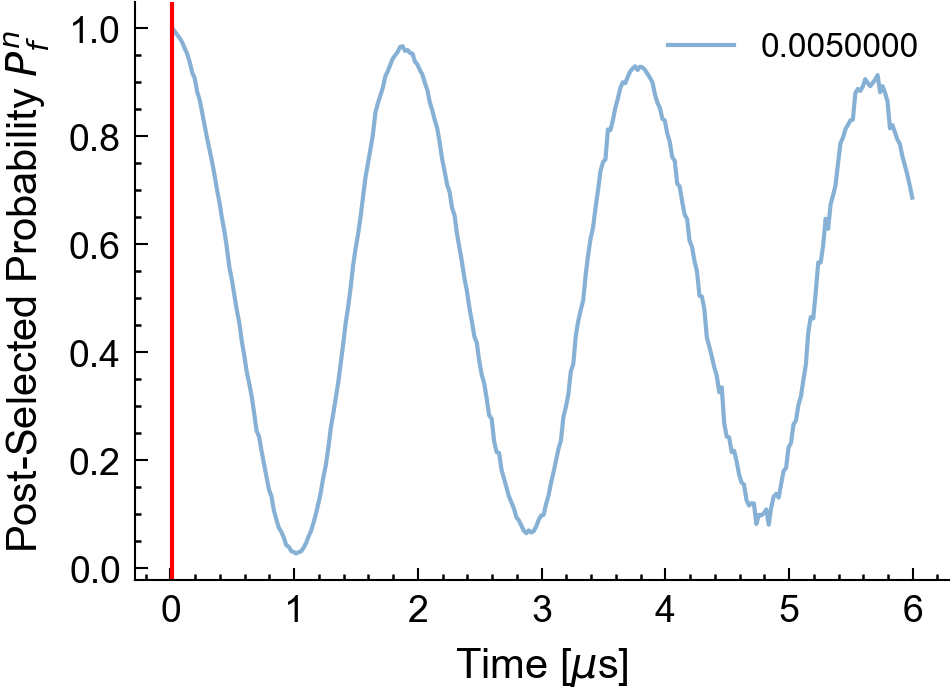

actual transit = 0.436
actual transit = 0.016


<Figure size 1050x750 with 0 Axes>

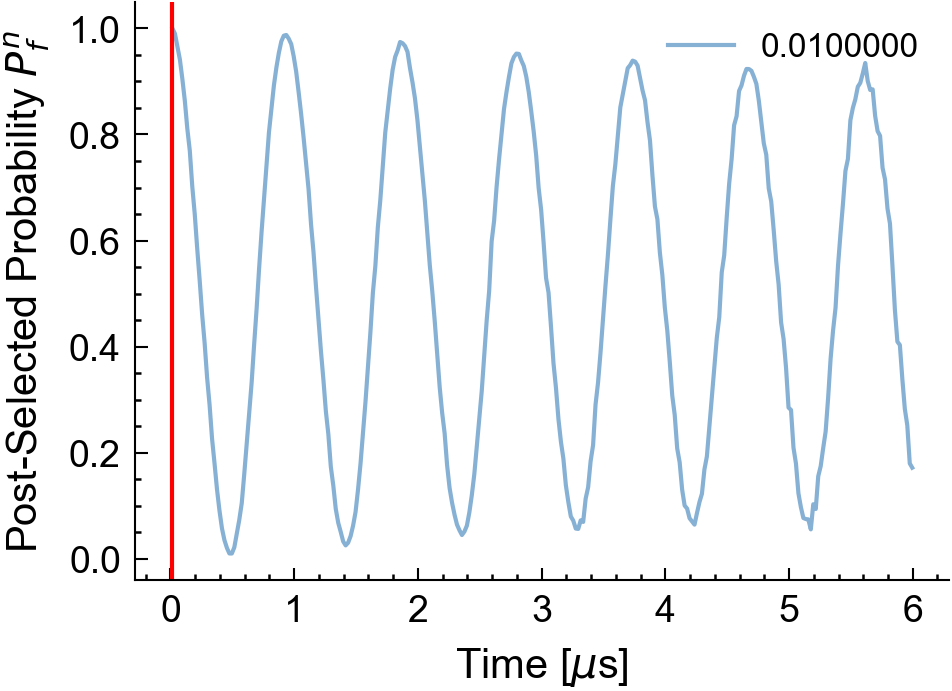

actual transit = 0.456
actual transit = 0.296


<Figure size 1050x750 with 0 Axes>

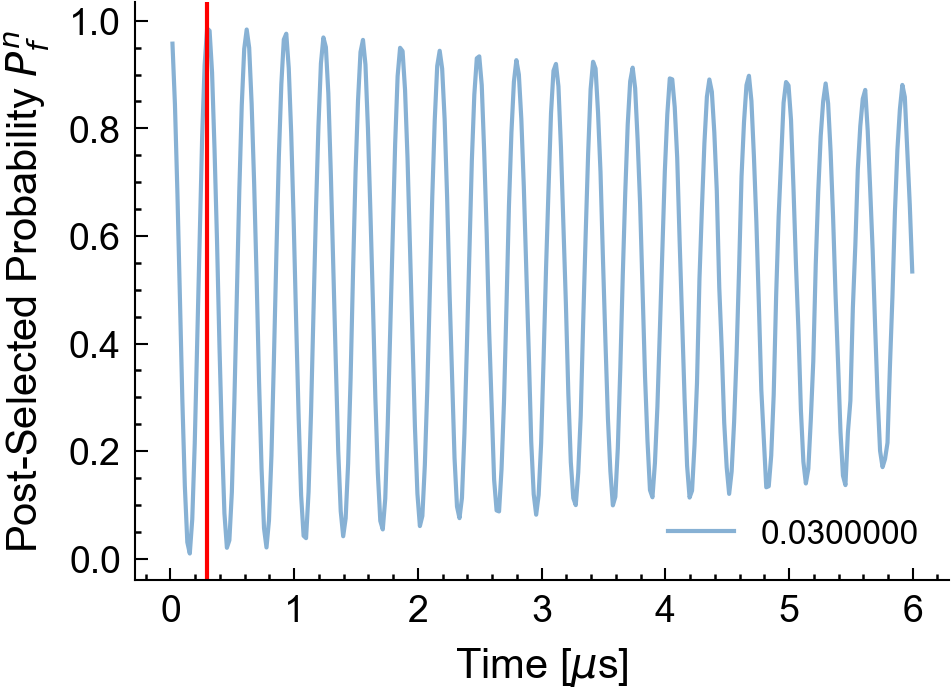

In [24]:
actual_transits_ef = []
actual_transits_fe = []
init_states = ['e','f']
for amp in amplitudes:
    plt.figure()
    for states in init_states:
        ep_tomo = data_dict[states][amp]['scaled']
        normalized_z = ep_tomo['P_f_z']/(ep_tomo['P_f_z'] + ep_tomo['P_e_z'])
        scaled_time = ep_tomo['time']/1000
        peak_index = np.argmax(normalized_z)
        valley_index = np.argmin(normalized_z)
        
        print(f'actual transit = {scaled_time[peak_index]}')
        if states == 'e':
            actual_transits_ef.append(scaled_time[peak_index])
        elif states == 'f':
            actual_transits_fe.append(scaled_time[valley_index])
    plt.figure()
    plt.plot(scaled_time, normalized_z, label = amp, alpha = 0.6)
    plt.axvline(scaled_time[peak_index], c = 'red')
    plt.legend()
    plt.xlabel(r'Time [$\mu$s]')
    plt.ylabel(r'Post-Selected Probability $P^n_f$')
    plt.show()

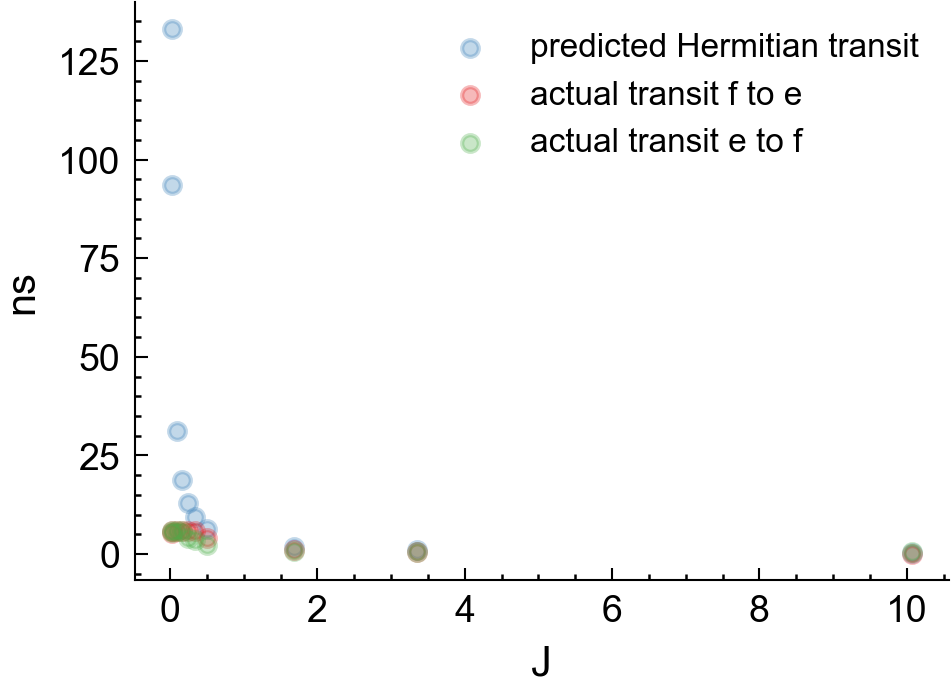

In [25]:
plt.scatter(J_val_list, hermitian_transit_times, alpha = 0.3, label = 'predicted Hermitian transit')
plt.scatter(J_val_list, actual_transits_fe, alpha = 0.3, label = 'actual transit f to e')
plt.scatter(J_val_list, actual_transits_ef, alpha = 0.3, label = 'actual transit e to f')
plt.legend()
plt.xlabel('J')
plt.ylabel('ns')
transit_data = {
    'j_val' : J_val_list,
    'hermitian_transit': hermitian_transit_times,
    'actual_transit_ef': actual_transits_ef,
    'actual_transit_fe': actual_transits_fe
               }
transit_df = pd.DataFrame(transit_data)
transit_df.to_csv('transit_df.csv')

In [26]:
J_val_list

[0.023585580807583394,
 0.033549901575509807,
 0.10064970472652941,
 0.16774950787754903,
 0.24132444203264203,
 0.33549901575509805,
 0.5032485236326472,
 1.6774950787754903,
 3.3549901575509806,
 10.064970472652941]

NameError: name 'actual_transits' is not defined

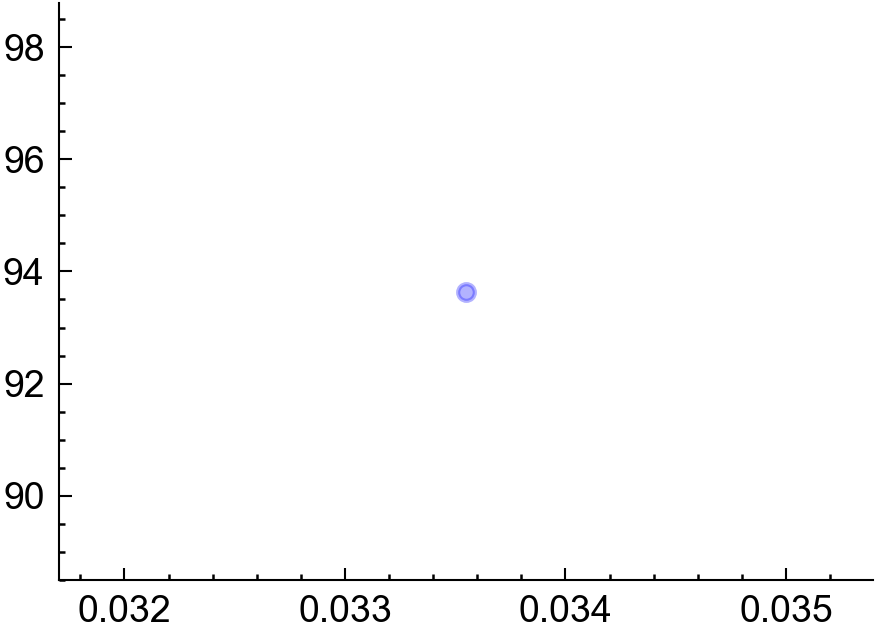

In [27]:
plot_indicies = [1,2,3,4,7]

for index in plot_indicies:
    
    plt.scatter(J_val_list[index], hermitian_transit_times[index], alpha = 0.3, c = 'blue')
    plt.scatter(J_val_list[index], actual_transits[index], alpha = 0.3, c= 'red')